# 1. Постановка задачи

Необходимо разработать сервис для предсказания цены домов на основе исторических данных о предложениях. Цель проекта — предоставить инструмент, который поможет риэлторам, покупателям и продавцам недвижимости оценивать рыночную стоимость объектов. Создать серию моделей машинного обучения и из них выбрана лучшая. Вывести модель в продакшен.

# 2. Первичный анализ данных

In [133]:
from datetime import date
import re
import warnings

from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import optuna
import pandas as pd
import pickle
import seaborn as sns
import sklearn.preprocessing as pp
import statsmodels.api as sm
from scipy import stats
from sklearn import ensemble
from sklearn.ensemble import StackingRegressor
from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import tree
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from statsmodels import stats as sms

warnings.filterwarnings('ignore')
%matplotlib inline

Первым делом необходимо понять, с какими данными нам предстоит работать, и произвести базовую предобработку данных, переведя признаки в необходимые для дальнейшей работы форматы.

Для начала давайте познакомимся с нашими данными:

In [2]:
data = pd.read_csv('Data/data.csv')

In [3]:
print('Data shape: {}'.format(data.shape))
data.head(2)

Data shape: (377185, 18)


,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"


Итак, у нас есть данные о более чем 370 тысяч объявлений о продаже недвижимости. Каждая из них описывается следующими признаками:

* **status** - статус продажи
* **private pool** и **PrivatePool** - наличие частного бассейна,
* **propertyType** - тип недвижимости, поместья, свойства,
* **street** - адрес дома
* **baths** - количество ванных комнат
* **homeFacts** - сведения о строении дома, содержит несколько отдельных данных, имеющих влияние на оценку недвижимости, дома, квартиры
* **fireplace** - сведения о наличии камина(ов) в доме
* **city** - город
* **schools** - сведения о школах в районе
* **sqft** - площадь дома в футах
* **zipcode** - почтовый индекс
* **beds** - количество спален в доме
* **state** - государство/штаты
* **stories** - этажность недвижимости
* **mls-id** и **MlsId** - идентификатор MLS (Multiple Listing Service - Служба множественного листинга)
* **target** - целевой признак, который необходимо спрогнозировать - цена недвижимости


Выводим информацию о признаках:

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103114 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226469 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

Проверяем наличие пропусков:

In [5]:
data.isnull().sum()

status           39918
private pool    373004
propertyType     34733
street               2
baths           106338
homeFacts            0
fireplace       274071
city                34
schools              0
sqft             40577
zipcode              0
beds             91282
state                0
stories         150716
mls-id          352243
PrivatePool     336874
MlsId            66880
target            2481
dtype: int64

Выводим описательные статистики для категориальных и строковых признаков:

In [6]:
data.describe(include='object')

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
count,337267,4181,342452,377183,270847,377185,103114,377151,377185,336608,377185,285903,377185,226469,24942,40311,310305,374704
unique,159,1,1280,337076,229,321009,1652,2026,297365,25405,4549,1184,39,347,24907,2,232944,43939
top,for sale,Yes,single-family home,Address Not Disclosed,2 Baths,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",yes,Houston,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,32137,3 Beds,FL,1.0,No MLS#,yes,NO MLS,"$225,000"
freq,156104,4181,92206,672,52466,7174,50356,24442,4204,11854,2141,53459,115449,67454,3,28793,24,1462


Проверяем данные на наличие дубликатов и удаляем их:

In [7]:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

data = data.drop_duplicates()
print('Размер таблицы после удаления дубликатов: {}'.format(data.shape))

Количество дубликатов: 50
Размер таблицы после удаления дубликатов: (377135, 18)


Удаляем строки с попущенными значениями в целевом столбце:

In [8]:
data.dropna(axis='index', subset=['target'], inplace=True)
print('Количество строк: {}'.format(data.shape[0]))

Количество строк: 374655


# 3. Предобработка и очистка данных

Преобразуем целевой столбец: удаляем все символы, не являющиеся цифрами, и приводим значения к числовому типу.

In [9]:
def extract_numeric_value(arg):
    '''Функция для извлечения числовой части.'''
    # Удаляем лишние символы
    cleaned_arg = arg.replace(' ', '').replace(',', '').replace(
        '+', '').replace('$', '').replace('/', '')

    # Удаляем буквы с помощью регулярного выражения
    cleaned_arg = re.sub(r'[A-Za-z]', '', cleaned_arg)

    # Разбиваем строку по дефису и берём первую часть
    parts = cleaned_arg.split('-')
    numeric_part = parts[0]

    return numeric_part


# Применяем функцию ко всем значениям столбца 'target'
data['target'] = data['target'].apply(extract_numeric_value)

# Преобразуем очищенные строки в числовой формат (float)
data['target'] = data['target'].astype(float)

Преобразуем столбец **status**. В нем содержится статус объекта недвижимости. Выделим наиболее популярные категории. Объектам, которые не попали ни в одну из них, присвоим категорию other.

In [10]:
def get_status(arg):
    '''Определяет статус на основе входной строки.'''
    # Списки ключевых слов для каждого статуса
    active = ['a', 'active', 'active/contingent']
    back_change = ['back', 'change']
    coming_soon = ['coming']
    contract = ['c', 'under']
    for_sale = ['for']
    fore_closure = ['auction', 'foreclosed', 'foreclosure', 'pre-foreclosure']
    new = ['n', 'new']
    pending = ['p', 'pending']
    rent = ['rent']

    # Приводим строку к нижнему регистру и разбиваем её на слова
    splitted_st = arg.lower().split(' ')

    # Проверяем каждое слово на соответствие спискам
    for word in splitted_st:
        if word in active:
            return 'active'
        elif word in back_change:
            return 'back changes'
        elif word in coming_soon:
            return 'coming soon'
        elif word in contract:
            return 'contract'
        elif word in for_sale:
            return 'for sale'
        elif word in fore_closure:
            return 'foreclosure'
        elif word in new:
            return 'new'
        elif word in pending:
            return 'pending'
        elif word in rent:
            return 'rent'

    # Если ни одно слово не подходит, возвращаем "other"
    return 'other'


# Преобразуем столбец в строки и применяем функцию для определения статуса
data['status'] = data['status'].astype(str).apply(get_status)

Посмотрим на среднее значение цены недвижимости в зависимсоти от статуса объявления.

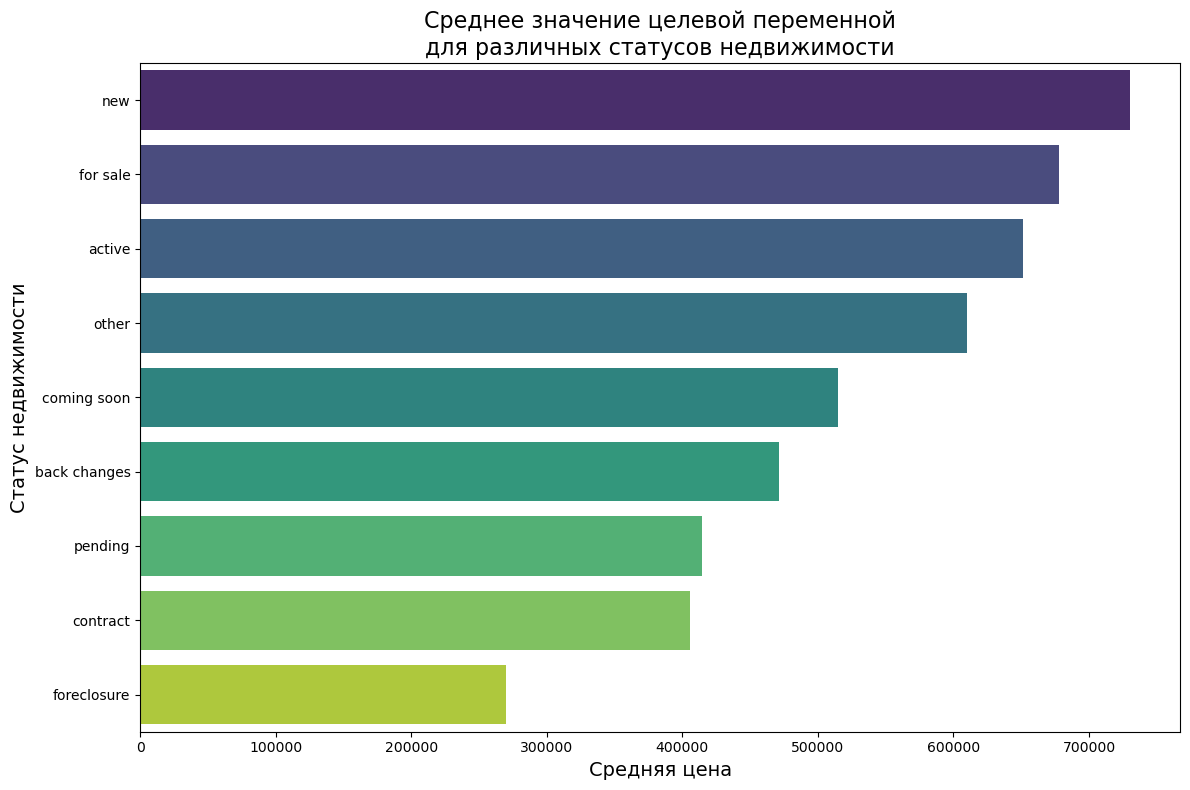

In [11]:
status_grouped = (
    data.groupby('status')['target']
    .mean()
    .nlargest(9)
)

# Настройка размера графика
plt.figure(figsize=(12, 8))

# Построение горизонтальной столбчатой диаграммы
sns.barplot(
    x=status_grouped.values,  # Значения средней цены
    y=status_grouped.index,   # Категории статусов
    palette='viridis'
)

# Подписи осей и заголовок графика
plt.xlabel('Средняя цена', fontsize=14)
plt.ylabel('Статус недвижимости', fontsize=14)
plt.title('Среднее значение целевой переменной\n'
          'для различных статусов недвижимости',
           fontsize=16
)

# Отображение графика
plt.tight_layout()
plt.show()

Вывод: статус **new** имеет самую высокую среднюю цену, что логично, так как новое обычно ассоциируется с дорогим. Также видна разница в ценах для других статусов.

Классифицируем типы недвижимости, представленные в данных, упрощая их до нескольких основных категорий. Мы обрабатываем текстовые значения в столбце **propertyType**, сопоставляя их с заранее определёнными группами, и присваиваем каждой записи соответствующую категорию. Если значение не попадает ни в одну из категорий или отсутствует, мы относим его к группе 'Other'.

In [12]:
def get_type(arg):
    """
    Определяет тип недвижимости на основе переданного значения. 
    Возвращает 1 из 7 основных типов или 'Other' 
    для остальных значений.
    """
    # Списки категорий недвижимости
    family_type_list = [
        'single-family home', 'Single Family', 'Single Family Home',
        'Detached', 'Tiny Home', 'Single Detached',
        'SingleFamilyResidence', 'Single Detached, Traditional'
    ]
    condo_type_list = [
        'Condo', 'condo', 'coop', 'Condo/Townhome',
        'Cooperative', 'Condo/Townhome/Row Home/Co-Op'
    ]
    land_list = ['lot/land', 'Land']
    multi_list = [
        'multi-family', 'Multi Family',
        'Multi-Family Home', 'Multiple Occupancy'
    ]
    townhouse_list = ['townhouse', 'Townhouse', 'Townhome']
    luxury_list = [
        'Ranch', 'Farms/Ranches', 'High Rise', 'Garden Home',
        'Bungalow'
    ]
    mobile_list = [
        'mobile/manufactured', 'Mobile / Manufactured', 
        'Mfd/Mobile Home'
    ]

    # Проверка на пустое значение
    if arg is np.nan or arg == '':
        return np.nan

    # Определение типа недвижимости
    if arg in family_type_list:
        return 'Single Family'
    elif arg in condo_type_list:
        return 'Condo'
    elif arg in land_list:
        return 'Land'
    elif arg in multi_list:
        return 'Multi Family'
    elif arg in townhouse_list:
        return 'Townhouse'
    elif arg in luxury_list:
        return 'Luxury'
    elif arg in mobile_list:
        return 'Mobile'

    # Если не совпало ни с одной категорией
    return 'Other'


# Применение функции к столбцу propertyType
data['propertyType'] = data['propertyType'].apply(get_type)

# Заполнение пропущенных значений типом "Other"
data['propertyType'] = data['propertyType'].fillna('Other')

Посмотрим на среднее значение цены недвижимости в зависимсоти от типа недвижимости.

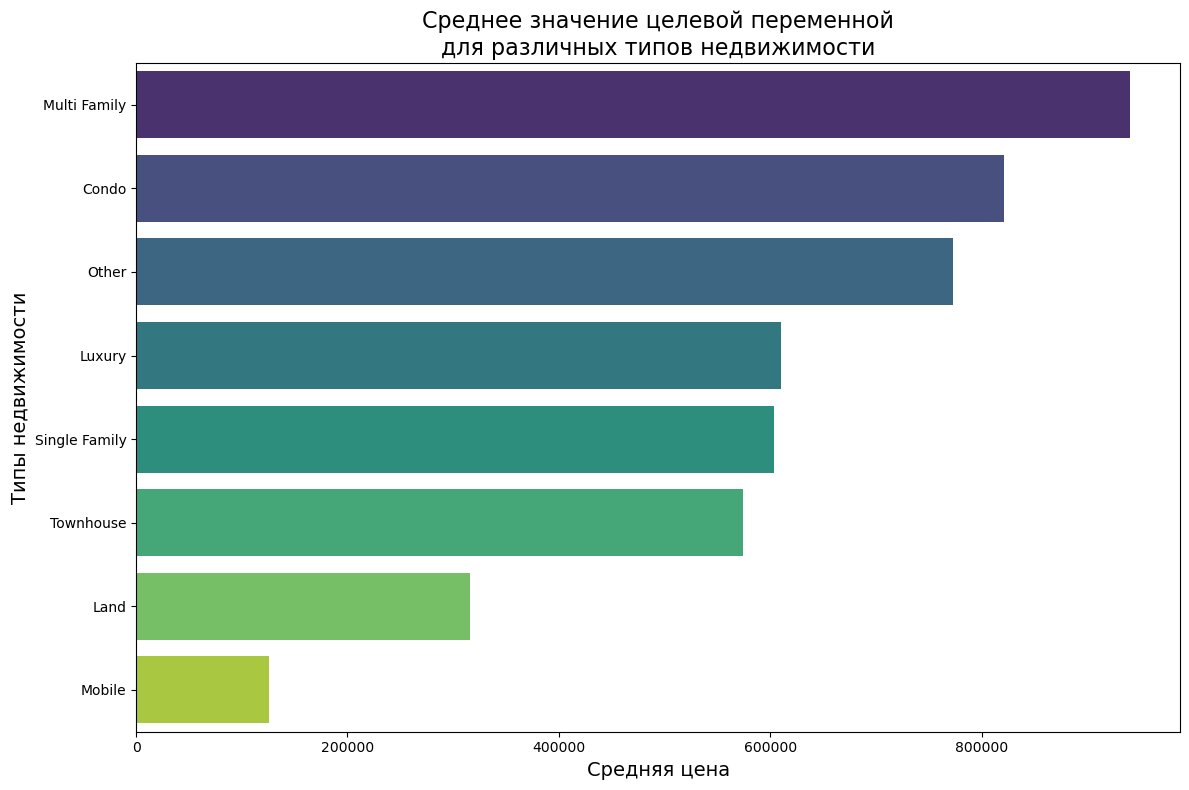

In [13]:
property_type_grouped = (
    data.groupby('propertyType')['target']
    .mean()
    .nlargest(9)
)

# Настройка размера графика
plt.figure(figsize=(12, 8))

# Построение горизонтальной столбчатой диаграммы
sns.barplot(
    x=property_type_grouped.values,  # Значения средней цены
    y=property_type_grouped.index,   # Категории типов недвиж.
    palette='viridis'
)

# Подписи осей и заголовок графика
plt.xlabel('Средняя цена', fontsize=14)
plt.ylabel('Типы недвижимости', fontsize=14)
plt.title('Среднее значение целевой переменной\n'
          'для различных типов недвижимости',
           fontsize=16
)

# Отображение графика
plt.tight_layout()
plt.show()

Средняя цена выше для типа недвижимости **Multi family**, что может быть связано с коммерческими объектами, требующими больше площади. Самые дешевые - мобильные дома, что не удивительно.

Очищаем столбец **homeFacts** от лишних символов и маркеров, извлекаем ключевые характеристики (например, год постройки, площадь участка, цена за квадратный фут) с использованием регулярных выражений и преобразование их в подходящие типы данных (int, float, str). Результат сохраняем в новых столбцах датафрейма.

In [14]:
def get_lotsize_measure(home_facts_str):
    '''
    Определяет, содержит ли строка упоминание 
    о единице измерения площади "acre".
    '''
    if re.search(r"acre['s]*", home_facts_str):
        return 'acre'
    return None


def process_home_facts(home_facts):
    '''
    Очищает строку с фактами о недвижимости, 
    удаляя ненужные символы и текстовые маркеры.
    '''
    # Приводим строку к нижнему регистру
    home_facts = home_facts.lower()
    
    # Удаляем запятые между цифрами
    home_facts = re.sub(r'(\d),(\d)', r'\1\2', home_facts)
    
    # Удаляем ненужные символы и текстовые маркеры
    remove_list = [
        '$', ' sqft', '/sqft', ' sq. ft.', ' lot', 
        ' acres', ' acre', 'contact manager', 
        '—', '-', ' /', 'no info'
    ]
    for item in remove_list:
        home_facts = home_facts.replace(item, '')
    
    return home_facts


# Добавляем столбец с единицей измерения площади участка
data['lotsize_measure'] = data['homeFacts'].apply(get_lotsize_measure)

# Очищаем данные в столбце "homeFacts"
data['homeFacts'] = data['homeFacts'].apply(process_home_facts)

# Регулярное выражение для поиска пар "ключ-значение"
pattern = r"{'factvalue': '(.*?)', 'factlabel': '(.*?)'}"

# Проходим по каждой строке и извлекаем данные
for i, row in data.iterrows():
    home_facts_str = row['homeFacts']
    
    # Ищем все пары "ключ-значение" в строке
    matches = re.finditer(pattern, home_facts_str)
    
    # Сохраняем результаты в словарь
    home_facts = {}
    for match in matches:
        factvalue = match.group(1)
        factlabel = match.group(2)
        home_facts[factlabel] = factvalue
    
    # Обновляем значения в датафрейме
    
    # Преобразуем "year built" и "remodeled year" в int
    year_built = home_facts.get('year built')
    if year_built and year_built not in {'no data', ''}:
        data.at[i, 'year built'] = int(year_built)
    else:
        data.at[i, 'year built'] = None
    
    remodeled_year = home_facts.get('remodeled year')
    if remodeled_year and remodeled_year not in {'no data', ''}:
        data.at[i, 'remodeled year'] = int(remodeled_year)
    else:
        data.at[i, 'remodeled year'] = None
    
    # Сохраняем "heating", "cooling", "parking" как строки
    data.at[i, 'heating'] = home_facts.get('heating')
    data.at[i, 'cooling'] = home_facts.get('cooling')
    data.at[i, 'parking'] = home_facts.get('parking')
    
    # Преобразуем "lotsize" и "price" в float
    lot_size = home_facts.get('lotsize')
    if lot_size and lot_size not in {'no data', ''}:
        data.at[i, 'lotsize'] = float(lot_size)
    else:
        data.at[i, 'lotsize'] = None
    
    price_sqft = home_facts.get('price')
    if price_sqft and price_sqft not in {'no data', ''}:
        data.at[i, 'price'] = float(price_sqft)
    else:
        data.at[i, 'price'] = np.nan

In [15]:
# Преобразуем значения столбца lotsize в float64
data['lotsize'] = pd.to_numeric(data['lotsize'], errors='coerce')

Посмотрим на новые столбцы датафрейма:

In [16]:
print(data[['lotsize_measure', 'year built', 'remodeled year',
      'heating', 'cooling', 'parking', 'lotsize', 'price']].head(12))

   lotsize_measure  year built remodeled year                 heating  \
0             None      2019.0           None  central a/c, heat pump   
1             None      2019.0           None                           
2             None      1961.0           1967              forced air   
3             None      2006.0           2006              forced air   
4             None         NaN           None                           
5             None      1920.0           None              forced air   
6             None      2006.0           2006     electric, heat pump   
7             None      1976.0           None                           
8             None      1970.0           None              forced air   
9             None      2019.0           None                     gas   
10            acre      1965.0           None                           
11            None      2015.0           2015        central electric   

        cooling          parking    lotsize  price

Очищаем столбец **schools**, извлекаем из него рейтинги и расстояния до школ. В результате созданы столбцы: **school_count** (количество школ), **schools_rating_ave** (средний рейтинг), и **schools_distance_ave** (среднее расстояние).

In [17]:
# Преобразуем столбец 'schools' в строковый формат
data['schools'] = data['schools'].astype(str)

# Удаляем текст, начинающийся с 'data'
data['schools_rating'] = data['schools'].apply(
    lambda x: re.sub(r'data.*', '', x)
)

# Удаляем '/10'
data['schools_rating'] = data['schools_rating'].apply(
    lambda x: re.sub(r'/10', '', x)
)

# Убираем все символы, кроме букв, цифр и запятых
data['schools_rating'] = data['schools_rating'].apply(
    lambda x: re.sub(r'[^\w\s,]', '', x)
)

# Удаляем слово 'rating'
data['schools_rating'] = data['schools_rating'].apply(
    lambda x: x.replace('rating', '')
)

# Удаляем последние два символа
data['schools_rating'] = data['schools_rating'].apply(
    lambda x: x[:-2]
)

# Удаляем первый символ
data['schools_rating'] = data['schools_rating'].apply(
    lambda x: x[1:]
)

# Считаем количество школ по запятым
data['school_count'] = data['schools_rating'].apply(
    lambda x: len(x.split(',')) if x != '' else 0
)

# Преобразуем количество школ в целое число
data['school_count'] = data['school_count'].astype(int)

# Удаляем буквы из строки рейтингов
data['schools_rating'] = data['schools_rating'].apply(
    lambda x: re.sub(r'[a-zA-Z]', '', x)
)

# Убираем пробелы перед запятыми
data['schools_rating'] = data['schools_rating'].apply(
    lambda x: re.sub(r'\s+,', '', x)
)

# Удаляем последний символ строки
data['schools_rating'] = data['schools_rating'].apply(
    lambda x: x[:-1]
)

# Преобразуем строку с рейтингами в список чисел
data['schools_rating_list'] = data['schools_rating'].apply(
    lambda x: [int(i) for i in re.findall(r'\d+', x)]
)

# Вычисляем средний рейтинг школ, округляем до двух знаков
data['schools_rating_ave'] = data['schools_rating_list'].apply(
    lambda x: round(sum(x) / len(x), 2) if len(x) > 0 else 0
)

# Округляем средний рейтинг до двух знаков после запятой
data['schools_rating_ave'] = data['schools_rating_ave'].apply(
    np.round, decimals=2
)

# Вычисляем среднее значение по столбцу рейтингов
average = data['schools_rating_ave'].mean()

# Заменяем низкие рейтинги (<1) на среднее значение по столбцу
data['schools_rating_ave'] = data['schools_rating_ave'].apply(
    lambda x: average if x < 1 else x
)

# Функция для извлечения расстояний между ключевыми словами
def extract_text(text):
    """
    Извлекает текст между "Distance': ['" и "'], 'Grades'".
    Возвращает None, если совпадений нет.
    """
    pattern = r"Distance': \['(.+?)'\], 'Grades'"
    match = re.search(pattern, text)
    if match:
        return match.group(1)
    return None

# Извлекаем расстояния до школ из текста столбца 'schools'
data['schools_distance'] = data['schools'].apply(extract_text)

# Преобразуем расстояния до школ в строковый формат
data['schools_distance'] = data['schools_distance'].astype(str)

# Убираем единицы измерения "mi"
data['schools_distance'] = data['schools_distance'].apply(
    lambda x: re.sub(r'\smi', '', x)
)

# Убираем все символы, кроме чисел, запятых и пробелов
data['schools_distance'] = data['schools_distance'].str.replace(
    r'[^\d.,\s]', '', regex=True
)

# Преобразуем строку с расстояниями в список чисел (float)
data['schools_distance'] = data['schools_distance'].apply(
    lambda x: [float(num) for num in x.split(',')] if x else []
)

# Вычисляем среднее расстояние до школ, округляем до двух знаков
data['schools_distance_ave'] = data['schools_distance'].apply(
    lambda x: round(sum(x) / len(x), 2) if len(x) > 0 else 0
)

Посмотрим на новые столбцы датафрейма:
* **school_count** - количество школ
* **schools_rating_ave** - средний рейтинг школ
* **schools_distance_ave** - среднее расстояние до школ

In [18]:
print(data[['school_count', 'schools_rating_ave', 
            'schools_distance_ave']].head())

   school_count  schools_rating_ave  schools_distance_ave
0             8                5.20                  5.54
1             3                4.00                  1.33
2             3                6.00                  1.96
3             4                9.33                  0.75
4             3                4.50                  4.08


Удаляем столбцы **homeFact**, **schools** и вспомогательные столбцы, использованные для расчета среднего рейтинга и среднего расстояния до школы.

In [19]:
data = data.drop(['homeFacts', 'schools', 'schools_rating_list',
                 'schools_rating', 'schools_distance'], axis=1)

Признак "Год постройки" обладает низкой информативностью. Для повышения значимости данных создадим новый признак — "Возраст здания", рассчитанный относительно текущего года.

In [20]:
# Получаем текущую дату
today = date.today()

# Определяем текущий год
this_year = today.year

# Считаем возраст здания
data['age_building'] = this_year - data['year built']

# Удаляем записи с отрицательным возрастом
data = data[data['age_building'] >= 0]

In [21]:
print(data['age_building'].head())

0      5.0
1      5.0
2     63.0
3     18.0
5    104.0
Name: age_building, dtype: float64


Очищаем от ненужных данных столбец с данными о площади недвижимости.

In [22]:
def get_sqft(arg):
    '''
    Очищает данные о площади недвижимости 
    и преобразует их в числовой формат.
    '''
    if isinstance(arg, float):
        return arg
    
    # Обрабатываем пустые или некорректные значения
    if arg is np.nan or arg in ['', 'no data', 'none']:
        return np.nan
    
    # Удаляем нечисловые символы из строковых значений
    if isinstance(arg, str):
        sqft = re.sub(r'\D', '', arg)
        return float(sqft) if sqft != '' else np.nan
    
    # Возвращаем np.nan для неизвестных типов данных
    return np.nan


# Применяем функцию к столбцу sqft
data['sqft'] = data['sqft'].apply(get_sqft)

# Преобразуем значения столбца в тип float
data['sqft'] = data['sqft'].astype(float)

In [23]:
data['sqft'].head()

0    2900.0
1    1947.0
2    3000.0
3    6457.0
5     897.0
Name: sqft, dtype: float64

Столбцы **PrivatePool** и **private pool** содержат сведения о наличии бассейна, однако их данные не совпадают. Преобразуем значения в обоих столбцах: 1 — бассейн есть, 0 — бассейна нет. Затем объединим оба столбца в столбец 'Pool'.

In [24]:
# Преобразуем значения в столбце 'PrivatePool' в 1 или 0
data['PrivatePool'] = data['PrivatePool'].apply(
    lambda x: 1 if isinstance(x, str) and x.lower() == 'yes' else 0
)

# Преобразуем значения в столбце 'private pool' в 1 или 0
data['private pool'] = data['private pool'].apply(
    lambda x: 1 if isinstance(x, str) and x == 'Yes' else 0
)

# Объединяем данные из двух столбцов в новый столбец 'Pool'
data['Pool'] = data.apply(
    lambda x: max(x['PrivatePool'], x['private pool']), axis=1
)

In [25]:
data['Pool'].head()

0    0
1    0
2    1
3    0
5    0
Name: Pool, dtype: int64

Удаляем столбцы **PrivatePool** и **private pool**

In [26]:
data = data.drop(['private pool','PrivatePool'], axis = 1)

Преобразуем столбцы **fireplace**, **cooling**, **heating** и **parking**: присваиваем значение 1, если в столбце есть данные, и 0 — если данных нет.

In [27]:
# Список значений, которые считаются отсутствующими данными
no_data_list = ['', 'no data', 'none', 'Not Applicable', 'No', ' ']

# Преобразуем столбец 'fireplace': 1 — данные есть, 0 — данных нет
data['fireplace'] = data['fireplace'].apply(
    lambda x: 0 if x is np.nan or x in no_data_list else 1
)

# Преобразуем столбец 'cooling': 1 — данные есть, 0 — данных нет
data['cooling'] = data['cooling'].apply(
    lambda x: 0 if x is np.nan or x in no_data_list else 1
)

# Преобразуем столбец 'heating': 1 — данные есть, 0 — данных нет
data['heating'] = data['heating'].apply(
    lambda x: 0 if x is np.nan or x in no_data_list else 1
)

# Преобразуем столбец 'parking': 1 — данные есть, 0 — данных нет
data['parking'] = data['parking'].apply(
    lambda x: 0 if x is np.nan or x in no_data_list else 1
)

In [28]:
print(data[['fireplace', 'cooling', 'heating', 'parking']].head())

   fireplace  cooling  heating  parking
0          1        0        1        0
1          0        0        0        0
2          1        1        1        1
3          1        1        1        1
5          0        1        1        0


Преобразуем столбец с данными о количестве ванных комнат

In [29]:
def get_bath(arg):
    '''
    # Функция для обработки данных 
    о количестве ванных комнат
    '''
    # Возвращаем значение, если это число
    if isinstance(arg, float):
        return arg

    # Проверяем на отсутствующие или некорректные данные
    if arg in [np.nan, '', '—', 'no data', 'none']:
        return np.nan

    # Если значение строка, очищаем его от лишних символов
    if isinstance(arg, str):
        # Удаляем пробелы, заменяем запятые на точки и убираем символы
        arg = arg.replace(' ', '').replace(',', '.').replace('+', '') \
                 .replace('~', '').replace(':', '')
        
        # Убираем буквы и двойные точки
        bath = re.sub(r'[A-Za-z]', '', arg).replace('..', '')

        # Если диапазон, берём первое значение
        bath = bath.split('-')[0]

        # Если дробь, берём первое значение
        bath = bath.split('/')[0]

        # Возвращаем результат или NaN, если строка пустая
        return bath if bath != '' else np.nan

    # Если тип данных неизвестен, возвращаем NaN
    return np.nan


# Применяем функцию к столбцу 'baths'
data['baths'] = data['baths'].apply(get_bath)

# Преобразуем значения в столбце 'baths' в тип float
data['baths'] = data['baths'].astype(float)

In [30]:
print(data['baths'].head())

0    3.5
1    3.0
2    2.0
3    8.0
5    NaN
Name: baths, dtype: float64


Преобразуем столбец с данными о кличестве спален

In [31]:
def get_beds(arg):
    '''
    # Функция для обработки данных 
    о количестве спальных комнат
    '''
    # Возвращаем значение, если это число
    if isinstance(arg, float):
        return arg

    # Проверяем на отсутствующие или некорректные данные
    if arg in [np.nan, '', '—', 'no data', 'none']:
        return np.nan

    # Если значение строка, обрабатываем его
    if isinstance(arg, str):
        # Игнорируем строки с ключевыми словами
        if re.search(r'acre|acres|sqft|\$', arg) is None:
            # Удаляем ненужные символы
            beds = re.sub(r'[A-Za-z:+~#]', '', arg).replace(' ', '')

            # Если есть запятые, берём первое значение
            beds = beds.split(',')[0]

            # Если есть диапазон, берём первое значение
            beds = beds.split('-')[0]

            # Возвращаем результат или NaN, если строка пустая
            return beds if beds != '' else np.nan

        # Если строка содержит ключевые слова, возвращаем NaN
        return np.nan

    # Если тип данных неизвестен, возвращаем NaN
    return np.nan


# Применяем функцию к столбцу 'beds'
data['beds'] = data['beds'].apply(get_beds)

# Преобразуем значения в столбце 'beds' в тип float
data['beds'] = data['beds'].astype(float)

In [32]:
data['beds'].head()

0    4.0
1    3.0
2    3.0
3    5.0
5    2.0
Name: beds, dtype: float64

Проверяем столбцы на наличие одинаковых значений

In [33]:
# Список для хранения столбцов с низкой информативностью
low_information_cols = []

# Цикл по всем столбцам в датафрейме
for col in data.columns:
    # Вычисляем наибольшую относительную частоту в столбце
    top_freq = data[col].value_counts(normalize=True).max()
    
    # Вычисляем долю уникальных значений относительно общего числа
    nunique_ratio = data[col].nunique() / data[col].count()
    
    # Проверяем, превышает ли наибольшая частота порог 95%
    if top_freq > 0.95:
        low_information_cols.append(col)
        print(f"{col}: {round(top_freq * 100, 2)}% одинаковых значений")
    
    # Проверяем, превышает ли доля уникальных значений порог 95%
    if nunique_ratio > 0.95:
        low_information_cols.append(col)
        print(f"{col}: {round(nunique_ratio * 100, 2)}% уникальных значений")

mls-id: 99.87% уникальных значений
lotsize_measure: 100.0% одинаковых значений


В столбце **lotsize_measure** все значения одинаковые - удаляем его. 

Столбцы **mls-id** и **MlsID** содержат уникальные значения для каждого объекта недвижимости и не несут полезной информации для предсказания стоимости - их тоже удаляем.

Также удаляем ненужные столбцы **zipcode**, **street**, **city**, **year built**.

In [34]:
data = data.drop(['lotsize_measure', 'mls-id', 'MlsId',
                 'zipcode', 'street', 'city', 'year built'], axis=1)

In [35]:
print(f'Общее число признаков: {data.shape[1]}')

Общее число признаков: 20


In [36]:
# Общее количество пропусков 
data.isna().sum().sum()

491917

In [37]:
# Вычисляем долю пропусков в каждом столбце (в процентах)
cols_null_percent = data.isnull().mean() * 100

# Отбираем только столбцы с пропусками и сортируем по убыванию
cols_with_null = cols_null_percent[cols_null_percent > 0] \
    .sort_values(ascending=False)

display(cols_with_null)

remodeled year    52.343489
stories           32.134508
lotsize           22.138875
baths             21.441416
beds              21.299484
price              6.180800
sqft               2.422804
dtype: float64

<Axes: title={'center': 'Распределение пропусков в данных в %'}>

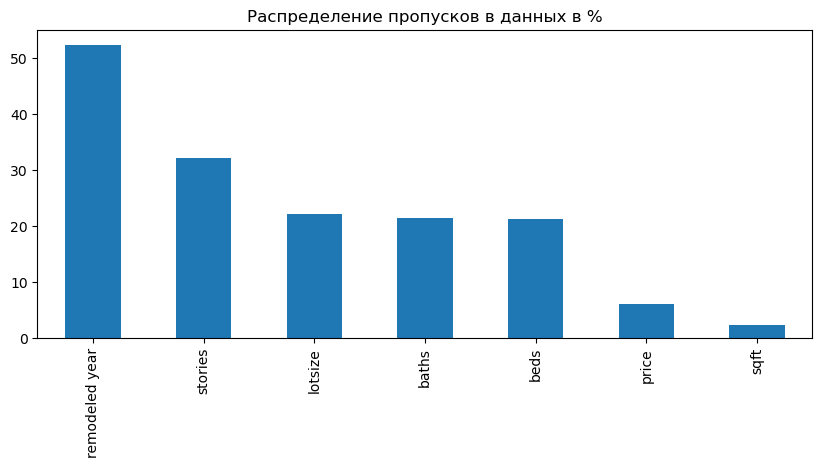

In [38]:
# Строим столбчатую диаграмму для отображения пропусков
cols_with_null.plot(
    kind='bar',
    figsize=(10, 4),
    title='Распределение пропусков в данных в %'
)

Заполняем пропуски в данных медианными значениями:

In [39]:
# Создаем словарь, где ключ — имя столбца, 
# а значение — медианное значение столбца
# для замены пропущенных данных
values = {
    'baths': data['baths'].mode(),
    'sqft': data['sqft'].mode(),
    'beds': data['beds'].mode(),
    'age_building': data['age_building'].mode()
}

# Заполняем пропущенные значения в DataFrame 
data = data.fillna(values)

In [40]:
print(f'Размер датафрейма: {data.shape}')

Размер датафрейма: (311416, 20)


Удаляем столбцы с более чем 30% пропусков и строки, содержащие хотя бы один пропуск.

In [41]:
# Задаем минимальный порог: 70% от общего числа строк
threshold = data.shape[0] * 0.7

# Удаляем столбцы, где более 30% значений имеют пропуски
data = data.dropna(thresh=threshold, axis=1)

# Удаляем строки, содержащие хотя бы один пропуск
data = data.dropna(how='any')

# Выводим размер датафрейма после обработки
print(f'Размер датафрейма: {data.shape}')

Размер датафрейма: (174581, 18)


# 3. Статистический анализ данных


Произведем исследование логарифмированных распределений на наличие выбросов с помощью метода z-отклонений.

Построим график распределения целевой переменной и признака, отвечающего за площадь объекта в обычном и логарифмическом масштабе.

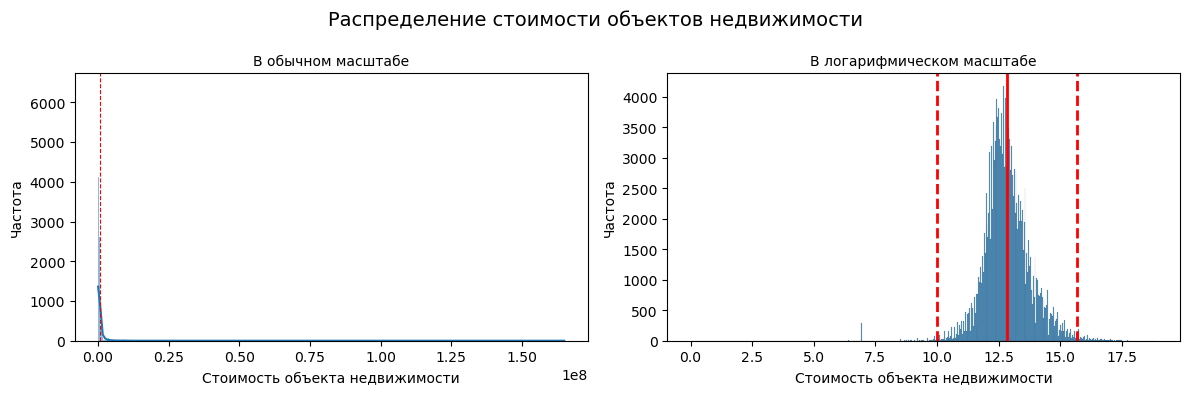

In [42]:
# Создаем фигуру и оси для двух графиков
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Строим гистограмму распределения стоимости объектов недвижимости
sns.histplot(data['target'], kde=True, ax=axes[0])
axes[0].set(xlabel='Стоимость объекта недвижимости', ylabel='Частота')
axes[0].set_title('В обычном масштабе', fontsize=10)

# Добавляем вертикальную линию для среднего значения
axes[0].axvline(
    data['target'].mean(), color='red', linestyle='--', linewidth=0.8
)

# Преобразуем данные в логарифмический масштаб
log_target = np.log(data['target'])

# Строим гистограмму в логарифмическом масштабе
sns.histplot(data=log_target, ax=axes[1])

# Добавляем вертикальные линии для среднего и 3 стандартных отклонений
axes[1].set(xlabel='Стоимость объекта недвижимости', ylabel='Частота')
axes[1].axvline(log_target.mean(), color='red', lw=2)
axes[1].axvline(
    log_target.mean() + 3 * log_target.std(), color='red', ls='--', lw=2
)
axes[1].axvline(
    log_target.mean() - 3 * log_target.std(), color='red', ls='--', lw=2
)

# Добавляем заголовок над вторым графиком
axes[1].set_title('В логарифмическом масштабе', fontsize=10)

# Добавляем общий заголовок по центру между графиками
fig.text(0.5, 0.95, 'Распределение стоимости объектов недвижимости',
         ha='center', va='center', fontsize=14)

# Отображаем графики
plt.tight_layout(rect=[0, 0, 1, 0.9])  # Оставляем место для заголовка
plt.show()

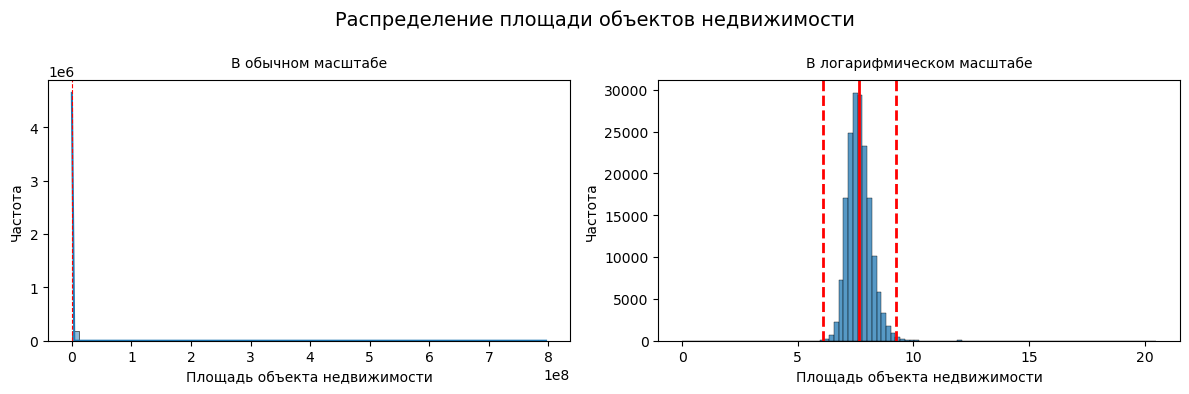

In [43]:
# Создаем фигуру и оси для двух графиков
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Строим гистограмму распределения площади объектов недвижимости
sns.histplot(data['sqft'], bins=70, kde=True, ax=axes[0])
axes[0].set(xlabel='Площадь объекта недвижимости', ylabel='Частота')

# Добавляем вертикальную линию для среднего значения
axes[0].axvline(
    data['sqft'].mean(), color='red', linestyle='--', linewidth=0.8
)

# Добавляем текст "В обычном масштабе" над первым графиком
axes[0].text(0.5, 1.05, 'В обычном масштабе',
             transform=axes[0].transAxes, ha='center', fontsize=10)

# Преобразуем данные в логарифмический масштаб
log_sqft = np.log(data['sqft'])

# Строим гистограмму в логарифмическом масштабе
sns.histplot(data=log_sqft, bins=100, ax=axes[1])

# Добавляем вертикальные линии для среднего и 3 стандартных отклонений
axes[1].set(xlabel='Площадь объекта недвижимости', ylabel='Частота')
axes[1].axvline(log_sqft.mean(), color='red', lw=2)
axes[1].axvline(
    log_sqft.mean() + 3 * log_sqft.std(), color='red', ls='--', lw=2
)
axes[1].axvline(
    log_sqft.mean() - 3 * log_sqft.std(), color='red', ls='--', lw=2
)

# Добавляем текст "В логарифмическом масштабе" над вторым графиком
axes[1].text(0.5, 1.05, 'В логарифмическом масштабе',
             transform=axes[1].transAxes, ha='center', fontsize=10)

# Добавляем общий заголовок по центру между графиками
fig.text(
    0.5, 0.95, 'Распределение площади объектов недвижимости',
    ha='center', va='center', fontsize=14
)

# Отображаем графики
plt.tight_layout(rect=[0, 0, 1, 0.9])  # Оставляем место для заголовка
plt.show()

На основании графиков можно предположить, что целевой признак и признак, отвечающий за площадь объекта, не имеют нормального распределения. 

### Для подтверждения этого визуального вывода проведем тест Шапиро-Уилка.

<p style="font-size: 14px">
* Нулевая гипотеза (<i>H<sub>0</sub></i>): распределение данных является нормальным.
</p>

<p style="font-size: 14px">
* Альтернативная гипотеза (<i>H<sub>1</sub></i>): распределение данных отлично от нормального.
</p>

In [44]:
def decision_normality(p):
    '''Проверка нормальности распределения на основе p-значения.'''
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        # Если p меньше alpha, распределение не является нормальным
        print(
            'p-значение меньше уровня значимости {:.2f}. '
            'Распределение отлично от нормального.'.format(alpha)
        )
    else:
        # Если p больше alpha, распределение является нормальным
        print(
            'p-значение больше уровня значимости {:.2f}. '
            'Распределение является нормальным.'.format(alpha)
        )

        
# Функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    '''Проверка нулевой гипотезы на основе p-значения.'''
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        # Если p меньше alpha, отвергаем нулевую гипотезу
        print(
            'p-значение меньше уровня значимости {:.2f}. '
            'Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha)
        )
    else:
        # Если p больше alpha, нет оснований отвергнуть гипотезу
        print(
            'p-значение больше уровня значимости {:.2f}. '
            'Нет оснований отвергнуть нулевую гипотезу.'.format(alpha)
        )

        
# Целевой признак и признак площади
target = data['target']
sqft = data['sqft']

# Задаём уровень значимости
alpha = 0.05
print("Уровень значимости alpha = {:.2f}".format(alpha))

# Проводим тест Шапиро-Уилка для целевого признака
print('Целевой признак:')
result_target = stats.shapiro(target)
decision_normality(result_target.pvalue)

# Проводим тест Шапиро-Уилка для признака площади
print("Признак 'sqft':")
result_sqft = stats.shapiro(sqft)
decision_normality(result_sqft.pvalue)

Уровень значимости alpha = 0.05
Целевой признак:
p-value = 0.000
p-значение меньше уровня значимости 0.05. Распределение отлично от нормального.
Признак 'sqft':
p-value = 0.000
p-значение меньше уровня значимости 0.05. Распределение отлично от нормального.


Распределение данных отличается от нормального, поэтому для удаления выбросов целесообразно использовать метод квартилей вместо метода трех сигм. Метод трех сигм предполагает симметричное распределение данных, что делает его менее подходящим для анализа распределений с асимметрией или длинными хвостами. Метод квартилей, в свою очередь, основан на расчете межквартильного размаха (IQR) и является более универсальным подходом, так как не требует предположения о нормальности данных.

Для приведения данных к более нормальному виду можно использовать методы преобразования, такие как логарифмическое преобразование, преобразование Бокса-Кокса или Йо-Джонсона. Это может улучшить работу моделей, чувствительных к распределению данных.

### Проверим гипотезу о том, что стоимость недвижимости с камином больше, чем стоимость недвижимости без него.


**Сформулируем нулевую и альтернативные гипотезы:**

<p><strong>* Нулевая гипотеза (H<sub>0</sub>):</strong> стоимость дома с камином (<i>&mu;<sub>1</sub></i>) статистически меньше либо равна стоимости дома без камина (<i>&mu;<sub>2</sub></i>).</p>

<p style="text-align: center;">
    <math>
        H<sub>0</sub>: &mu;<sub>1</sub> &leq; &mu;<sub>2</sub>
    </math>
</p>

<p><strong>* Альтернативная гипотеза (H<sub>1</sub>):</strong> стоимость дома с камином (<i>&mu;<sub>1</sub></i>) статистически больше, чем стоимость дома без камина (<i>&mu;<sub>2</sub></i>).</p>

<p style="text-align: center;">
    <math>
        H<sub>1</sub>: &mu;<sub>1</sub> &gt; &mu;<sub>2</sub>
    </math>
</p>

In [45]:
# Фильтрация данных по наличию камина
target_fireplace = data.loc[data['fireplace'] == 1, 'target']
target_nofireplace = data.loc[data['fireplace'] == 0, 'target']

# Проверка нормальности распределения с помощью теста Шапиро-Уилка
print('С камином:')
result = stats.shapiro(target_fireplace)
decision_normality(result[1])

print('Без камина:')
result = stats.shapiro(target_nofireplace)
decision_normality(result[1])

С камином:
p-value = 0.000
p-значение меньше уровня значимости 0.05. Распределение отлично от нормального.
Без камина:
p-value = 0.000
p-значение меньше уровня значимости 0.05. Распределение отлично от нормального.


Выбираем подходящий статистический тест

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:

* Какой тип у признака «target»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Чтобы проверить нашу гипотезу, можно использовать U-критерий Манна — Уитни для сравнения распределений на основе рангов.

In [46]:
# Проводим тест Манна-Уитни
_, p_value = stats.mannwhitneyu(
    target_fireplace, target_nofireplace, alternative='greater'
)
decision_hypothesis(p_value)

p-value = 0.000
p-значение меньше уровня значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Стоимость дома с камином больше, чем дома без камина

Что ожидаемо, так как камин добавляет престиж, уют, эстетическую привлекательность и функциональность, а также воспринимается как элемент роскоши, способный повысить рыночную стоимость недвижимости.

### Проверим гипотезу о том, что стоимость недвижимости с бассейном, чем стоимость недвижимости без него.

**Сформулируем нулевую и альтернативные гипотезы:**

<p><strong>Нулевая гипотеза (H<sub>0</sub>)</strong>: стоимость дома с бассейном (&#956;<sub>1</sub>) статистически меньше либо равна стоимости дома без бассейна (&#956;<sub>2</sub>).</p>

<p style="text-align: center;">
    H<sub>0</sub>: &#956;<sub>1</sub> &le; &#956;<sub>2</sub>
</p>

<p><strong>Альтернативная гипотеза (H<sub>1</sub>)</strong>: стоимость дома с бассейном (&#956;<sub>1</sub>) статистически больше, чем стоимость дома без бассейна (&#956;<sub>2</sub>).</p>

<p style="text-align: center;">
    H<sub>1</sub>: &#956;<sub>1</sub> &gt; &#956;<sub>2</sub>
</p>
</p>

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

* Нулевая гипотеза (H<sub>0</sub>): распределение данных является нормальным.

* Альтернативная гипотеза (H<sub>1</sub>): распределение данных отлично от нормального.

In [47]:
# Выделение целевой переменной для объектов с бассейном и без
target_pool = data.loc[data['Pool'] == 1, 'target']
target_nopool = data.loc[data['Pool'] == 0, 'target']

# Тест Шапиро-Уилка для проверки нормальности распределения
print('С бассейном:')
result = stats.shapiro(target_pool)
decision_normality(result[1])

print('Без бассейна:')
result = stats.shapiro(target_nopool)
decision_normality(result[1])

С бассейном:
p-value = 0.000
p-значение меньше уровня значимости 0.05. Распределение отлично от нормального.
Без бассейна:
p-value = 0.000
p-значение меньше уровня значимости 0.05. Распределение отлично от нормального.


Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:

* Какой тип у признака «target»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Чтобы проверить нашу гипотезу, можно использовать U-критерий Манна — Уитни для сравнения распределений на основе рангов.

In [48]:
# Проводим тест Манна-Уитни
_, p_value = stats.mannwhitneyu(
    target_pool, target_nopool, alternative='greater'
)
decision_hypothesis(p_value)

p-value = 0.000
p-значение меньше уровня значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Стоимость дома с бассейном больше, чем дома без бассейна.

Что ожидаемо, так как бассейн повышает престиж, комфорт, функциональность и рыночную привлекательность недвижимости, одновременно предоставляя возможности для отдыха и улучшения качества жизни.

# 4. Обнаружение и удаление выбросов

Удалим все выбросы для признаков **target** и **sqft** с помощью метода 3-х сигм:

In [49]:
# Сохраняем копию датафрейма, чтобы построить графики
data_old = data.copy()


def outliers_z_score_mod(data, feature, log_scale=False, left=3, right=3):
    """Удаляет выбросы из данных на основе модифицированного Z-скоринга."""
    # Применяем логарифмирование к признаку, если указано
    if log_scale:
        x = np.log(data[feature] + 1)
    else:
        x = data[feature]

    # Вычисляем среднее значение и стандартное отклонение
    mu = x.mean()
    sigma = x.std()

    # Определяем границы для удаления выбросов
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma

    # Фильтруем данные в пределах заданных границ
    data = data[(x > lower_bound) & (x < upper_bound)]

    return data


# Применяем функцию для удаления выбросов по заданным признакам
data = outliers_z_score_mod(data, 'target', log_scale=True)
data = outliers_z_score_mod(data, 'sqft', log_scale=True)

# Выводим количество оставшихся записей
print(f'Результирующее число записей: {data.shape[0]}')

Результирующее число записей: 171512


Теперь должно наблюдаться более реалистичное и корректное представление цен.

Установлено экспериментально, что метод 3-х сигм с текущими данными показывает значительно лучшие результаты по сравнению с очисткой от выбросов с применением квартильных расстояний.

**Удаление выбросов позволяет:**
* Улучшить распределение данных, делая его более нормальным или ожидаемым, что облегчает анализ и моделирование.
* Сделать графики и диаграммы более информативными и отражающими реальную картину рынка недвижимости.
* Повысить точность аналитических моделей, которые используют очищенные данные для прогнозирования или оценки стоимости.

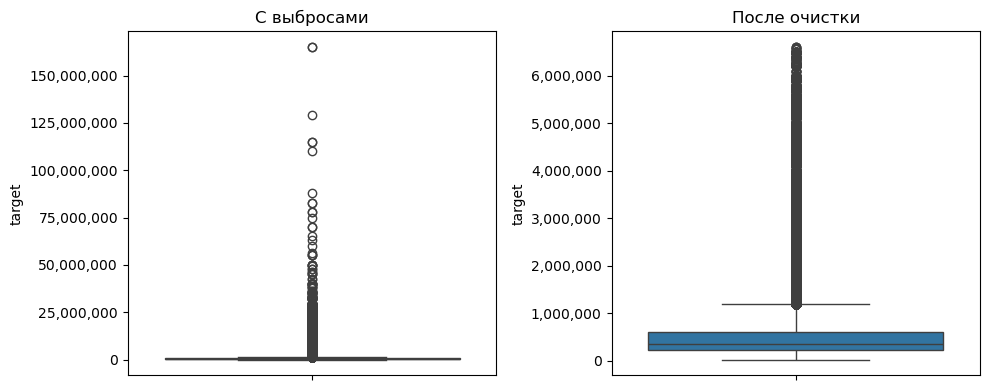

In [50]:
# Форматирование оси Y
def format_yaxis(value, _):
    return f'{value:,.0f}'

# Создание графиков
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# График с выбросами
sns.boxplot(data=data_old['target'], ax=axes[0])
axes[0].set_title('С выбросами')
axes[0].yaxis.set_major_formatter(FuncFormatter(format_yaxis))

# График после удаления выбросов
sns.boxplot(data=data['target'], ax=axes[1])
axes[1].set_title('После очистки')
axes[1].yaxis.set_major_formatter(FuncFormatter(format_yaxis))

# Отображение графика
plt.tight_layout()
plt.show()

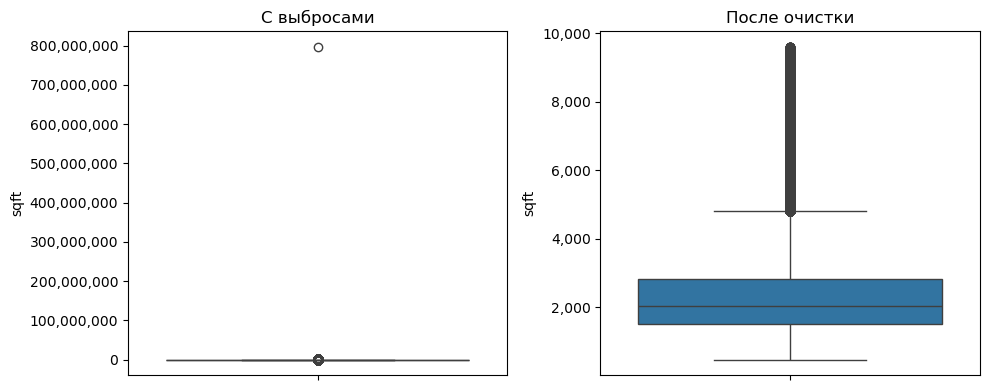

In [51]:
# Форматирование оси Y
def format_yaxis(value, _):
    return f'{value:,.0f}'

# Создание графиков
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# График с выбросами
sns.boxplot(data=data_old['sqft'], ax=axes[0])
axes[0].set_title('С выбросами')
axes[0].yaxis.set_major_formatter(FuncFormatter(format_yaxis))

# График после удаления выбросов
sns.boxplot(data=data['sqft'], ax=axes[1])
axes[1].set_title('После очистки')
axes[1].yaxis.set_major_formatter(FuncFormatter(format_yaxis))

# Отображение графика
plt.tight_layout()
plt.show()

### Выводы:

**До удаления выбросов (левые графики):**

* Целевая переменная имеет значительное количество экстремально высоких значений, которые сильно отличаются от основной массы данных.
* Наличие таких выбросов может исказить статистические показатели, такие как среднее значение, и повлиять на качество моделей машинного обучения.

**После удаления выбросов (правые графики):**

* Распределение стало более компактным, и выбросы были удалены.
* Основная масса данных теперь находится в пределах разумного диапазона, что улучшает интерпретируемость данных и уменьшает влияние экстремальных значений.


Получаем такой датасет

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 171512 entries, 1 to 377184
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   status                171512 non-null  object 
 1   propertyType          171512 non-null  object 
 2   baths                 171512 non-null  float64
 3   fireplace             171512 non-null  int64  
 4   sqft                  171512 non-null  float64
 5   beds                  171512 non-null  float64
 6   state                 171512 non-null  object 
 7   target                171512 non-null  float64
 8   heating               171512 non-null  int64  
 9   cooling               171512 non-null  int64  
 10  parking               171512 non-null  int64  
 11  lotsize               171512 non-null  float64
 12  price                 171512 non-null  float64
 13  school_count          171512 non-null  int32  
 14  schools_rating_ave    171512 non-null  float64
 15  schoo

# 5. Визуализация данных

### 1. Количество объектов по типам недвижимости и статусу объявлений

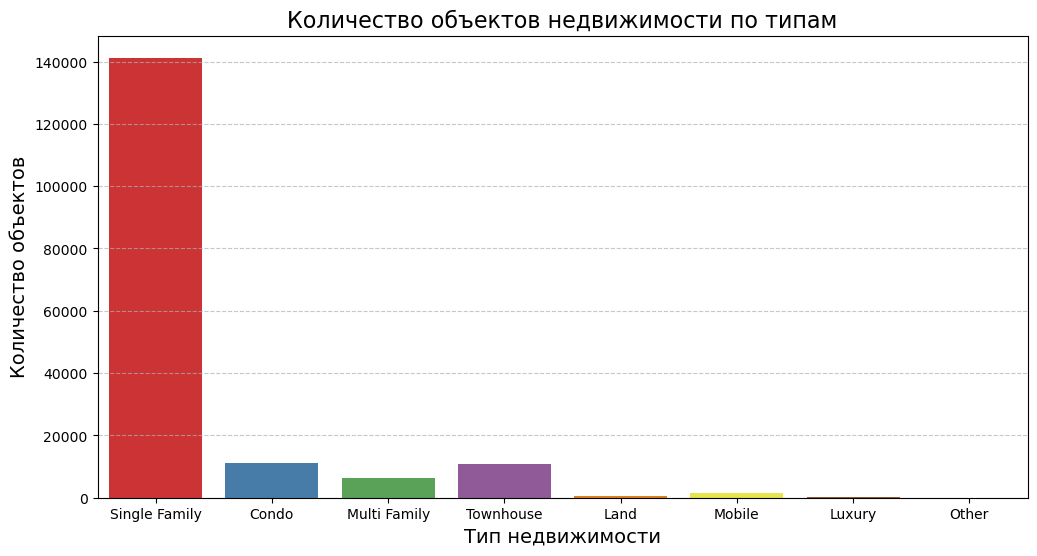

In [53]:
fig = plt.figure(figsize=(12, 6))
ax = sns.countplot(data=data, x='propertyType', palette='Set1')

# Настройка заголовков и подписей
ax.set_title('Количество объектов недвижимости по типам', fontsize=16)
ax.set_xlabel('Тип недвижимости', fontsize=14)
ax.set_ylabel('Количество объектов', fontsize=14)

# Добавление сетки для улучшения читаемости
ax.grid(axis='y', linestyle='--', alpha=0.7)  # Сетка по оси Y

plt.show()

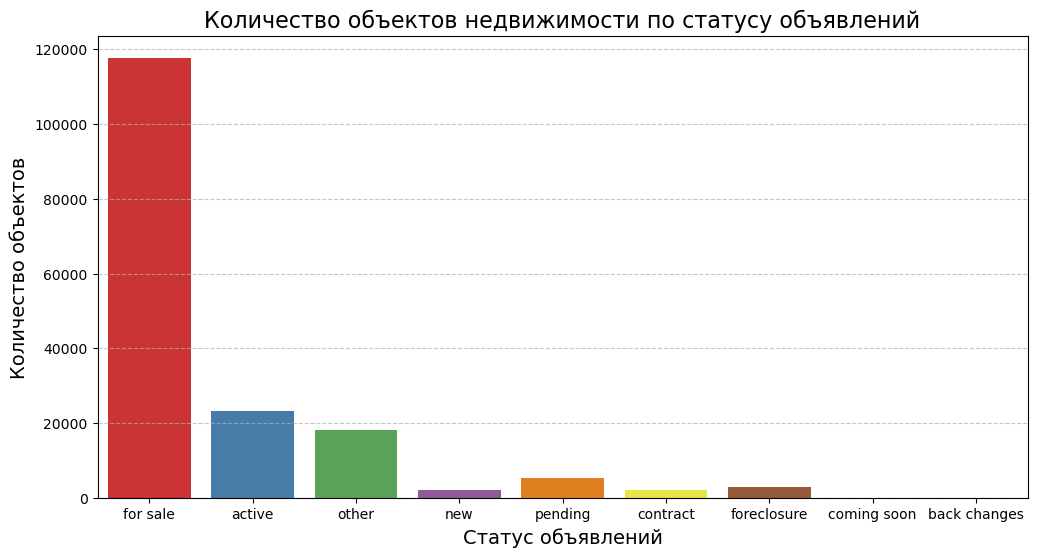

In [54]:
fig = plt.figure(figsize=(12, 6))
ax = sns.countplot(data=data, x='status', color='steelblue', palette='Set1')

# Настройка заголовков и подписей
ax.set_title(
    'Количество объектов недвижимости по статусу объявлений', fontsize=16)
ax.set_xlabel('Статус объявлений', fontsize=14)
ax.set_ylabel('Количество объектов', fontsize=14)

# Добавление сетки для улучшения читаемости
ax.grid(axis='y', linestyle='--', alpha=0.7)  # Сетка по оси Y

plt.show()

График статусов объявлений показывает значительный дисбаланс между классами: статус **for sale** доминирует (120 000 объектов), тогда как другие статусы, такие как **new**, **pending**, и **coming soon**, имеют значительно меньше данных.

График типов недвижимости также демонстрирует дисбаланс: односемейные дома (**Single Family**) составляют подавляющее большинство данных (140 000 объектов), а категории, такие как **Luxury**, **Mobile**, и **Land**, представлены минимально.

### 2. Средняя цена объектов по типам недвижимости и статусу объявлений

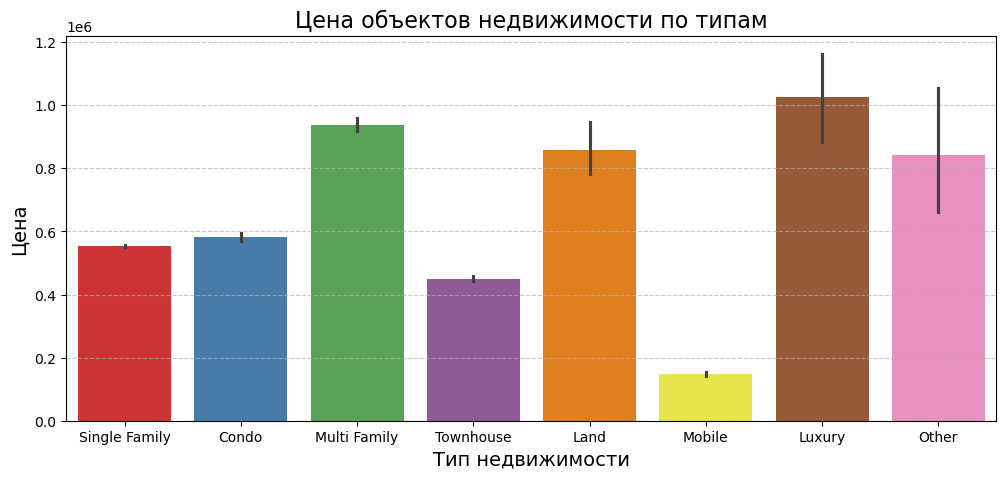

In [55]:
fig, axes = plt.subplots(figsize=(12, 5))
barplot1 = sns.barplot(data=data, x='propertyType',
                       y='target', orient='v', ax=axes, palette='Set1')

# Настройка подписей и заголовков
barplot1.tick_params(axis='x', rotation=0)
barplot1.set_title('Цена объектов недвижимости по типам', fontsize=16)
barplot1.set_xlabel('Тип недвижимости', fontsize=14)
barplot1.set_ylabel('Цена', fontsize=14)

# Добавление сетки для улучшения читаемости
barplot1.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

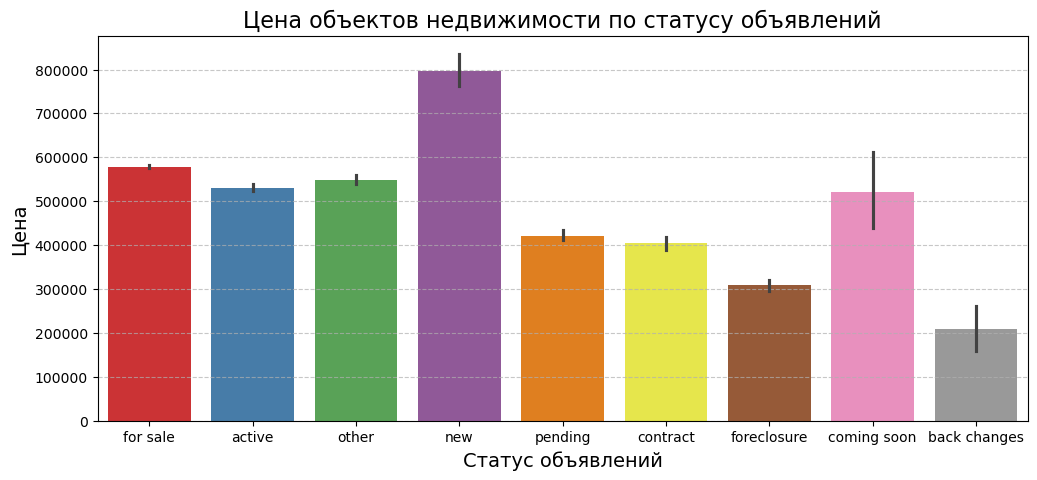

In [56]:
fig, axes = plt.subplots(figsize=(12, 5))
barplot1 = sns.barplot(data=data, x='status',
                       y='target', orient='v', ax=axes, palette='Set1')

# Настройка подписей и заголовков
barplot1.tick_params(axis='x', rotation=0)
barplot1.set_title('Цена объектов недвижимости по статусу объявлений', fontsize=16)
barplot1.set_xlabel('Статус объявлений', fontsize=14)
barplot1.set_ylabel('Цена', fontsize=14)

# Добавление сетки для улучшения читаемости
barplot1.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

* Типы недвижимости

Объекты типа **Luxury** и **Multi Family** имеют самую высокую среднюю цену. Самая низкая средняя цена у объектов типа **Mobile**. Остальные типы недвижимости (**Single Family**, **Townhouse**, **Other**, **Condo**, **Land**) имеют близкие значения средней цены.

* Статусы объявлений

Объекты со статусами **new** и **coming soon** имеют самые высокие средние цены. Самая низкая средняя цена у объектов со статусом **foreclosure**. Статусы **for sale**, **active**, **other**, **pending**, **contract**, **back changes** имеют схожие средние цены.

### 3. Построим график, показывающий наличие камина в доме по типам недвижимости.


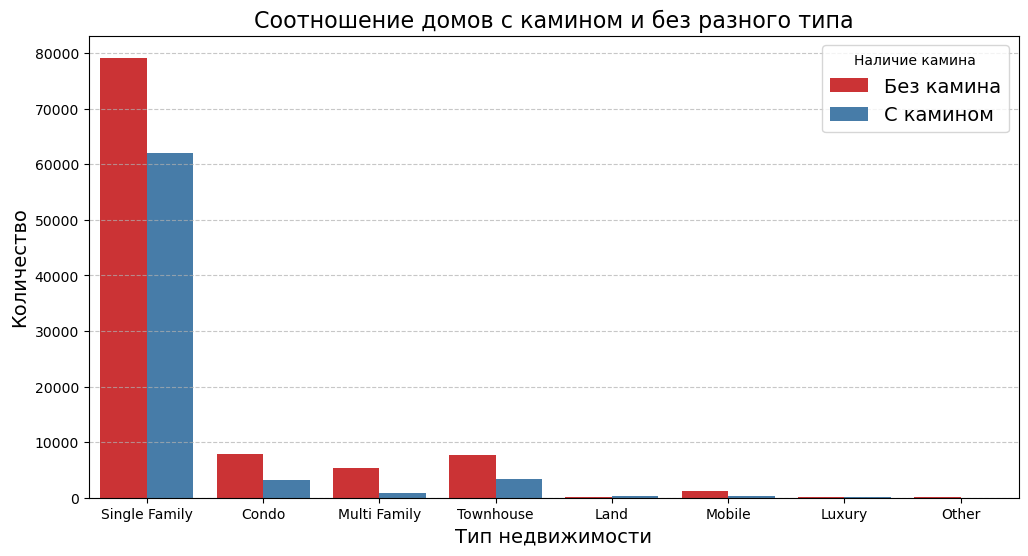

In [57]:
fig = plt.figure(figsize=(12, 6))
ax = sns.countplot(data=data, x='propertyType',
                   hue='fireplace', palette='Set1')

# Настройка подписей и заголовков
ax.set_title('Соотношение домов с камином и без разного типа', fontsize=16)
ax.set_xlabel('Тип недвижимости', fontsize=14)
ax.set_ylabel('Количество', fontsize=14)

# Настройка легенды
ax.legend(['Без камина', 'С камином'], title='Наличие камина', fontsize=14)

# Добавление сетки для улучшения читаемости
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Камины чаще встречаются в односемейных домах. В других типах недвижимости, таких как **Townhouse**, **Condo**, **Multi Family**, доля домов с каминами значительно ниже, чем в **Single Family**. Это может быть связано с тем, что камины чаще устанавливаются в более просторных и индивидуальных домах. В типах недвижимости **Mobile** и **Land** камины практически отсутствуют, что логично, так как эти категории либо не предполагают жилых построек, либо имеют ограниченные возможности для установки каминов. В категории **Luxury** количество домов с каминами также невелико, что может быть связано с малым количеством объектов в этой категории. В категориях **Other**, **Condo** и **Multi Family** заметно больше домов без каминов, чем с ними. 

### 4. Наличие бассейна в доме по типам недвижимости

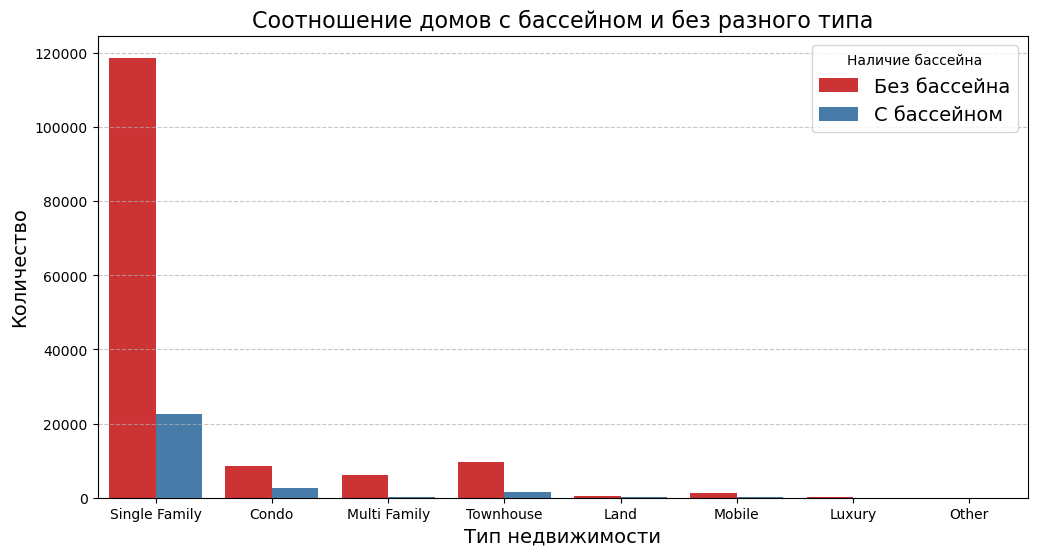

In [58]:
fig = plt.figure(figsize=(12, 6))
ax = sns.countplot(data=data, x='propertyType',
                   hue='Pool', palette='Set1')

# Настройка подписей и заголовков
ax.set_title('Соотношение домов с бассейном и без разного типа', fontsize=16)
ax.set_xlabel('Тип недвижимости', fontsize=14)
ax.set_ylabel('Количество', fontsize=14)

# Настройка легенды
ax.legend(['Без бассейна', 'С бассейном'],
          title='Наличие бассейна', fontsize=14)

# Добавление сетки для улучшения читаемости
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Среди всех типов недвижимости дома с бассейнами чаще всего представлены в категории **Single Family**. Это логично, так как такие дома обычно имеют больше пространства для размещения бассейна. В категориях **Townhouse**, "Condo", **Multi Family**, **Land**, **Mobile** и **Luxury** количество объектов с бассейнами значительно меньше по сравнению с объектами без бассейнов. 

### 5. Цена объектов по типам недвижимости и статусу объявлений

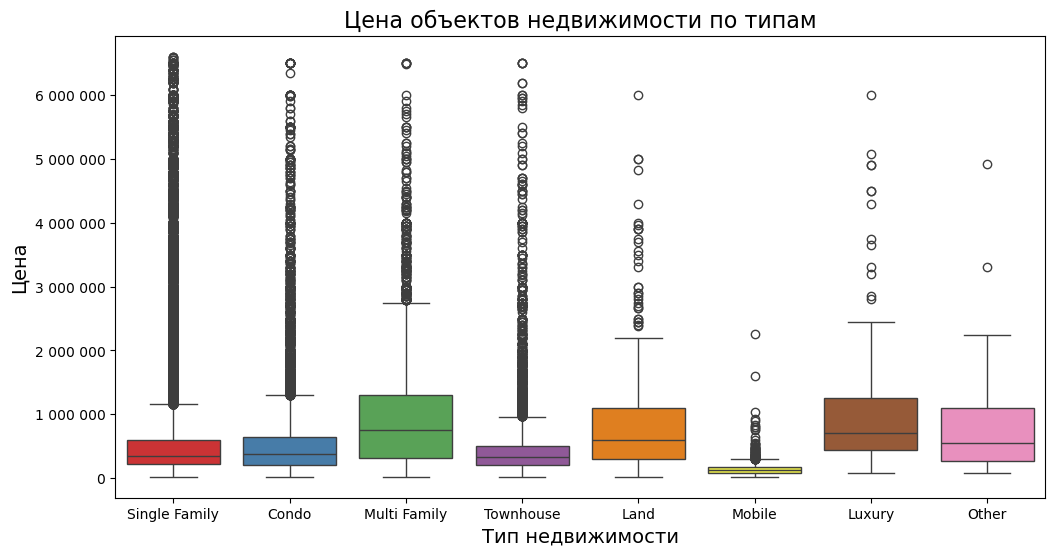

In [59]:
fig = plt.figure(figsize=(12, 6))
ax = sns.boxplot(data=data, x='propertyType', y='target', palette='Set1')

# Форматирование оси Y для отображения чисел в привычном формате
ax.yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', ' '))
)

# Настройка заголовков и подписей
ax.set_title('Цена объектов недвижимости по типам', fontsize=16)
ax.set_xlabel('Тип недвижимости', fontsize=14)
ax.set_ylabel('Цена', fontsize=14)

plt.show()

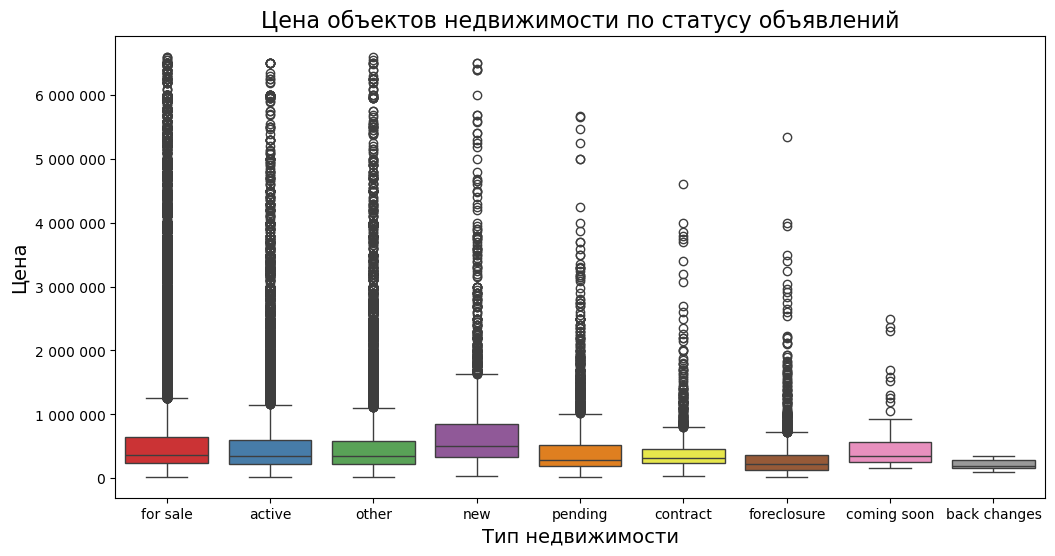

In [60]:
fig = plt.figure(figsize=(12, 6))
ax = sns.boxplot(data=data, x='status', y='target', palette='Set1')

# Форматирование оси Y для отображения чисел в привычном формате
ax.yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', ' '))
)

# Настройка заголовков и подписей
ax.set_title('Цена объектов недвижимости по статусу объявлений', fontsize=16)
ax.set_xlabel('Тип недвижимости', fontsize=14)
ax.set_ylabel('Цена', fontsize=14)

plt.show()

Анализ графиков показывает, что самые дорогие объекты относятся к категории **Multi Family**, в то время как **Mobile** и **Land** представляют самый бюджетный сегмент рынка. По статусу объявлений наиболее высокие цены наблюдаются в категории **new**, а самые низкие - в категориях **Foreclosure** и **Back changes**. Большой разброс цен в категории Multi Family указывает на значительную вариативность характеристик объектов. 

Медианная стоимость у всех объектов недвижимости находится почти на одном уровне, но наблюдается довольно сильный разброс значений.



# 6. Корреляционный анализ признаков

Построим матрицу корреляции для числовых и бинарных признаков, а также ее тепловую карту.

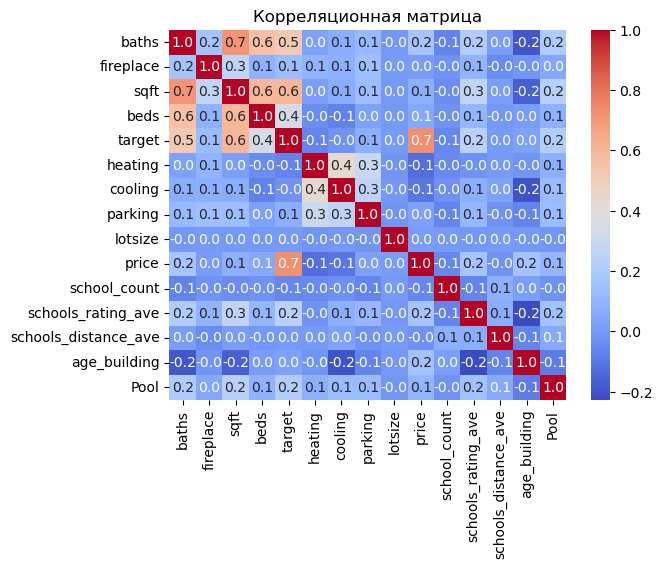

                   index    target
4                 target  1.000000
9                  price  0.726495
2                   sqft  0.600218
0                  baths  0.520486
3                   beds  0.351348
11    schools_rating_ave  0.243121
14                  Pool  0.219032
1              fireplace  0.132301
7                parking  0.081207
13          age_building  0.028450
8                lotsize  0.005388
12  schools_distance_ave  0.005362
6                cooling -0.017847
10          school_count -0.054955
5                heating -0.066610


In [61]:
# Определение категориальных признаков
categorical_columns = data.select_dtypes(include=['object', 'category']).columns

# Исключение категориальных признаков из анализа
numerical_data = data.drop(columns=categorical_columns)

# Вычисление корреляции
corr = numerical_data.corr()

# Построение тепловой карты
sns.heatmap(corr, annot=True, fmt=".1f", cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

# Анализ корреляции с целевой переменной
new_corr = corr['target'].reset_index()
sort_corr = new_corr.sort_values('target', ascending=False)
print(sort_corr)

Переменная **target** имеет слабую корреляцию с другими признаками. Самая высокая корреляция наблюдается с **sqft**, что указывает на то, что площадь может быть важным фактором для целевой переменной.

# 7. Создание и сравнение моделей ML


Кодируем категориальные признаки OneHot кодированием:

In [62]:
# Столбцы для кодирования
columns_to_change = ['propertyType', 'state', 'status']

# Создаем OneHotEncoder, исключая первую категорию
encoder = pp.OneHotEncoder(drop='first')

# Кодируем указанные столбцы и преобразуем в массив
data_onehot = encoder.fit_transform(data[columns_to_change]).toarray()

# Получаем имена новых столбцов
column_names = encoder.get_feature_names_out()

# Создаем DataFrame из закодированных данных
data_onehot = pd.DataFrame(data_onehot, columns=column_names)

# Объединяем исходные данные с закодированными столбцами
data = pd.concat(
    [data.reset_index(drop=True).drop(columns_to_change, axis=1), data_onehot],
    axis=1
)

In [63]:
data.head(3)

,baths,fireplace,sqft,beds,target,heating,cooling,parking,lotsize,price,...,state_WA,state_WI,status_back changes,status_coming soon,status_contract,status_for sale,status_foreclosure,status_new,status_other,status_pending
0,3.0,0,1947.0,3.0,310000.0,0,0,0,5828.0,159.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2.0,1,3000.0,3.0,2895000.0,1,1,1,8626.0,965.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,8.0,1,6457.0,5.0,2395000.0,1,1,1,8220.0,371.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171512 entries, 0 to 171511
Data columns (total 62 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   baths                       171512 non-null  float64
 1   fireplace                   171512 non-null  int64  
 2   sqft                        171512 non-null  float64
 3   beds                        171512 non-null  float64
 4   target                      171512 non-null  float64
 5   heating                     171512 non-null  int64  
 6   cooling                     171512 non-null  int64  
 7   parking                     171512 non-null  int64  
 8   lotsize                     171512 non-null  float64
 9   price                       171512 non-null  float64
 10  school_count                171512 non-null  int32  
 11  schools_rating_ave          171512 non-null  float64
 12  schools_distance_ave        171512 non-null  float64
 13  age_building  

Разделим набор данных на матрицу наблюдений X (таблица из объектов и их признаков) и столбец правильных ответов y:

In [64]:
X = data.drop(['target'], axis=1)
y = data['target']

Разделяем всю выборку на тренировочную и тестовую в соотношении 70/30.

На тренировочной выборке будем обучать модели, а на тестовой проверять их качество.

In [65]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.3)

Предварительно нормализуем данные:

In [66]:
# Создаем объект RobustScaler для масштабирования данных
scaler = preprocessing.RobustScaler()

# Вычисляем параметры масштабирования на обучающих данных
scaler.fit(X_train)

# Преобразуем обучающие данные с использованием RobustScaler
X_train_scaled = scaler.transform(X_train)

# Преобразуем тестовые данные с использованием тех же параметров
X_test_scaled = scaler.transform(X_test)

Цель - построить модель, решающую поставленную задачу и оценить ее качество

Будем оценивать модель с помощью следующих метрик:

* R<sup>2</sup> - коэффициент детерминации
* MAE - средняя абсолютная ошибка (целевая метрика)
* MAPE - средняя абсолютная ошибка в процентах

In [73]:
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    '''
    Функция для вывода метрик качества модели 
    на тренировочном и тестовом наборах данных.
    '''
    print('Train R^2: {:.3f}'.format(
        metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE: {:.3f}'.format(
        metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Train MAPE: {:.3f} %'.format(
        metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.3f}'.format(
        metrics.mean_absolute_error(y_test, y_test_predict)))
    print('Test MAPE: {:.3f} %'.format(
        metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))

## Линейная регрессия (Linear Regression)

In [74]:
# Инициализируем объект класса линейной регрессии
lr = linear_model.LinearRegression()

# Обучаем модель, подбирая параметры
lr.fit(X_train_scaled, y_train)

# Делаем предсказания для обучающей и тестовой выборок
y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)

# Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.824
Train MAE: 141552.468
Train MAPE: 44.031 %
Test R^2: 0.840
Test MAE: 139904.829
Test MAPE: 44.370 %


Попробуем повысить значения метрик.

Поскольку целевой признак не имеет нормального распределения, применим логарифмирование, чтобы привести его к нормальному распределению.

In [75]:
# Создаем логарифмированный целевой признак
y_train_log = np.log(y_train)

# Инициализируем объект класса линейной регрессии
linear_regression = linear_model.LinearRegression()

# Обучаем модель, подбирая параметры
linear_regression.fit(X_train_scaled, y_train_log)

# Делаем предсказание для каждой из выборок
# Так как обучали модель на логарифмах, 
# необходимо проэкспонировать предсказания
y_train_pred = np.exp(linear_regression.predict(X_train_scaled))
y_test_pred = np.exp(linear_regression.predict(X_test_scaled))

# Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: -7929193300826849280.000
Train MAE: 5455759324575.765
Train MAPE: 83936508.616 %
Test R^2: -1967.927
Test MAE: 436498.310
Test MAPE: 31.687 %


## Дерево решений (Decision Tree)

In [76]:
# Инициализируем модель дерева решений с максимальной глубиной 5
dt = tree.DecisionTreeRegressor(
    max_depth=5,
    criterion='squared_error',
    random_state=42
)

# Обучаем модель
dt.fit(X_train_scaled, y_train_log)

# Делаем предсказание для каждой из выборок
# Так как обучали на логарифме, необходимо проэкспонировать
y_train_pred = np.exp(dt.predict(X_train_scaled))
y_test_pred = np.exp(dt.predict(X_test_scaled))

# Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.892
Train MAE: 96131.528
Train MAPE: 16.018 %
Test R^2: 0.892
Test MAE: 96295.883
Test MAPE: 16.077 %


## Случайный лес (Random Forest)

In [77]:
# Модель случайного леса из 10 деревьев с максимальной глубиной 10
rf = ensemble.RandomForestRegressor(
    max_depth=10, n_estimators=10, random_state=42)

# Обучаем модель
rf.fit(X_train_scaled, y_train_log)

# Делаем предсказание для каждой из выборок
# Так как обучали на логарифме, необходимо проэкспонировать
y_train_pred = np.exp(rf.predict(X_train_scaled))
y_test_pred = np.exp(rf.predict(X_test_scaled))

# Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.999
Train MAE: 7773.515
Train MAPE: 1.254 %
Test R^2: 0.998
Test MAE: 8591.006
Test MAPE: 1.343 %


Сделаем подбор оптимальных параметров с помощью **RandomizeSearch**:

In [78]:
# Определяем распределение гиперпараметров
param_distributions = {
    'n_estimators': list(range(10, 50, 5)),
    'min_samples_leaf': list(range(1, 10)),
    'max_depth': list(np.linspace(10, 40, 10, dtype=int))
}

# Настраиваем RandomizedSearchCV
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestRegressor(random_state=42),
    param_distributions=param_distributions,
    cv=5,
    n_iter=10,
    n_jobs=-1
)

# Обучаем модель
%time random_search_forest.fit(X_train_scaled, y_train_log)

# Делаем предсказания
y_train_pred = np.exp(random_search_forest.predict(X_train_scaled))
y_test_pred = np.exp(random_search_forest.predict(X_test_scaled))

# Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)
print("Наилучшие значения гиперпараметров: {}".format(
    random_search_forest.best_params_))

CPU times: total: 7.56 s
Wall time: 3min 9s
Train R^2: 1.000
Train MAE: 1753.669
Train MAPE: 0.254 %
Test R^2: 0.999
Test MAE: 2946.959
Test MAPE: 0.408 %
Наилучшие значения гиперпараметров: {'n_estimators': 35, 'min_samples_leaf': 3, 'max_depth': 33}


Постороим диаграмму значимости признаков:

Text(0, 0.5, 'Признаки')

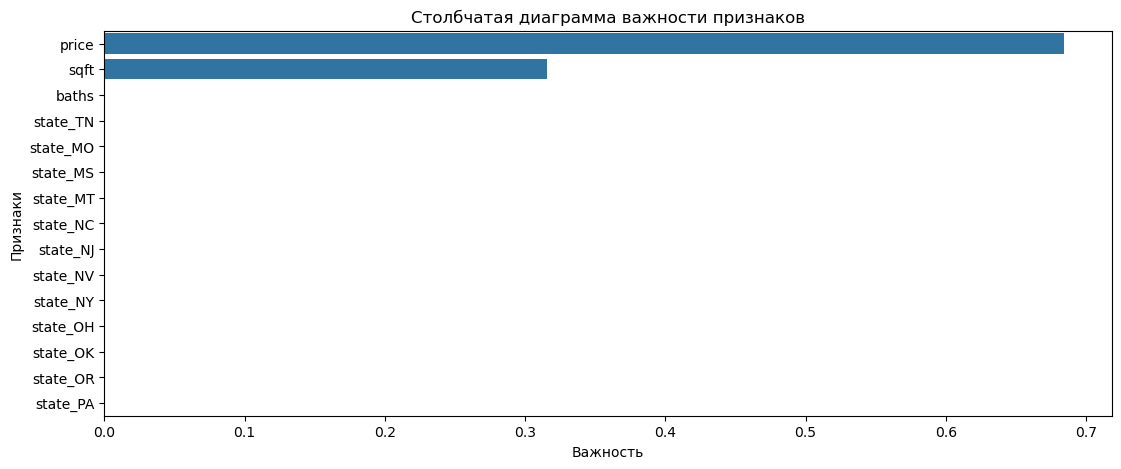

In [83]:
# Создание фигуры и координатной плоскости
fig, ax = plt.subplots(figsize=(13, 5))

# Получение признаков и их важности
features = X.columns
feature_importances = dt.feature_importances_

# Создание DataFrame с информацией о важности признаков
importances_data = pd.DataFrame({
    'features': features,
    'importances': feature_importances
})
importances_data = importances_data.sort_values(
    by='importances', ascending=False)

# Построение столбчатой диаграммы
sns.barplot(
    data=importances_data[0:15],
    y='features',
    x='importances',
    ax=ax
)

# Добавление подписи к графику и поворот меток на оси абсцисс
ax.set_title('Столбчатая диаграмма важности признаков')
ax.set_xlabel('Важность')
ax.set_ylabel('Признаки')

Признак **price** оказывает наибольшее влияние на итоговый результат модели, что может свидетельствовать о наличии утечки данных. Утечка данных возникает, когда информация, недоступная в реальных условиях прогнозирования, используется при обучении модели, что приводит к завышению её точности и снижению качества работы на новых данных. В данном случае высокая важность признака **price** может указывать на то, что он напрямую связан с целевой переменной или содержит информацию, которая не должна быть доступна модели.

Чтобы избежать этой проблемы и обеспечить корректное обучение модели, признак **price** исключаем из набора данных. 

In [84]:
X = data.drop(['price','target'], axis=1)
y = data['target']

Разделяем всю выборку на тренировочную и тестовую в соотношении 70/30:

In [85]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.3)

Нормализуем данные и подбираем парметры с помощью **RandomizeSearch**:

In [86]:
# Масштабирование данных
scaler = preprocessing.RobustScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Определение гиперпараметров для случайного поиска
param_distributions = {
    'n_estimators': list(range(10, 50, 5)),
    'min_samples_leaf': list(range(1, 10, 1)),
    'max_depth': list(np.linspace(10, 40, 10, dtype=int))
}

# Настройка RandomizedSearchCV
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestRegressor(random_state=42),
    param_distributions=param_distributions,
    cv=5,
    n_iter=10,
    n_jobs=-1
)

# Обучение модели
%time random_search_forest.fit(X_train_scaled, y_train_log)

# Делаем предсказание класса
y_train_pred = np.exp(random_search_forest.predict(X_train_scaled))
y_test_pred = np.exp(random_search_forest.predict(X_test_scaled))

# Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)
print("Наилучшие значения гиперпараметров: {}".format(
    random_search_forest.best_params_))

CPU times: total: 8.72 s
Wall time: 5min 19s
Train R^2: 0.904
Train MAE: 80583.006
Train MAPE: 13.635 %
Test R^2: 0.713
Test MAE: 157175.473
Test MAPE: 28.602 %
Наилучшие значения гиперпараметров: {'n_estimators': 30, 'min_samples_leaf': 2, 'max_depth': 30}


Произведем отбор признаков с помощью **KBest**. Отберем 30 признаков.

In [87]:
# Создание объекта SelectKBest
feature_function = SelectKBest(k=30)

# Выбор только числовых столбцов из X_train
X_train = X_train.select_dtypes(include=[np.number])

# Обучение SelectKBest на данных
feature_function.fit(X_train, y_train)

# Получение имен лучших признаков
columns_kbest = feature_function.get_feature_names_out()

# Вывод лучших признаков
print(columns_kbest)

['baths' 'fireplace' 'sqft' 'beds' 'heating' 'cooling' 'parking'
 'schools_rating_ave' 'schools_distance_ave' 'age_building' 'Pool'
 'propertyType_Multi Family' 'state_CA' 'state_CO' 'state_DC' 'state_FL'
 'state_IA' 'state_MI' 'state_NC' 'state_NV' 'state_NY' 'state_OH'
 'state_OR' 'state_SC' 'state_TX' 'state_WA' 'status_for sale'
 'status_foreclosure' 'status_new' 'status_pending']


Выделяем отобранные признаки из общего числа признаков:

In [88]:
X_kbest = data[columns_kbest]
y_kbest = data['target']

Разбиваем выборку на тренировочную и тестовую в соотношении 70/30:

In [89]:
X_train_kbest, X_test_kbest, y_train_kbest, y_test_kbest = train_test_split(
    X_kbest, y_kbest, test_size=0.3, random_state=42)

Проводим нормализацию:

In [90]:
# Создаём объект RobustScaler для масштабирования данных
scaler = preprocessing.RobustScaler()

# Обучаем масштабировщик на тренировочных данных
scaler.fit(X_train_kbest)

# Преобразуем тренировочные данные с использованием масштабировщика
X_train_kbest_scaled = scaler.transform(X_train_kbest)

# Преобразуем тестовые данные с теми же параметрами, что и для train
X_test_kbest_scaled = scaler.transform(X_test_kbest)

Воспользуемся **OPTUNA** для подбора гиперпараметров:

In [91]:
# Создаем логарифмированный целевой признак
y_train_kbest_log = np.log(y_train_kbest)


def optuna_rf(trial):
    # Задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 10, 200, 10)
    max_depth = trial.suggest_int('max_depth', 5, 50, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10, 1)

    # Создаем модель
    model = ensemble.RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    # Обучаем модель
    model.fit(X_train_kbest_scaled, y_train_kbest_log)
    score = metrics.mean_absolute_percentage_error(
        y_train_kbest,
        np.exp(model.predict(X_train_kbest_scaled))
    ) * 100

    return score


# Создаем объект исследования
study = optuna.create_study(
    study_name="RandomForestRegressor", direction='minimize')

# Ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=10)

# Выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров: {}".format(study.best_params))
print("MAPE на обучающем наборе: {:.3f}".format(study.best_value))

# Рассчитаем точность для тестовой выборки
model = ensemble.RandomForestRegressor(
    **study.best_params,
    random_state=42
)
model.fit(X_train_kbest_scaled, y_train_kbest_log)

y_train_kbest_pred = np.exp(model.predict(X_train_kbest_scaled))
y_test_kbest_pred = np.exp(model.predict(X_test_kbest_scaled))

print(
    'MAPE на тестовом наборе: {:.3f}'.format(
        metrics.mean_absolute_percentage_error(
            y_test_kbest, y_test_kbest_pred) * 100
    )
)

[I 2024-12-24 16:27:21,895] A new study created in memory with name: RandomForestRegressor
[I 2024-12-24 16:29:37,699] Trial 0 finished with value: 25.173478316653497 and parameters: {'n_estimators': 140, 'max_depth': 30, 'min_samples_leaf': 9}. Best is trial 0 with value: 25.173478316653497.
[I 2024-12-24 16:33:14,480] Trial 1 finished with value: 14.804505860421429 and parameters: {'n_estimators': 190, 'max_depth': 25, 'min_samples_leaf': 1}. Best is trial 1 with value: 14.804505860421429.
[I 2024-12-24 16:34:40,106] Trial 2 finished with value: 29.939535260847837 and parameters: {'n_estimators': 130, 'max_depth': 15, 'min_samples_leaf': 6}. Best is trial 1 with value: 14.804505860421429.
[I 2024-12-24 16:35:18,704] Trial 3 finished with value: 39.95286939381181 and parameters: {'n_estimators': 100, 'max_depth': 8, 'min_samples_leaf': 4}. Best is trial 1 with value: 14.804505860421429.
[I 2024-12-24 16:36:26,768] Trial 4 finished with value: 22.296900966170906 and parameters: {'n_est

Наилучшие значения гиперпараметров: {'n_estimators': 190, 'max_depth': 25, 'min_samples_leaf': 1}
MAPE на обучающем наборе: 14.805
MAPE на тестовом наборе: 30.631


In [93]:
%%time
# Продолжим подбор еще 10 итераций
study.optimize(optuna_rf, n_trials=10)

[I 2024-12-24 16:54:27,820] Trial 10 finished with value: 18.031406408860907 and parameters: {'n_estimators': 60, 'max_depth': 22, 'min_samples_leaf': 1}. Best is trial 1 with value: 14.804505860421429.
[I 2024-12-24 16:55:20,872] Trial 11 finished with value: 18.049016222817624 and parameters: {'n_estimators': 50, 'max_depth': 22, 'min_samples_leaf': 1}. Best is trial 1 with value: 14.804505860421429.
[I 2024-12-24 16:56:15,651] Trial 12 finished with value: 23.349086233721554 and parameters: {'n_estimators': 60, 'max_depth': 18, 'min_samples_leaf': 1}. Best is trial 1 with value: 14.804505860421429.
[I 2024-12-24 16:58:35,752] Trial 13 finished with value: 16.932450095323855 and parameters: {'n_estimators': 130, 'max_depth': 30, 'min_samples_leaf': 3}. Best is trial 1 with value: 14.804505860421429.
[I 2024-12-24 17:01:04,942] Trial 14 finished with value: 16.659989991247514 and parameters: {'n_estimators': 140, 'max_depth': 32, 'min_samples_leaf': 3}. Best is trial 1 with value: 14.

CPU times: total: 2min 48s
Wall time: 21min 54s


In [94]:
# Выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров: {}".format(study.best_params))
print("MAPE на обучающем наборе: {:.3f}".format(study.best_value))

# Рассчитаем точность для тестовой выборки
model = ensemble.RandomForestRegressor(
    **study.best_params, random_state=42
)
model.fit(X_train_kbest_scaled, y_train_kbest_log)

y_train_kbest_pred = np.exp(model.predict(X_train_kbest_scaled))
y_test_kbest_pred = np.exp(model.predict(X_test_kbest_scaled))

print(
    "MAPE на тестовом наборе: {:.3f}".format(
        metrics.mean_absolute_percentage_error(
            y_test_kbest, y_test_kbest_pred) * 100
    )
)

Наилучшие значения гиперпараметров: {'n_estimators': 190, 'max_depth': 25, 'min_samples_leaf': 1}
MAPE на обучающем наборе: 14.805
MAPE на тестовом наборе: 30.631


Построим график истории оптимизации - он отображает количество испытаний на оси Х и метрику на оси Y. По графику видно, что метрика минимизируется.

In [4]:
optuna.visualization.plot_optimization_history(study, target_name="MAPE")

Постороим график важности гиперпараметров - помогает понять, какие гиперпараметры вносят больший вклад в минимизацию метрики.

In [3]:
optuna.visualization.plot_param_importances(study, target_name="MAPE")

Из графика можно заключить, что следует уделить больше внимания настройке гиперпараметра **max_depth**. Анализ метрик показывает, что их значения оказываются лучше при использовании полного набора данных без отбора признаков.

Проведем подбор гиперпараметров для полного набора признаков с использованием библиотеки **OPTUNA**. Разделим набор данных на матрицу наблюдений X (таблица из объектов и их признаков без учета признака **price**) и столбец правильных ответов y.

In [ ]:
X = data.drop(['price', 'target'], axis=1)
y = data['target']

Делим выборку на обучающую и тестовую в соотношении 70/30

In [97]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.3)

Нормализуем данные:

In [98]:
# Создаем объект RobustScaler для масштабирования данных
scaler = preprocessing.RobustScaler()

# Обучаем масштабировщик на тренировочных данных
scaler.fit(X_train)

# Преобразуем тренировочные данные с использованием масштабировщика
X_train_scaled = scaler.transform(X_train)

# Преобразуем тестовые данные с теми же параметрами, что и для train
X_test_scaled = scaler.transform(X_test)

Подбираем гиперпараметры с помощью **OPTUNA**:

In [99]:
def optuna_rf(trial):
    '''
    Оптимизация гиперпараметров RandomForestRegressor с помощью Optuna.
    '''
    # Задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 10, 200, 10)
    max_depth = trial.suggest_int('max_depth', 5, 50, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10, 1)

    # Создаем модель
    model = ensemble.RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    # Обучаем модель
    model.fit(X_train_scaled, y_train_log)

    # Рассчитываем MAPE на обучающей выборке
    score = metrics.mean_absolute_percentage_error(
        y_train,
        np.exp(model.predict(X_train_scaled))
    ) * 100

    return score


# Создаем объект исследования
study = optuna.create_study(
    study_name="RandomForestRegressor",
    direction='minimize'
)

# Ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=10)

# Выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров: {}".format(study.best_params))
print("MAPE на обучающем наборе: {:.3f}".format(study.best_value))

# Рассчитаем точность для тестовой выборки
model = ensemble.RandomForestRegressor(
    **study.best_params,
    random_state=42
)
model.fit(X_train_scaled, y_train_log)

y_train_pred = np.exp(model.predict(X_train_scaled))
y_test_pred = np.exp(model.predict(X_test_scaled))

print('MAPE на тестовом наборе: {:.3f}'.format(
    metrics.mean_absolute_percentage_error(y_test, y_test_pred) * 100
))

[I 2024-12-24 17:45:40,506] A new study created in memory with name: RandomForestRegressor
[I 2024-12-24 17:47:44,651] Trial 0 finished with value: 27.777341718814903 and parameters: {'n_estimators': 120, 'max_depth': 15, 'min_samples_leaf': 3}. Best is trial 0 with value: 27.777341718814903.
[I 2024-12-24 17:48:12,918] Trial 1 finished with value: 32.07984211179601 and parameters: {'n_estimators': 30, 'max_depth': 13, 'min_samples_leaf': 9}. Best is trial 0 with value: 27.777341718814903.
[I 2024-12-24 17:48:22,914] Trial 2 finished with value: 29.44385909529345 and parameters: {'n_estimators': 10, 'max_depth': 15, 'min_samples_leaf': 6}. Best is trial 0 with value: 27.777341718814903.
[I 2024-12-24 17:52:02,547] Trial 3 finished with value: 23.761598250250334 and parameters: {'n_estimators': 180, 'max_depth': 40, 'min_samples_leaf': 10}. Best is trial 3 with value: 23.761598250250334.
[I 2024-12-24 17:55:03,088] Trial 4 finished with value: 14.632811796236409 and parameters: {'n_esti

Наилучшие значения гиперпараметров: {'n_estimators': 200, 'max_depth': 47, 'min_samples_leaf': 1}
MAPE на обучающем наборе: 9.494
MAPE на тестовом наборе: 27.667


In [100]:
%%time
# Продолжим подбор еще 10 итераций 
study.optimize(optuna_rf, n_trials=10)

[I 2024-12-24 19:06:11,704] Trial 10 finished with value: 9.602020826941049 and parameters: {'n_estimators': 90, 'max_depth': 49, 'min_samples_leaf': 1}. Best is trial 9 with value: 9.494087998128547.
[I 2024-12-24 19:08:41,409] Trial 11 finished with value: 9.594660945218015 and parameters: {'n_estimators': 90, 'max_depth': 50, 'min_samples_leaf': 1}. Best is trial 9 with value: 9.494087998128547.
[I 2024-12-24 19:10:42,918] Trial 12 finished with value: 9.656347410387244 and parameters: {'n_estimators': 70, 'max_depth': 49, 'min_samples_leaf': 1}. Best is trial 9 with value: 9.494087998128547.
[I 2024-12-24 19:12:40,574] Trial 13 finished with value: 16.974129194406007 and parameters: {'n_estimators': 80, 'max_depth': 38, 'min_samples_leaf': 4}. Best is trial 9 with value: 9.494087998128547.
[I 2024-12-24 19:16:19,426] Trial 14 finished with value: 17.496777629707186 and parameters: {'n_estimators': 150, 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 9 with value: 9.494087998

CPU times: total: 2min 43s
Wall time: 27min 9s


In [101]:
# Выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров: {}".format(study.best_params))
print("MAPE на обучающем наборе: {:.3f} %".format(study.best_value))

# Рассчитаем точность для тестовой выборки
model = ensemble.RandomForestRegressor(
    **study.best_params,
    random_state=42
)
model.fit(X_train_scaled, y_train_log)

y_train_pred = np.exp(model.predict(X_train_scaled))
y_test_pred = np.exp(model.predict(X_test_scaled))

print(
    "MAPE на тестовом наборе: {:.3f} %".format(
        metrics.mean_absolute_percentage_error(y_test, y_test_pred) * 100
    )
)

Наилучшие значения гиперпараметров: {'n_estimators': 200, 'max_depth': 47, 'min_samples_leaf': 1}
MAPE на обучающем наборе: 9.494 %
MAPE на тестовом наборе: 27.667 %


## Градиентный бустинг (Gradient Boosting)



Попробуем применить алгоритмы градиентного бустинга:

In [110]:
# Инициализируем модель CatBoost
cb = CatBoostRegressor(random_state=42, iterations=150)

# Обучаем модель
cb.fit(X_train_scaled, y_train_log)

# Делаем предсказание для тренировочной выборки
y_train_pred_cb = np.exp(cb.predict(X_train_scaled))

# Выводим значение метрики MAPE для тренировочной выборки
train_mape = metrics.mean_absolute_percentage_error(
    y_train, y_train_pred_cb) * 100
print('Train MAPE: {:.3f} %'.format(train_mape))

# Делаем предсказание для тестовой выборки
y_test_pred_cb = np.exp(cb.predict(X_test_scaled))

# Выводим значение метрики MAPE для тестовой выборки
test_mape = metrics.mean_absolute_percentage_error(
    y_test, y_test_pred_cb) * 100
print('Test MAPE: {:.3f} %'.format(test_mape))

# Выводим наилучшие значения гиперпараметров модели
best_params = cb.get_params()
print("Наилучшие значения гиперпараметров: {}".format(best_params))

Learning rate set to 0.407907
0:	learn: 0.6865947	total: 67.3ms	remaining: 10s
1:	learn: 0.6047296	total: 77.6ms	remaining: 5.74s
2:	learn: 0.5628357	total: 86.4ms	remaining: 4.23s
3:	learn: 0.5325932	total: 94.8ms	remaining: 3.46s
4:	learn: 0.5117392	total: 102ms	remaining: 2.96s
5:	learn: 0.5003308	total: 109ms	remaining: 2.62s
6:	learn: 0.4914678	total: 117ms	remaining: 2.39s
7:	learn: 0.4816760	total: 125ms	remaining: 2.22s
8:	learn: 0.4758464	total: 132ms	remaining: 2.07s
9:	learn: 0.4705050	total: 141ms	remaining: 1.97s
10:	learn: 0.4658155	total: 149ms	remaining: 1.88s
11:	learn: 0.4616298	total: 157ms	remaining: 1.8s
12:	learn: 0.4577442	total: 166ms	remaining: 1.75s
13:	learn: 0.4546065	total: 174ms	remaining: 1.69s
14:	learn: 0.4505014	total: 182ms	remaining: 1.64s
15:	learn: 0.4473178	total: 191ms	remaining: 1.6s
16:	learn: 0.4453846	total: 198ms	remaining: 1.55s
17:	learn: 0.4434928	total: 204ms	remaining: 1.5s
18:	learn: 0.4414882	total: 213ms	remaining: 1.47s
19:	learn: 0

In [111]:
def optuna_cb(trial):
    '''
    Оптимизация гиперпараметров CatBoostRegressor с помощью Optuna.
    '''
    # Задаем пространства поиска гиперпараметров
    iterations = trial.suggest_int('iterations', 100, 1000, 50)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    depth = trial.suggest_int('depth', 4, 10)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1e-3, 10.0)
    bagging_temperature = trial.suggest_float('bagging_temperature', 0.0, 1.0)

    # Создаем модель
    model = CatBoostRegressor(
        iterations=iterations,
        learning_rate=learning_rate,
        depth=depth,
        l2_leaf_reg=l2_leaf_reg,
        bagging_temperature=bagging_temperature,
        random_state=42,
        verbose=0
    )

    # Обучаем модель
    model.fit(X_train_scaled, y_train_log)

    # Рассчитываем MAPE на обучающей выборке
    score = metrics.mean_absolute_percentage_error(
        y_train,
        np.exp(model.predict(X_train_scaled))
    ) * 100

    return score


# Создаем объект исследования
study = optuna.create_study(
    study_name="CatBoostRegressor",
    direction='minimize'
)

# Ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_cb, n_trials=10)

# Выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров: {}".format(study.best_params))
print("MAPE на обучающем наборе: {:.3f}".format(study.best_value))

# Рассчитаем точность для тестовой выборки с лучшими параметрами
model = CatBoostRegressor(
    **study.best_params,
    random_state=42,
    verbose=0
)
model.fit(X_train_scaled, y_train_log)

y_train_pred = np.exp(model.predict(X_train_scaled))
y_test_pred = np.exp(model.predict(X_test_scaled))

print('MAPE на тестовом наборе: {:.3f}'.format(
    metrics.mean_absolute_percentage_error(y_test, y_test_pred) * 100
))

[I 2024-12-24 20:56:19,768] A new study created in memory with name: CatBoostRegressor
[I 2024-12-24 20:56:25,894] Trial 0 finished with value: 25.998813732907482 and parameters: {'iterations': 750, 'learning_rate': 0.1928669252016389, 'depth': 6, 'l2_leaf_reg': 4.493799176619466, 'bagging_temperature': 0.9945434211240445}. Best is trial 0 with value: 25.998813732907482.
[I 2024-12-24 20:56:35,299] Trial 1 finished with value: 21.64360781564647 and parameters: {'iterations': 850, 'learning_rate': 0.2696054118254554, 'depth': 8, 'l2_leaf_reg': 4.757568973074875, 'bagging_temperature': 0.5905304375614019}. Best is trial 1 with value: 21.64360781564647.
[I 2024-12-24 20:56:48,679] Trial 2 finished with value: 22.008187907595698 and parameters: {'iterations': 950, 'learning_rate': 0.13949474713744228, 'depth': 9, 'l2_leaf_reg': 3.8304067160080715, 'bagging_temperature': 0.504444198632596}. Best is trial 1 with value: 21.64360781564647.
[I 2024-12-24 20:56:55,162] Trial 3 finished with valu

Наилучшие значения гиперпараметров: {'iterations': 1000, 'learning_rate': 0.26291729734462543, 'depth': 10, 'l2_leaf_reg': 0.771126864899953, 'bagging_temperature': 0.5257977254454946}
MAPE на обучающем наборе: 14.557
MAPE на тестовом наборе: 26.085


In [113]:
# Инициализируем модель CatBoost
cb = CatBoostRegressor(
    **study.best_params,  # Подставляем лучшие параметры из Optuna
    random_state=42
)

# Обучаем модель
cb.fit(X_train_scaled, y_train_log)

# Делаем предсказание для тренировочной выборки
y_train_pred_cb = np.exp(cb.predict(X_train_scaled))

# Выводим значение метрики MAPE для тренировочной выборки
train_mape = metrics.mean_absolute_percentage_error(
    y_train, y_train_pred_cb) * 100
print('Train MAPE: {:.3f} %'.format(train_mape))

# Делаем предсказание для тестовой выборки
y_test_pred_cb = np.exp(cb.predict(X_test_scaled))

# Выводим значение метрики MAPE для тестовой выборки
test_mape = metrics.mean_absolute_percentage_error(
    y_test, y_test_pred_cb) * 100
print('Test MAPE: {:.3f} %'.format(test_mape))

# Выводим наилучшие значения гиперпараметров модели
best_params = cb.get_params()
print("Наилучшие значения гиперпараметров: {}".format(best_params))

0:	learn: 0.7177768	total: 27.5ms	remaining: 27.5s
1:	learn: 0.6381343	total: 52.5ms	remaining: 26.2s
2:	learn: 0.5831464	total: 77.7ms	remaining: 25.8s
3:	learn: 0.5471831	total: 102ms	remaining: 25.5s
4:	learn: 0.5197314	total: 128ms	remaining: 25.4s
5:	learn: 0.5021008	total: 151ms	remaining: 25s
6:	learn: 0.4862852	total: 174ms	remaining: 24.7s
7:	learn: 0.4757969	total: 197ms	remaining: 24.5s
8:	learn: 0.4651677	total: 221ms	remaining: 24.3s
9:	learn: 0.4573444	total: 244ms	remaining: 24.1s
10:	learn: 0.4514638	total: 268ms	remaining: 24.1s
11:	learn: 0.4469401	total: 291ms	remaining: 24s
12:	learn: 0.4421484	total: 315ms	remaining: 23.9s
13:	learn: 0.4382037	total: 339ms	remaining: 23.9s
14:	learn: 0.4344253	total: 361ms	remaining: 23.7s
15:	learn: 0.4304790	total: 383ms	remaining: 23.6s
16:	learn: 0.4261161	total: 407ms	remaining: 23.5s
17:	learn: 0.4228370	total: 432ms	remaining: 23.6s
18:	learn: 0.4189962	total: 456ms	remaining: 23.6s
19:	learn: 0.4168940	total: 481ms	remainin

161:	learn: 0.3218655	total: 3.83s	remaining: 19.8s
162:	learn: 0.3211809	total: 3.86s	remaining: 19.8s
163:	learn: 0.3207206	total: 3.88s	remaining: 19.8s
164:	learn: 0.3205819	total: 3.9s	remaining: 19.7s
165:	learn: 0.3201958	total: 3.92s	remaining: 19.7s
166:	learn: 0.3198347	total: 3.95s	remaining: 19.7s
167:	learn: 0.3195168	total: 3.98s	remaining: 19.7s
168:	learn: 0.3190200	total: 4s	remaining: 19.7s
169:	learn: 0.3186690	total: 4.03s	remaining: 19.7s
170:	learn: 0.3182817	total: 4.05s	remaining: 19.6s
171:	learn: 0.3180667	total: 4.08s	remaining: 19.6s
172:	learn: 0.3179203	total: 4.1s	remaining: 19.6s
173:	learn: 0.3176296	total: 4.13s	remaining: 19.6s
174:	learn: 0.3173710	total: 4.15s	remaining: 19.6s
175:	learn: 0.3170787	total: 4.17s	remaining: 19.5s
176:	learn: 0.3168805	total: 4.2s	remaining: 19.5s
177:	learn: 0.3165601	total: 4.22s	remaining: 19.5s
178:	learn: 0.3161502	total: 4.24s	remaining: 19.5s
179:	learn: 0.3158907	total: 4.27s	remaining: 19.4s
180:	learn: 0.3156

322:	learn: 0.2819188	total: 7.67s	remaining: 16.1s
323:	learn: 0.2818428	total: 7.69s	remaining: 16.1s
324:	learn: 0.2817107	total: 7.72s	remaining: 16s
325:	learn: 0.2816208	total: 7.74s	remaining: 16s
326:	learn: 0.2814822	total: 7.76s	remaining: 16s
327:	learn: 0.2812529	total: 7.79s	remaining: 16s
328:	learn: 0.2809743	total: 7.81s	remaining: 15.9s
329:	learn: 0.2807174	total: 7.83s	remaining: 15.9s
330:	learn: 0.2805345	total: 7.85s	remaining: 15.9s
331:	learn: 0.2803155	total: 7.88s	remaining: 15.9s
332:	learn: 0.2801262	total: 7.9s	remaining: 15.8s
333:	learn: 0.2799324	total: 7.92s	remaining: 15.8s
334:	learn: 0.2798006	total: 7.95s	remaining: 15.8s
335:	learn: 0.2795618	total: 7.97s	remaining: 15.8s
336:	learn: 0.2792867	total: 7.99s	remaining: 15.7s
337:	learn: 0.2791136	total: 8.02s	remaining: 15.7s
338:	learn: 0.2789303	total: 8.04s	remaining: 15.7s
339:	learn: 0.2787758	total: 8.06s	remaining: 15.7s
340:	learn: 0.2784551	total: 8.09s	remaining: 15.6s
341:	learn: 0.2782243

483:	learn: 0.2539895	total: 11.4s	remaining: 12.2s
484:	learn: 0.2538475	total: 11.5s	remaining: 12.2s
485:	learn: 0.2536882	total: 11.5s	remaining: 12.2s
486:	learn: 0.2534231	total: 11.5s	remaining: 12.1s
487:	learn: 0.2532251	total: 11.5s	remaining: 12.1s
488:	learn: 0.2531202	total: 11.6s	remaining: 12.1s
489:	learn: 0.2529499	total: 11.6s	remaining: 12.1s
490:	learn: 0.2527647	total: 11.6s	remaining: 12s
491:	learn: 0.2524645	total: 11.6s	remaining: 12s
492:	learn: 0.2524320	total: 11.7s	remaining: 12s
493:	learn: 0.2522593	total: 11.7s	remaining: 12s
494:	learn: 0.2521142	total: 11.7s	remaining: 11.9s
495:	learn: 0.2519898	total: 11.7s	remaining: 11.9s
496:	learn: 0.2518940	total: 11.7s	remaining: 11.9s
497:	learn: 0.2517513	total: 11.8s	remaining: 11.9s
498:	learn: 0.2516074	total: 11.8s	remaining: 11.8s
499:	learn: 0.2513915	total: 11.8s	remaining: 11.8s
500:	learn: 0.2512559	total: 11.8s	remaining: 11.8s
501:	learn: 0.2511006	total: 11.9s	remaining: 11.8s
502:	learn: 0.251026

643:	learn: 0.2324325	total: 15.2s	remaining: 8.41s
644:	learn: 0.2323314	total: 15.2s	remaining: 8.39s
645:	learn: 0.2322806	total: 15.3s	remaining: 8.37s
646:	learn: 0.2321801	total: 15.3s	remaining: 8.35s
647:	learn: 0.2320328	total: 15.3s	remaining: 8.32s
648:	learn: 0.2319299	total: 15.3s	remaining: 8.3s
649:	learn: 0.2318279	total: 15.4s	remaining: 8.27s
650:	learn: 0.2316881	total: 15.4s	remaining: 8.25s
651:	learn: 0.2315979	total: 15.4s	remaining: 8.22s
652:	learn: 0.2313928	total: 15.4s	remaining: 8.2s
653:	learn: 0.2311650	total: 15.5s	remaining: 8.18s
654:	learn: 0.2309927	total: 15.5s	remaining: 8.16s
655:	learn: 0.2308447	total: 15.5s	remaining: 8.13s
656:	learn: 0.2307411	total: 15.5s	remaining: 8.11s
657:	learn: 0.2306353	total: 15.6s	remaining: 8.09s
658:	learn: 0.2304914	total: 15.6s	remaining: 8.06s
659:	learn: 0.2304485	total: 15.6s	remaining: 8.04s
660:	learn: 0.2303224	total: 15.6s	remaining: 8.01s
661:	learn: 0.2302839	total: 15.7s	remaining: 7.99s
662:	learn: 0.

803:	learn: 0.2151757	total: 19.1s	remaining: 4.65s
804:	learn: 0.2150679	total: 19.1s	remaining: 4.63s
805:	learn: 0.2149760	total: 19.1s	remaining: 4.6s
806:	learn: 0.2148878	total: 19.2s	remaining: 4.58s
807:	learn: 0.2148169	total: 19.2s	remaining: 4.56s
808:	learn: 0.2147212	total: 19.2s	remaining: 4.53s
809:	learn: 0.2146679	total: 19.2s	remaining: 4.51s
810:	learn: 0.2145824	total: 19.3s	remaining: 4.49s
811:	learn: 0.2145067	total: 19.3s	remaining: 4.46s
812:	learn: 0.2144247	total: 19.3s	remaining: 4.44s
813:	learn: 0.2143663	total: 19.3s	remaining: 4.41s
814:	learn: 0.2142744	total: 19.3s	remaining: 4.39s
815:	learn: 0.2141741	total: 19.4s	remaining: 4.37s
816:	learn: 0.2140707	total: 19.4s	remaining: 4.34s
817:	learn: 0.2138806	total: 19.4s	remaining: 4.32s
818:	learn: 0.2137518	total: 19.4s	remaining: 4.29s
819:	learn: 0.2136772	total: 19.5s	remaining: 4.27s
820:	learn: 0.2136187	total: 19.5s	remaining: 4.25s
821:	learn: 0.2135655	total: 19.5s	remaining: 4.22s
822:	learn: 0

964:	learn: 0.2009127	total: 22.9s	remaining: 830ms
965:	learn: 0.2008255	total: 22.9s	remaining: 807ms
966:	learn: 0.2007662	total: 22.9s	remaining: 783ms
967:	learn: 0.2006716	total: 23s	remaining: 759ms
968:	learn: 0.2005952	total: 23s	remaining: 735ms
969:	learn: 0.2005429	total: 23s	remaining: 712ms
970:	learn: 0.2003941	total: 23s	remaining: 688ms
971:	learn: 0.2003188	total: 23.1s	remaining: 664ms
972:	learn: 0.2002480	total: 23.1s	remaining: 640ms
973:	learn: 0.2001752	total: 23.1s	remaining: 617ms
974:	learn: 0.2000613	total: 23.1s	remaining: 593ms
975:	learn: 0.2000095	total: 23.1s	remaining: 569ms
976:	learn: 0.1998965	total: 23.2s	remaining: 545ms
977:	learn: 0.1998033	total: 23.2s	remaining: 522ms
978:	learn: 0.1997250	total: 23.2s	remaining: 498ms
979:	learn: 0.1996563	total: 23.2s	remaining: 474ms
980:	learn: 0.1996253	total: 23.3s	remaining: 451ms
981:	learn: 0.1996024	total: 23.3s	remaining: 427ms
982:	learn: 0.1995478	total: 23.3s	remaining: 403ms
983:	learn: 0.199441

## Стекинг (Stacking)

Попробуем применить стекинг с использованием следующих моделей: **CatBoostRegressor** и **RandomForestRegressor**.

In [120]:
# Определяем список базовых моделей вручную
base_models = [
    ('CatBoostRegressor', cb),
    ('RandomForestRegressor', model)
]

# Создаем стекинг-модель с лучшими параметрами для метамодели
stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=CatBoostRegressor(**study.best_params)
)

# Обучение стекинг-модели
stacking_model.fit(X_train_scaled, y_train_log)

# Предсказания на обучающей выборке
y_train_pred = np.exp(stacking_model.predict(X_train_scaled))

# Предсказания на тестовой выборке
y_test_pred = np.exp(stacking_model.predict(X_test_scaled))

# Расчет MAPE
train_mape = metrics.mean_absolute_percentage_error(
    np.expm1(y_train_log), y_train_pred) * 100
test_mape = metrics.mean_absolute_percentage_error(y_test, y_test_pred) * 100

# Вывод результатов
print("MAPE на обучающем наборе: {:.3f} %".format(train_mape))
print("MAPE на тестовом наборе: {:.3f} %".format(test_mape))

0:	learn: 0.7177768	total: 29.3ms	remaining: 29.3s
1:	learn: 0.6381343	total: 54.2ms	remaining: 27.1s
2:	learn: 0.5831464	total: 79.3ms	remaining: 26.3s
3:	learn: 0.5471831	total: 102ms	remaining: 25.4s
4:	learn: 0.5197314	total: 130ms	remaining: 25.8s
5:	learn: 0.5021008	total: 154ms	remaining: 25.5s
6:	learn: 0.4862852	total: 178ms	remaining: 25.2s
7:	learn: 0.4757969	total: 202ms	remaining: 25s
8:	learn: 0.4651677	total: 228ms	remaining: 25.1s
9:	learn: 0.4573444	total: 252ms	remaining: 25s
10:	learn: 0.4514638	total: 275ms	remaining: 24.7s
11:	learn: 0.4469401	total: 299ms	remaining: 24.6s
12:	learn: 0.4421484	total: 324ms	remaining: 24.6s
13:	learn: 0.4382037	total: 348ms	remaining: 24.5s
14:	learn: 0.4344253	total: 371ms	remaining: 24.4s
15:	learn: 0.4304790	total: 395ms	remaining: 24.3s
16:	learn: 0.4261161	total: 421ms	remaining: 24.3s
17:	learn: 0.4228370	total: 445ms	remaining: 24.3s
18:	learn: 0.4189962	total: 470ms	remaining: 24.3s
19:	learn: 0.4168940	total: 492ms	remainin

166:	learn: 0.3198347	total: 4.16s	remaining: 20.8s
167:	learn: 0.3195168	total: 4.18s	remaining: 20.7s
168:	learn: 0.3190200	total: 4.21s	remaining: 20.7s
169:	learn: 0.3186690	total: 4.23s	remaining: 20.6s
170:	learn: 0.3182817	total: 4.25s	remaining: 20.6s
171:	learn: 0.3180667	total: 4.28s	remaining: 20.6s
172:	learn: 0.3179203	total: 4.3s	remaining: 20.6s
173:	learn: 0.3176296	total: 4.32s	remaining: 20.5s
174:	learn: 0.3173710	total: 4.35s	remaining: 20.5s
175:	learn: 0.3170787	total: 4.37s	remaining: 20.5s
176:	learn: 0.3168805	total: 4.39s	remaining: 20.4s
177:	learn: 0.3165601	total: 4.42s	remaining: 20.4s
178:	learn: 0.3161502	total: 4.44s	remaining: 20.4s
179:	learn: 0.3158907	total: 4.46s	remaining: 20.3s
180:	learn: 0.3156087	total: 4.49s	remaining: 20.3s
181:	learn: 0.3153350	total: 4.51s	remaining: 20.3s
182:	learn: 0.3150765	total: 4.54s	remaining: 20.3s
183:	learn: 0.3147692	total: 4.56s	remaining: 20.2s
184:	learn: 0.3143832	total: 4.59s	remaining: 20.2s
185:	learn: 0

327:	learn: 0.2812529	total: 8.06s	remaining: 16.5s
328:	learn: 0.2809743	total: 8.08s	remaining: 16.5s
329:	learn: 0.2807174	total: 8.11s	remaining: 16.5s
330:	learn: 0.2805345	total: 8.13s	remaining: 16.4s
331:	learn: 0.2803155	total: 8.15s	remaining: 16.4s
332:	learn: 0.2801262	total: 8.18s	remaining: 16.4s
333:	learn: 0.2799324	total: 8.2s	remaining: 16.4s
334:	learn: 0.2798006	total: 8.23s	remaining: 16.3s
335:	learn: 0.2795618	total: 8.25s	remaining: 16.3s
336:	learn: 0.2792867	total: 8.28s	remaining: 16.3s
337:	learn: 0.2791136	total: 8.3s	remaining: 16.3s
338:	learn: 0.2789303	total: 8.32s	remaining: 16.2s
339:	learn: 0.2787758	total: 8.35s	remaining: 16.2s
340:	learn: 0.2784551	total: 8.38s	remaining: 16.2s
341:	learn: 0.2782243	total: 8.4s	remaining: 16.2s
342:	learn: 0.2780828	total: 8.43s	remaining: 16.1s
343:	learn: 0.2779605	total: 8.45s	remaining: 16.1s
344:	learn: 0.2777162	total: 8.48s	remaining: 16.1s
345:	learn: 0.2776180	total: 8.5s	remaining: 16.1s
346:	learn: 0.27

486:	learn: 0.2534231	total: 11.9s	remaining: 12.6s
487:	learn: 0.2532251	total: 12s	remaining: 12.6s
488:	learn: 0.2531202	total: 12s	remaining: 12.5s
489:	learn: 0.2529499	total: 12s	remaining: 12.5s
490:	learn: 0.2527647	total: 12s	remaining: 12.5s
491:	learn: 0.2524645	total: 12.1s	remaining: 12.5s
492:	learn: 0.2524320	total: 12.1s	remaining: 12.4s
493:	learn: 0.2522593	total: 12.1s	remaining: 12.4s
494:	learn: 0.2521142	total: 12.1s	remaining: 12.4s
495:	learn: 0.2519898	total: 12.2s	remaining: 12.4s
496:	learn: 0.2518940	total: 12.2s	remaining: 12.3s
497:	learn: 0.2517513	total: 12.2s	remaining: 12.3s
498:	learn: 0.2516074	total: 12.2s	remaining: 12.3s
499:	learn: 0.2513915	total: 12.3s	remaining: 12.3s
500:	learn: 0.2512559	total: 12.3s	remaining: 12.2s
501:	learn: 0.2511006	total: 12.3s	remaining: 12.2s
502:	learn: 0.2510262	total: 12.3s	remaining: 12.2s
503:	learn: 0.2509281	total: 12.4s	remaining: 12.2s
504:	learn: 0.2508087	total: 12.4s	remaining: 12.1s
505:	learn: 0.250720

647:	learn: 0.2320328	total: 15.8s	remaining: 8.6s
648:	learn: 0.2319299	total: 15.8s	remaining: 8.57s
649:	learn: 0.2318279	total: 15.9s	remaining: 8.55s
650:	learn: 0.2316881	total: 15.9s	remaining: 8.52s
651:	learn: 0.2315979	total: 15.9s	remaining: 8.5s
652:	learn: 0.2313928	total: 15.9s	remaining: 8.47s
653:	learn: 0.2311650	total: 16s	remaining: 8.45s
654:	learn: 0.2309927	total: 16s	remaining: 8.43s
655:	learn: 0.2308447	total: 16s	remaining: 8.4s
656:	learn: 0.2307411	total: 16s	remaining: 8.38s
657:	learn: 0.2306353	total: 16.1s	remaining: 8.35s
658:	learn: 0.2304914	total: 16.1s	remaining: 8.33s
659:	learn: 0.2304485	total: 16.1s	remaining: 8.3s
660:	learn: 0.2303224	total: 16.1s	remaining: 8.28s
661:	learn: 0.2302839	total: 16.2s	remaining: 8.26s
662:	learn: 0.2301203	total: 16.2s	remaining: 8.23s
663:	learn: 0.2299725	total: 16.2s	remaining: 8.21s
664:	learn: 0.2298501	total: 16.2s	remaining: 8.18s
665:	learn: 0.2297534	total: 16.3s	remaining: 8.16s
666:	learn: 0.2296408	to

811:	learn: 0.2145067	total: 19.9s	remaining: 4.61s
812:	learn: 0.2144247	total: 19.9s	remaining: 4.58s
813:	learn: 0.2143663	total: 19.9s	remaining: 4.56s
814:	learn: 0.2142744	total: 20s	remaining: 4.53s
815:	learn: 0.2141741	total: 20s	remaining: 4.51s
816:	learn: 0.2140707	total: 20s	remaining: 4.49s
817:	learn: 0.2138806	total: 20.1s	remaining: 4.46s
818:	learn: 0.2137518	total: 20.1s	remaining: 4.44s
819:	learn: 0.2136772	total: 20.1s	remaining: 4.41s
820:	learn: 0.2136187	total: 20.1s	remaining: 4.39s
821:	learn: 0.2135655	total: 20.2s	remaining: 4.37s
822:	learn: 0.2135058	total: 20.2s	remaining: 4.34s
823:	learn: 0.2134263	total: 20.2s	remaining: 4.32s
824:	learn: 0.2133473	total: 20.2s	remaining: 4.29s
825:	learn: 0.2131779	total: 20.3s	remaining: 4.27s
826:	learn: 0.2130201	total: 20.3s	remaining: 4.25s
827:	learn: 0.2129600	total: 20.3s	remaining: 4.22s
828:	learn: 0.2128903	total: 20.4s	remaining: 4.2s
829:	learn: 0.2127818	total: 20.4s	remaining: 4.17s
830:	learn: 0.21273

974:	learn: 0.2000613	total: 23.9s	remaining: 614ms
975:	learn: 0.2000095	total: 24s	remaining: 589ms
976:	learn: 0.1998965	total: 24s	remaining: 565ms
977:	learn: 0.1998033	total: 24s	remaining: 540ms
978:	learn: 0.1997250	total: 24s	remaining: 516ms
979:	learn: 0.1996563	total: 24.1s	remaining: 491ms
980:	learn: 0.1996253	total: 24.1s	remaining: 466ms
981:	learn: 0.1996024	total: 24.1s	remaining: 442ms
982:	learn: 0.1995478	total: 24.1s	remaining: 417ms
983:	learn: 0.1994419	total: 24.2s	remaining: 393ms
984:	learn: 0.1993275	total: 24.2s	remaining: 368ms
985:	learn: 0.1993063	total: 24.2s	remaining: 344ms
986:	learn: 0.1991803	total: 24.2s	remaining: 319ms
987:	learn: 0.1991246	total: 24.3s	remaining: 295ms
988:	learn: 0.1990327	total: 24.3s	remaining: 270ms
989:	learn: 0.1989273	total: 24.3s	remaining: 245ms
990:	learn: 0.1988473	total: 24.3s	remaining: 221ms
991:	learn: 0.1987906	total: 24.3s	remaining: 196ms
992:	learn: 0.1987030	total: 24.4s	remaining: 172ms
993:	learn: 0.198615

142:	learn: 0.3221380	total: 3.2s	remaining: 19.2s
143:	learn: 0.3216918	total: 3.22s	remaining: 19.2s
144:	learn: 0.3213143	total: 3.25s	remaining: 19.1s
145:	learn: 0.3209462	total: 3.27s	remaining: 19.1s
146:	learn: 0.3204755	total: 3.29s	remaining: 19.1s
147:	learn: 0.3200962	total: 3.31s	remaining: 19.1s
148:	learn: 0.3199735	total: 3.34s	remaining: 19.1s
149:	learn: 0.3197295	total: 3.36s	remaining: 19s
150:	learn: 0.3192827	total: 3.38s	remaining: 19s
151:	learn: 0.3190161	total: 3.4s	remaining: 19s
152:	learn: 0.3185954	total: 3.42s	remaining: 19s
153:	learn: 0.3182150	total: 3.45s	remaining: 18.9s
154:	learn: 0.3179228	total: 3.47s	remaining: 18.9s
155:	learn: 0.3174170	total: 3.49s	remaining: 18.9s
156:	learn: 0.3171447	total: 3.51s	remaining: 18.9s
157:	learn: 0.3165478	total: 3.54s	remaining: 18.8s
158:	learn: 0.3163228	total: 3.56s	remaining: 18.8s
159:	learn: 0.3161243	total: 3.58s	remaining: 18.8s
160:	learn: 0.3156320	total: 3.6s	remaining: 18.8s
161:	learn: 0.3151506	t

308:	learn: 0.2741203	total: 6.91s	remaining: 15.4s
309:	learn: 0.2738901	total: 6.94s	remaining: 15.4s
310:	learn: 0.2735401	total: 6.97s	remaining: 15.4s
311:	learn: 0.2733971	total: 6.99s	remaining: 15.4s
312:	learn: 0.2729918	total: 7.01s	remaining: 15.4s
313:	learn: 0.2727813	total: 7.03s	remaining: 15.4s
314:	learn: 0.2725640	total: 7.06s	remaining: 15.3s
315:	learn: 0.2723248	total: 7.08s	remaining: 15.3s
316:	learn: 0.2720699	total: 7.1s	remaining: 15.3s
317:	learn: 0.2719391	total: 7.12s	remaining: 15.3s
318:	learn: 0.2718460	total: 7.15s	remaining: 15.3s
319:	learn: 0.2716408	total: 7.17s	remaining: 15.2s
320:	learn: 0.2713935	total: 7.19s	remaining: 15.2s
321:	learn: 0.2709925	total: 7.21s	remaining: 15.2s
322:	learn: 0.2708574	total: 7.24s	remaining: 15.2s
323:	learn: 0.2706300	total: 7.26s	remaining: 15.1s
324:	learn: 0.2704212	total: 7.28s	remaining: 15.1s
325:	learn: 0.2702799	total: 7.3s	remaining: 15.1s
326:	learn: 0.2701650	total: 7.32s	remaining: 15.1s
327:	learn: 0.

467:	learn: 0.2434960	total: 10.5s	remaining: 11.9s
468:	learn: 0.2433435	total: 10.5s	remaining: 11.9s
469:	learn: 0.2432421	total: 10.5s	remaining: 11.9s
470:	learn: 0.2431194	total: 10.5s	remaining: 11.8s
471:	learn: 0.2430227	total: 10.6s	remaining: 11.8s
472:	learn: 0.2428986	total: 10.6s	remaining: 11.8s
473:	learn: 0.2427351	total: 10.6s	remaining: 11.8s
474:	learn: 0.2426377	total: 10.6s	remaining: 11.8s
475:	learn: 0.2423788	total: 10.7s	remaining: 11.7s
476:	learn: 0.2422481	total: 10.7s	remaining: 11.7s
477:	learn: 0.2420977	total: 10.7s	remaining: 11.7s
478:	learn: 0.2418339	total: 10.7s	remaining: 11.7s
479:	learn: 0.2417086	total: 10.7s	remaining: 11.6s
480:	learn: 0.2415598	total: 10.8s	remaining: 11.6s
481:	learn: 0.2413824	total: 10.8s	remaining: 11.6s
482:	learn: 0.2412823	total: 10.8s	remaining: 11.6s
483:	learn: 0.2411258	total: 10.8s	remaining: 11.5s
484:	learn: 0.2408904	total: 10.9s	remaining: 11.5s
485:	learn: 0.2407912	total: 10.9s	remaining: 11.5s
486:	learn: 

635:	learn: 0.2193521	total: 14.3s	remaining: 8.16s
636:	learn: 0.2192793	total: 14.3s	remaining: 8.13s
637:	learn: 0.2191517	total: 14.3s	remaining: 8.11s
638:	learn: 0.2189558	total: 14.3s	remaining: 8.09s
639:	learn: 0.2188588	total: 14.3s	remaining: 8.06s
640:	learn: 0.2187192	total: 14.4s	remaining: 8.04s
641:	learn: 0.2185890	total: 14.4s	remaining: 8.02s
642:	learn: 0.2184292	total: 14.4s	remaining: 8s
643:	learn: 0.2183668	total: 14.4s	remaining: 7.97s
644:	learn: 0.2182678	total: 14.4s	remaining: 7.95s
645:	learn: 0.2181579	total: 14.5s	remaining: 7.93s
646:	learn: 0.2178631	total: 14.5s	remaining: 7.91s
647:	learn: 0.2177737	total: 14.5s	remaining: 7.89s
648:	learn: 0.2176695	total: 14.5s	remaining: 7.86s
649:	learn: 0.2175493	total: 14.6s	remaining: 7.84s
650:	learn: 0.2174108	total: 14.6s	remaining: 7.82s
651:	learn: 0.2173742	total: 14.6s	remaining: 7.79s
652:	learn: 0.2173114	total: 14.6s	remaining: 7.77s
653:	learn: 0.2172175	total: 14.6s	remaining: 7.75s
654:	learn: 0.2

797:	learn: 0.2012296	total: 17.9s	remaining: 4.53s
798:	learn: 0.2010551	total: 17.9s	remaining: 4.51s
799:	learn: 0.2009630	total: 17.9s	remaining: 4.49s
800:	learn: 0.2008625	total: 18s	remaining: 4.46s
801:	learn: 0.2007309	total: 18s	remaining: 4.44s
802:	learn: 0.2005308	total: 18s	remaining: 4.42s
803:	learn: 0.2004557	total: 18s	remaining: 4.4s
804:	learn: 0.2003877	total: 18.1s	remaining: 4.37s
805:	learn: 0.2002833	total: 18.1s	remaining: 4.35s
806:	learn: 0.2001843	total: 18.1s	remaining: 4.33s
807:	learn: 0.2000685	total: 18.1s	remaining: 4.31s
808:	learn: 0.2000453	total: 18.1s	remaining: 4.28s
809:	learn: 0.1999513	total: 18.2s	remaining: 4.26s
810:	learn: 0.1998686	total: 18.2s	remaining: 4.24s
811:	learn: 0.1997187	total: 18.2s	remaining: 4.21s
812:	learn: 0.1995397	total: 18.2s	remaining: 4.19s
813:	learn: 0.1994408	total: 18.3s	remaining: 4.17s
814:	learn: 0.1993491	total: 18.3s	remaining: 4.15s
815:	learn: 0.1992721	total: 18.3s	remaining: 4.13s
816:	learn: 0.1992022

963:	learn: 0.1852447	total: 21.7s	remaining: 809ms
964:	learn: 0.1851862	total: 21.7s	remaining: 787ms
965:	learn: 0.1851626	total: 21.7s	remaining: 764ms
966:	learn: 0.1850658	total: 21.7s	remaining: 742ms
967:	learn: 0.1850208	total: 21.8s	remaining: 719ms
968:	learn: 0.1849218	total: 21.8s	remaining: 697ms
969:	learn: 0.1847390	total: 21.8s	remaining: 674ms
970:	learn: 0.1846211	total: 21.8s	remaining: 652ms
971:	learn: 0.1845593	total: 21.8s	remaining: 629ms
972:	learn: 0.1844844	total: 21.9s	remaining: 607ms
973:	learn: 0.1844552	total: 21.9s	remaining: 584ms
974:	learn: 0.1843637	total: 21.9s	remaining: 562ms
975:	learn: 0.1843088	total: 21.9s	remaining: 539ms
976:	learn: 0.1841475	total: 22s	remaining: 517ms
977:	learn: 0.1840869	total: 22s	remaining: 494ms
978:	learn: 0.1840353	total: 22s	remaining: 472ms
979:	learn: 0.1839230	total: 22s	remaining: 449ms
980:	learn: 0.1838770	total: 22s	remaining: 427ms
981:	learn: 0.1837856	total: 22.1s	remaining: 404ms
982:	learn: 0.1837451	

129:	learn: 0.3274596	total: 2.92s	remaining: 19.5s
130:	learn: 0.3270986	total: 2.94s	remaining: 19.5s
131:	learn: 0.3267475	total: 2.96s	remaining: 19.5s
132:	learn: 0.3264192	total: 2.98s	remaining: 19.4s
133:	learn: 0.3261687	total: 3s	remaining: 19.4s
134:	learn: 0.3258544	total: 3.02s	remaining: 19.4s
135:	learn: 0.3253917	total: 3.05s	remaining: 19.4s
136:	learn: 0.3249752	total: 3.07s	remaining: 19.3s
137:	learn: 0.3246505	total: 3.09s	remaining: 19.3s
138:	learn: 0.3243225	total: 3.11s	remaining: 19.3s
139:	learn: 0.3238621	total: 3.14s	remaining: 19.3s
140:	learn: 0.3234425	total: 3.16s	remaining: 19.2s
141:	learn: 0.3230542	total: 3.18s	remaining: 19.2s
142:	learn: 0.3227717	total: 3.2s	remaining: 19.2s
143:	learn: 0.3222669	total: 3.22s	remaining: 19.2s
144:	learn: 0.3218394	total: 3.25s	remaining: 19.1s
145:	learn: 0.3215234	total: 3.27s	remaining: 19.1s
146:	learn: 0.3211230	total: 3.29s	remaining: 19.1s
147:	learn: 0.3207204	total: 3.31s	remaining: 19.1s
148:	learn: 0.32

290:	learn: 0.2786367	total: 6.5s	remaining: 15.8s
291:	learn: 0.2784863	total: 6.52s	remaining: 15.8s
292:	learn: 0.2783320	total: 6.54s	remaining: 15.8s
293:	learn: 0.2780557	total: 6.57s	remaining: 15.8s
294:	learn: 0.2779123	total: 6.59s	remaining: 15.7s
295:	learn: 0.2776984	total: 6.61s	remaining: 15.7s
296:	learn: 0.2775368	total: 6.63s	remaining: 15.7s
297:	learn: 0.2773589	total: 6.66s	remaining: 15.7s
298:	learn: 0.2771936	total: 6.68s	remaining: 15.7s
299:	learn: 0.2770079	total: 6.7s	remaining: 15.6s
300:	learn: 0.2767279	total: 6.72s	remaining: 15.6s
301:	learn: 0.2766288	total: 6.75s	remaining: 15.6s
302:	learn: 0.2763467	total: 6.77s	remaining: 15.6s
303:	learn: 0.2760785	total: 6.79s	remaining: 15.6s
304:	learn: 0.2759527	total: 6.81s	remaining: 15.5s
305:	learn: 0.2756172	total: 6.84s	remaining: 15.5s
306:	learn: 0.2753235	total: 6.86s	remaining: 15.5s
307:	learn: 0.2750875	total: 6.89s	remaining: 15.5s
308:	learn: 0.2748390	total: 6.91s	remaining: 15.5s
309:	learn: 0.

449:	learn: 0.2479808	total: 10.1s	remaining: 12.3s
450:	learn: 0.2477878	total: 10.1s	remaining: 12.3s
451:	learn: 0.2476653	total: 10.1s	remaining: 12.3s
452:	learn: 0.2474529	total: 10.2s	remaining: 12.3s
453:	learn: 0.2472501	total: 10.2s	remaining: 12.2s
454:	learn: 0.2470021	total: 10.2s	remaining: 12.2s
455:	learn: 0.2467260	total: 10.2s	remaining: 12.2s
456:	learn: 0.2464409	total: 10.3s	remaining: 12.2s
457:	learn: 0.2462875	total: 10.3s	remaining: 12.2s
458:	learn: 0.2461590	total: 10.3s	remaining: 12.1s
459:	learn: 0.2459965	total: 10.3s	remaining: 12.1s
460:	learn: 0.2458134	total: 10.3s	remaining: 12.1s
461:	learn: 0.2456216	total: 10.4s	remaining: 12.1s
462:	learn: 0.2453463	total: 10.4s	remaining: 12s
463:	learn: 0.2452310	total: 10.4s	remaining: 12s
464:	learn: 0.2450142	total: 10.4s	remaining: 12s
465:	learn: 0.2448538	total: 10.5s	remaining: 12s
466:	learn: 0.2447011	total: 10.5s	remaining: 12s
467:	learn: 0.2444093	total: 10.5s	remaining: 11.9s
468:	learn: 0.2442479	

611:	learn: 0.2233225	total: 13.7s	remaining: 8.69s
612:	learn: 0.2231961	total: 13.7s	remaining: 8.67s
613:	learn: 0.2230425	total: 13.8s	remaining: 8.65s
614:	learn: 0.2229120	total: 13.8s	remaining: 8.63s
615:	learn: 0.2228300	total: 13.8s	remaining: 8.6s
616:	learn: 0.2227293	total: 13.8s	remaining: 8.58s
617:	learn: 0.2225809	total: 13.8s	remaining: 8.56s
618:	learn: 0.2224651	total: 13.9s	remaining: 8.54s
619:	learn: 0.2222525	total: 13.9s	remaining: 8.51s
620:	learn: 0.2221528	total: 13.9s	remaining: 8.49s
621:	learn: 0.2219385	total: 13.9s	remaining: 8.47s
622:	learn: 0.2218748	total: 14s	remaining: 8.45s
623:	learn: 0.2217712	total: 14s	remaining: 8.42s
624:	learn: 0.2216179	total: 14s	remaining: 8.4s
625:	learn: 0.2214828	total: 14s	remaining: 8.38s
626:	learn: 0.2213383	total: 14s	remaining: 8.36s
627:	learn: 0.2212380	total: 14.1s	remaining: 8.34s
628:	learn: 0.2210471	total: 14.1s	remaining: 8.31s
629:	learn: 0.2209304	total: 14.1s	remaining: 8.29s
630:	learn: 0.2207710	to

776:	learn: 0.2042338	total: 17.4s	remaining: 5s
777:	learn: 0.2041795	total: 17.4s	remaining: 4.98s
778:	learn: 0.2040724	total: 17.5s	remaining: 4.96s
779:	learn: 0.2040150	total: 17.5s	remaining: 4.93s
780:	learn: 0.2039247	total: 17.5s	remaining: 4.91s
781:	learn: 0.2037312	total: 17.5s	remaining: 4.89s
782:	learn: 0.2036189	total: 17.6s	remaining: 4.87s
783:	learn: 0.2035462	total: 17.6s	remaining: 4.84s
784:	learn: 0.2034469	total: 17.6s	remaining: 4.82s
785:	learn: 0.2033430	total: 17.6s	remaining: 4.8s
786:	learn: 0.2032271	total: 17.6s	remaining: 4.78s
787:	learn: 0.2031209	total: 17.7s	remaining: 4.75s
788:	learn: 0.2030566	total: 17.7s	remaining: 4.73s
789:	learn: 0.2029654	total: 17.7s	remaining: 4.71s
790:	learn: 0.2028093	total: 17.7s	remaining: 4.69s
791:	learn: 0.2027207	total: 17.8s	remaining: 4.67s
792:	learn: 0.2026616	total: 17.8s	remaining: 4.64s
793:	learn: 0.2026276	total: 17.8s	remaining: 4.62s
794:	learn: 0.2024909	total: 17.8s	remaining: 4.6s
795:	learn: 0.202

937:	learn: 0.1884429	total: 21.1s	remaining: 1.39s
938:	learn: 0.1884015	total: 21.1s	remaining: 1.37s
939:	learn: 0.1882934	total: 21.1s	remaining: 1.35s
940:	learn: 0.1880996	total: 21.1s	remaining: 1.32s
941:	learn: 0.1880432	total: 21.1s	remaining: 1.3s
942:	learn: 0.1879809	total: 21.2s	remaining: 1.28s
943:	learn: 0.1879117	total: 21.2s	remaining: 1.26s
944:	learn: 0.1878661	total: 21.2s	remaining: 1.23s
945:	learn: 0.1878024	total: 21.2s	remaining: 1.21s
946:	learn: 0.1877387	total: 21.3s	remaining: 1.19s
947:	learn: 0.1876187	total: 21.3s	remaining: 1.17s
948:	learn: 0.1874856	total: 21.3s	remaining: 1.14s
949:	learn: 0.1874374	total: 21.3s	remaining: 1.12s
950:	learn: 0.1872819	total: 21.3s	remaining: 1.1s
951:	learn: 0.1871907	total: 21.4s	remaining: 1.08s
952:	learn: 0.1870982	total: 21.4s	remaining: 1.05s
953:	learn: 0.1870152	total: 21.4s	remaining: 1.03s
954:	learn: 0.1868775	total: 21.4s	remaining: 1.01s
955:	learn: 0.1867072	total: 21.5s	remaining: 988ms
956:	learn: 0.

102:	learn: 0.3426071	total: 2.31s	remaining: 20.1s
103:	learn: 0.3420855	total: 2.33s	remaining: 20.1s
104:	learn: 0.3413178	total: 2.35s	remaining: 20.1s
105:	learn: 0.3409792	total: 2.38s	remaining: 20s
106:	learn: 0.3404981	total: 2.4s	remaining: 20s
107:	learn: 0.3400981	total: 2.42s	remaining: 20s
108:	learn: 0.3395199	total: 2.45s	remaining: 20s
109:	learn: 0.3391530	total: 2.47s	remaining: 20s
110:	learn: 0.3387722	total: 2.49s	remaining: 20s
111:	learn: 0.3385092	total: 2.52s	remaining: 19.9s
112:	learn: 0.3382120	total: 2.54s	remaining: 19.9s
113:	learn: 0.3379172	total: 2.56s	remaining: 19.9s
114:	learn: 0.3373100	total: 2.58s	remaining: 19.9s
115:	learn: 0.3366741	total: 2.6s	remaining: 19.8s
116:	learn: 0.3361814	total: 2.62s	remaining: 19.8s
117:	learn: 0.3358595	total: 2.65s	remaining: 19.8s
118:	learn: 0.3354262	total: 2.67s	remaining: 19.8s
119:	learn: 0.3351375	total: 2.69s	remaining: 19.7s
120:	learn: 0.3345028	total: 2.71s	remaining: 19.7s
121:	learn: 0.3338536	tota

269:	learn: 0.2863057	total: 6.03s	remaining: 16.3s
270:	learn: 0.2859441	total: 6.06s	remaining: 16.3s
271:	learn: 0.2857744	total: 6.08s	remaining: 16.3s
272:	learn: 0.2856391	total: 6.1s	remaining: 16.3s
273:	learn: 0.2854175	total: 6.13s	remaining: 16.2s
274:	learn: 0.2851686	total: 6.15s	remaining: 16.2s
275:	learn: 0.2848821	total: 6.17s	remaining: 16.2s
276:	learn: 0.2846780	total: 6.19s	remaining: 16.2s
277:	learn: 0.2844229	total: 6.22s	remaining: 16.1s
278:	learn: 0.2842719	total: 6.24s	remaining: 16.1s
279:	learn: 0.2840647	total: 6.26s	remaining: 16.1s
280:	learn: 0.2836783	total: 6.29s	remaining: 16.1s
281:	learn: 0.2834234	total: 6.31s	remaining: 16.1s
282:	learn: 0.2831069	total: 6.33s	remaining: 16s
283:	learn: 0.2829182	total: 6.35s	remaining: 16s
284:	learn: 0.2827672	total: 6.37s	remaining: 16s
285:	learn: 0.2825310	total: 6.4s	remaining: 16s
286:	learn: 0.2822656	total: 6.42s	remaining: 16s
287:	learn: 0.2821462	total: 6.44s	remaining: 15.9s
288:	learn: 0.2818844	to

431:	learn: 0.2521413	total: 9.78s	remaining: 12.9s
432:	learn: 0.2520562	total: 9.8s	remaining: 12.8s
433:	learn: 0.2519167	total: 9.82s	remaining: 12.8s
434:	learn: 0.2517084	total: 9.84s	remaining: 12.8s
435:	learn: 0.2514194	total: 9.87s	remaining: 12.8s
436:	learn: 0.2512531	total: 9.89s	remaining: 12.7s
437:	learn: 0.2509969	total: 9.91s	remaining: 12.7s
438:	learn: 0.2509445	total: 9.92s	remaining: 12.7s
439:	learn: 0.2508108	total: 9.94s	remaining: 12.7s
440:	learn: 0.2506017	total: 9.97s	remaining: 12.6s
441:	learn: 0.2504724	total: 9.99s	remaining: 12.6s
442:	learn: 0.2502803	total: 10s	remaining: 12.6s
443:	learn: 0.2501335	total: 10s	remaining: 12.6s
444:	learn: 0.2499889	total: 10.1s	remaining: 12.5s
445:	learn: 0.2497377	total: 10.1s	remaining: 12.5s
446:	learn: 0.2495367	total: 10.1s	remaining: 12.5s
447:	learn: 0.2493758	total: 10.1s	remaining: 12.5s
448:	learn: 0.2491194	total: 10.1s	remaining: 12.4s
449:	learn: 0.2489495	total: 10.2s	remaining: 12.4s
450:	learn: 0.248

594:	learn: 0.2264987	total: 13.6s	remaining: 9.25s
595:	learn: 0.2264034	total: 13.6s	remaining: 9.23s
596:	learn: 0.2263138	total: 13.6s	remaining: 9.21s
597:	learn: 0.2262374	total: 13.7s	remaining: 9.19s
598:	learn: 0.2261049	total: 13.7s	remaining: 9.16s
599:	learn: 0.2259168	total: 13.7s	remaining: 9.14s
600:	learn: 0.2257448	total: 13.7s	remaining: 9.12s
601:	learn: 0.2254941	total: 13.8s	remaining: 9.1s
602:	learn: 0.2254192	total: 13.8s	remaining: 9.07s
603:	learn: 0.2251370	total: 13.8s	remaining: 9.05s
604:	learn: 0.2249833	total: 13.8s	remaining: 9.03s
605:	learn: 0.2248795	total: 13.9s	remaining: 9.01s
606:	learn: 0.2246623	total: 13.9s	remaining: 8.99s
607:	learn: 0.2245858	total: 13.9s	remaining: 8.96s
608:	learn: 0.2243831	total: 13.9s	remaining: 8.94s
609:	learn: 0.2241622	total: 13.9s	remaining: 8.92s
610:	learn: 0.2240862	total: 14s	remaining: 8.9s
611:	learn: 0.2239537	total: 14s	remaining: 8.88s
612:	learn: 0.2238278	total: 14s	remaining: 8.85s
613:	learn: 0.223726

755:	learn: 0.2069205	total: 17.4s	remaining: 5.62s
756:	learn: 0.2067767	total: 17.4s	remaining: 5.59s
757:	learn: 0.2067203	total: 17.5s	remaining: 5.57s
758:	learn: 0.2066103	total: 17.5s	remaining: 5.55s
759:	learn: 0.2065317	total: 17.5s	remaining: 5.53s
760:	learn: 0.2063588	total: 17.5s	remaining: 5.5s
761:	learn: 0.2061932	total: 17.5s	remaining: 5.48s
762:	learn: 0.2060787	total: 17.6s	remaining: 5.46s
763:	learn: 0.2059689	total: 17.6s	remaining: 5.43s
764:	learn: 0.2058667	total: 17.6s	remaining: 5.41s
765:	learn: 0.2057608	total: 17.6s	remaining: 5.39s
766:	learn: 0.2056450	total: 17.7s	remaining: 5.36s
767:	learn: 0.2056047	total: 17.7s	remaining: 5.34s
768:	learn: 0.2055230	total: 17.7s	remaining: 5.32s
769:	learn: 0.2053832	total: 17.7s	remaining: 5.3s
770:	learn: 0.2052550	total: 17.8s	remaining: 5.27s
771:	learn: 0.2051874	total: 17.8s	remaining: 5.25s
772:	learn: 0.2050596	total: 17.8s	remaining: 5.23s
773:	learn: 0.2049758	total: 17.8s	remaining: 5.2s
774:	learn: 0.2

916:	learn: 0.1909845	total: 21.2s	remaining: 1.92s
917:	learn: 0.1909008	total: 21.2s	remaining: 1.89s
918:	learn: 0.1908678	total: 21.2s	remaining: 1.87s
919:	learn: 0.1907387	total: 21.2s	remaining: 1.85s
920:	learn: 0.1906525	total: 21.3s	remaining: 1.82s
921:	learn: 0.1905812	total: 21.3s	remaining: 1.8s
922:	learn: 0.1904937	total: 21.3s	remaining: 1.78s
923:	learn: 0.1903357	total: 21.3s	remaining: 1.75s
924:	learn: 0.1902720	total: 21.4s	remaining: 1.73s
925:	learn: 0.1901523	total: 21.4s	remaining: 1.71s
926:	learn: 0.1900414	total: 21.4s	remaining: 1.68s
927:	learn: 0.1899810	total: 21.4s	remaining: 1.66s
928:	learn: 0.1898460	total: 21.4s	remaining: 1.64s
929:	learn: 0.1897820	total: 21.5s	remaining: 1.61s
930:	learn: 0.1896928	total: 21.5s	remaining: 1.59s
931:	learn: 0.1895985	total: 21.5s	remaining: 1.57s
932:	learn: 0.1894864	total: 21.5s	remaining: 1.55s
933:	learn: 0.1893491	total: 21.6s	remaining: 1.52s
934:	learn: 0.1892779	total: 21.6s	remaining: 1.5s
935:	learn: 0.

80:	learn: 0.3524657	total: 1.92s	remaining: 21.8s
81:	learn: 0.3520559	total: 1.95s	remaining: 21.8s
82:	learn: 0.3516957	total: 1.97s	remaining: 21.8s
83:	learn: 0.3512198	total: 1.99s	remaining: 21.7s
84:	learn: 0.3503912	total: 2.02s	remaining: 21.7s
85:	learn: 0.3500526	total: 2.04s	remaining: 21.7s
86:	learn: 0.3496187	total: 2.06s	remaining: 21.6s
87:	learn: 0.3487400	total: 2.08s	remaining: 21.6s
88:	learn: 0.3482521	total: 2.11s	remaining: 21.6s
89:	learn: 0.3476544	total: 2.13s	remaining: 21.6s
90:	learn: 0.3472578	total: 2.16s	remaining: 21.5s
91:	learn: 0.3464265	total: 2.18s	remaining: 21.5s
92:	learn: 0.3458286	total: 2.2s	remaining: 21.5s
93:	learn: 0.3453798	total: 2.23s	remaining: 21.5s
94:	learn: 0.3447097	total: 2.25s	remaining: 21.5s
95:	learn: 0.3440583	total: 2.28s	remaining: 21.4s
96:	learn: 0.3435919	total: 2.3s	remaining: 21.4s
97:	learn: 0.3430899	total: 2.33s	remaining: 21.4s
98:	learn: 0.3426214	total: 2.35s	remaining: 21.4s
99:	learn: 0.3421899	total: 2.38s

243:	learn: 0.2918038	total: 5.71s	remaining: 17.7s
244:	learn: 0.2915247	total: 5.73s	remaining: 17.7s
245:	learn: 0.2912483	total: 5.75s	remaining: 17.6s
246:	learn: 0.2910020	total: 5.77s	remaining: 17.6s
247:	learn: 0.2905808	total: 5.79s	remaining: 17.6s
248:	learn: 0.2902869	total: 5.82s	remaining: 17.6s
249:	learn: 0.2902105	total: 5.84s	remaining: 17.5s
250:	learn: 0.2899717	total: 5.86s	remaining: 17.5s
251:	learn: 0.2896308	total: 5.88s	remaining: 17.5s
252:	learn: 0.2894447	total: 5.91s	remaining: 17.4s
253:	learn: 0.2890835	total: 5.93s	remaining: 17.4s
254:	learn: 0.2889241	total: 5.95s	remaining: 17.4s
255:	learn: 0.2886084	total: 5.98s	remaining: 17.4s
256:	learn: 0.2884819	total: 6s	remaining: 17.3s
257:	learn: 0.2883015	total: 6.02s	remaining: 17.3s
258:	learn: 0.2880468	total: 6.04s	remaining: 17.3s
259:	learn: 0.2878628	total: 6.07s	remaining: 17.3s
260:	learn: 0.2875505	total: 6.09s	remaining: 17.2s
261:	learn: 0.2874204	total: 6.11s	remaining: 17.2s
262:	learn: 0.2

407:	learn: 0.2549978	total: 9.41s	remaining: 13.7s
408:	learn: 0.2548422	total: 9.43s	remaining: 13.6s
409:	learn: 0.2546771	total: 9.45s	remaining: 13.6s
410:	learn: 0.2544115	total: 9.47s	remaining: 13.6s
411:	learn: 0.2541982	total: 9.5s	remaining: 13.6s
412:	learn: 0.2539497	total: 9.52s	remaining: 13.5s
413:	learn: 0.2537569	total: 9.54s	remaining: 13.5s
414:	learn: 0.2536238	total: 9.57s	remaining: 13.5s
415:	learn: 0.2535249	total: 9.59s	remaining: 13.5s
416:	learn: 0.2533909	total: 9.61s	remaining: 13.4s
417:	learn: 0.2530849	total: 9.64s	remaining: 13.4s
418:	learn: 0.2528225	total: 9.66s	remaining: 13.4s
419:	learn: 0.2526499	total: 9.68s	remaining: 13.4s
420:	learn: 0.2525254	total: 9.7s	remaining: 13.3s
421:	learn: 0.2522813	total: 9.73s	remaining: 13.3s
422:	learn: 0.2521491	total: 9.75s	remaining: 13.3s
423:	learn: 0.2519046	total: 9.77s	remaining: 13.3s
424:	learn: 0.2516648	total: 9.8s	remaining: 13.3s
425:	learn: 0.2514187	total: 9.82s	remaining: 13.2s
426:	learn: 0.2

575:	learn: 0.2281242	total: 13.2s	remaining: 9.7s
576:	learn: 0.2280217	total: 13.2s	remaining: 9.68s
577:	learn: 0.2279641	total: 13.2s	remaining: 9.65s
578:	learn: 0.2278586	total: 13.2s	remaining: 9.63s
579:	learn: 0.2277397	total: 13.3s	remaining: 9.61s
580:	learn: 0.2275657	total: 13.3s	remaining: 9.58s
581:	learn: 0.2274949	total: 13.3s	remaining: 9.56s
582:	learn: 0.2273876	total: 13.3s	remaining: 9.54s
583:	learn: 0.2271166	total: 13.4s	remaining: 9.51s
584:	learn: 0.2268694	total: 13.4s	remaining: 9.49s
585:	learn: 0.2266048	total: 13.4s	remaining: 9.47s
586:	learn: 0.2264863	total: 13.4s	remaining: 9.45s
587:	learn: 0.2263479	total: 13.4s	remaining: 9.42s
588:	learn: 0.2260752	total: 13.5s	remaining: 9.4s
589:	learn: 0.2259072	total: 13.5s	remaining: 9.38s
590:	learn: 0.2257999	total: 13.5s	remaining: 9.35s
591:	learn: 0.2256573	total: 13.5s	remaining: 9.33s
592:	learn: 0.2255718	total: 13.6s	remaining: 9.3s
593:	learn: 0.2253631	total: 13.6s	remaining: 9.28s
594:	learn: 0.2

740:	learn: 0.2079866	total: 16.9s	remaining: 5.91s
741:	learn: 0.2078699	total: 16.9s	remaining: 5.89s
742:	learn: 0.2077391	total: 17s	remaining: 5.87s
743:	learn: 0.2076167	total: 17s	remaining: 5.84s
744:	learn: 0.2075572	total: 17s	remaining: 5.82s
745:	learn: 0.2074974	total: 17s	remaining: 5.79s
746:	learn: 0.2073427	total: 17s	remaining: 5.77s
747:	learn: 0.2071920	total: 17.1s	remaining: 5.75s
748:	learn: 0.2071104	total: 17.1s	remaining: 5.73s
749:	learn: 0.2070310	total: 17.1s	remaining: 5.7s
750:	learn: 0.2069322	total: 17.1s	remaining: 5.68s
751:	learn: 0.2067830	total: 17.2s	remaining: 5.66s
752:	learn: 0.2066220	total: 17.2s	remaining: 5.64s
753:	learn: 0.2064753	total: 17.2s	remaining: 5.61s
754:	learn: 0.2063616	total: 17.2s	remaining: 5.59s
755:	learn: 0.2062646	total: 17.3s	remaining: 5.57s
756:	learn: 0.2061007	total: 17.3s	remaining: 5.54s
757:	learn: 0.2059682	total: 17.3s	remaining: 5.52s
758:	learn: 0.2058378	total: 17.3s	remaining: 5.5s
759:	learn: 0.2057839	to

902:	learn: 0.1914104	total: 20.6s	remaining: 2.21s
903:	learn: 0.1913468	total: 20.6s	remaining: 2.19s
904:	learn: 0.1912007	total: 20.6s	remaining: 2.17s
905:	learn: 0.1910910	total: 20.7s	remaining: 2.14s
906:	learn: 0.1910353	total: 20.7s	remaining: 2.12s
907:	learn: 0.1908989	total: 20.7s	remaining: 2.1s
908:	learn: 0.1908312	total: 20.7s	remaining: 2.08s
909:	learn: 0.1907461	total: 20.8s	remaining: 2.05s
910:	learn: 0.1906343	total: 20.8s	remaining: 2.03s
911:	learn: 0.1905674	total: 20.8s	remaining: 2.01s
912:	learn: 0.1905131	total: 20.8s	remaining: 1.98s
913:	learn: 0.1904573	total: 20.8s	remaining: 1.96s
914:	learn: 0.1903957	total: 20.9s	remaining: 1.94s
915:	learn: 0.1902719	total: 20.9s	remaining: 1.92s
916:	learn: 0.1901926	total: 20.9s	remaining: 1.89s
917:	learn: 0.1900502	total: 20.9s	remaining: 1.87s
918:	learn: 0.1899131	total: 21s	remaining: 1.85s
919:	learn: 0.1897167	total: 21s	remaining: 1.82s
920:	learn: 0.1896077	total: 21s	remaining: 1.8s
921:	learn: 0.189507

63:	learn: 0.3630732	total: 1.5s	remaining: 21.9s
64:	learn: 0.3622385	total: 1.52s	remaining: 21.8s
65:	learn: 0.3611473	total: 1.54s	remaining: 21.8s
66:	learn: 0.3607266	total: 1.56s	remaining: 21.8s
67:	learn: 0.3603398	total: 1.59s	remaining: 21.7s
68:	learn: 0.3597857	total: 1.61s	remaining: 21.7s
69:	learn: 0.3591944	total: 1.64s	remaining: 21.7s
70:	learn: 0.3586273	total: 1.66s	remaining: 21.7s
71:	learn: 0.3579895	total: 1.68s	remaining: 21.7s
72:	learn: 0.3575232	total: 1.71s	remaining: 21.7s
73:	learn: 0.3569533	total: 1.73s	remaining: 21.7s
74:	learn: 0.3561867	total: 1.76s	remaining: 21.7s
75:	learn: 0.3553867	total: 1.78s	remaining: 21.6s
76:	learn: 0.3548083	total: 1.8s	remaining: 21.6s
77:	learn: 0.3543631	total: 1.82s	remaining: 21.5s
78:	learn: 0.3537822	total: 1.84s	remaining: 21.5s
79:	learn: 0.3532987	total: 1.87s	remaining: 21.5s
80:	learn: 0.3526982	total: 1.89s	remaining: 21.4s
81:	learn: 0.3519451	total: 1.91s	remaining: 21.4s
82:	learn: 0.3513040	total: 1.94s

224:	learn: 0.2951349	total: 5.23s	remaining: 18s
225:	learn: 0.2949912	total: 5.25s	remaining: 18s
226:	learn: 0.2947103	total: 5.28s	remaining: 18s
227:	learn: 0.2945139	total: 5.3s	remaining: 17.9s
228:	learn: 0.2943351	total: 5.32s	remaining: 17.9s
229:	learn: 0.2940923	total: 5.34s	remaining: 17.9s
230:	learn: 0.2937187	total: 5.37s	remaining: 17.9s
231:	learn: 0.2934016	total: 5.39s	remaining: 17.9s
232:	learn: 0.2931489	total: 5.41s	remaining: 17.8s
233:	learn: 0.2928255	total: 5.44s	remaining: 17.8s
234:	learn: 0.2925225	total: 5.46s	remaining: 17.8s
235:	learn: 0.2922120	total: 5.48s	remaining: 17.8s
236:	learn: 0.2918383	total: 5.51s	remaining: 17.7s
237:	learn: 0.2913800	total: 5.53s	remaining: 17.7s
238:	learn: 0.2911993	total: 5.56s	remaining: 17.7s
239:	learn: 0.2910676	total: 5.58s	remaining: 17.7s
240:	learn: 0.2908533	total: 5.6s	remaining: 17.6s
241:	learn: 0.2905722	total: 5.62s	remaining: 17.6s
242:	learn: 0.2902054	total: 5.65s	remaining: 17.6s
243:	learn: 0.290012

386:	learn: 0.2596319	total: 8.96s	remaining: 14.2s
387:	learn: 0.2594446	total: 8.99s	remaining: 14.2s
388:	learn: 0.2593451	total: 9.01s	remaining: 14.2s
389:	learn: 0.2591627	total: 9.04s	remaining: 14.1s
390:	learn: 0.2590237	total: 9.06s	remaining: 14.1s
391:	learn: 0.2587698	total: 9.09s	remaining: 14.1s
392:	learn: 0.2585229	total: 9.11s	remaining: 14.1s
393:	learn: 0.2583310	total: 9.13s	remaining: 14s
394:	learn: 0.2580973	total: 9.16s	remaining: 14s
395:	learn: 0.2578151	total: 9.18s	remaining: 14s
396:	learn: 0.2576734	total: 9.2s	remaining: 14s
397:	learn: 0.2575103	total: 9.23s	remaining: 14s
398:	learn: 0.2573605	total: 9.25s	remaining: 13.9s
399:	learn: 0.2572698	total: 9.27s	remaining: 13.9s
400:	learn: 0.2571136	total: 9.3s	remaining: 13.9s
401:	learn: 0.2569203	total: 9.32s	remaining: 13.9s
402:	learn: 0.2567865	total: 9.34s	remaining: 13.8s
403:	learn: 0.2566461	total: 9.36s	remaining: 13.8s
404:	learn: 0.2564306	total: 9.39s	remaining: 13.8s
405:	learn: 0.2562518	to

549:	learn: 0.2331481	total: 12.7s	remaining: 10.4s
550:	learn: 0.2330488	total: 12.7s	remaining: 10.4s
551:	learn: 0.2329476	total: 12.8s	remaining: 10.4s
552:	learn: 0.2327959	total: 12.8s	remaining: 10.3s
553:	learn: 0.2326201	total: 12.8s	remaining: 10.3s
554:	learn: 0.2325081	total: 12.8s	remaining: 10.3s
555:	learn: 0.2323810	total: 12.9s	remaining: 10.3s
556:	learn: 0.2322249	total: 12.9s	remaining: 10.3s
557:	learn: 0.2319599	total: 12.9s	remaining: 10.2s
558:	learn: 0.2318388	total: 12.9s	remaining: 10.2s
559:	learn: 0.2316718	total: 13s	remaining: 10.2s
560:	learn: 0.2315702	total: 13s	remaining: 10.2s
561:	learn: 0.2313370	total: 13s	remaining: 10.1s
562:	learn: 0.2312313	total: 13s	remaining: 10.1s
563:	learn: 0.2310689	total: 13.1s	remaining: 10.1s
564:	learn: 0.2309556	total: 13.1s	remaining: 10.1s
565:	learn: 0.2308286	total: 13.1s	remaining: 10s
566:	learn: 0.2307114	total: 13.1s	remaining: 10s
567:	learn: 0.2305698	total: 13.2s	remaining: 10s
568:	learn: 0.2304457	tota

713:	learn: 0.2121137	total: 16.5s	remaining: 6.6s
714:	learn: 0.2120440	total: 16.5s	remaining: 6.58s
715:	learn: 0.2119451	total: 16.5s	remaining: 6.56s
716:	learn: 0.2117519	total: 16.6s	remaining: 6.53s
717:	learn: 0.2116836	total: 16.6s	remaining: 6.51s
718:	learn: 0.2116422	total: 16.6s	remaining: 6.49s
719:	learn: 0.2115526	total: 16.6s	remaining: 6.46s
720:	learn: 0.2114524	total: 16.6s	remaining: 6.44s
721:	learn: 0.2113350	total: 16.7s	remaining: 6.42s
722:	learn: 0.2111429	total: 16.7s	remaining: 6.39s
723:	learn: 0.2110090	total: 16.7s	remaining: 6.37s
724:	learn: 0.2108218	total: 16.7s	remaining: 6.35s
725:	learn: 0.2107188	total: 16.8s	remaining: 6.32s
726:	learn: 0.2106297	total: 16.8s	remaining: 6.3s
727:	learn: 0.2105247	total: 16.8s	remaining: 6.28s
728:	learn: 0.2104111	total: 16.8s	remaining: 6.25s
729:	learn: 0.2102137	total: 16.8s	remaining: 6.23s
730:	learn: 0.2100507	total: 16.9s	remaining: 6.21s
731:	learn: 0.2099610	total: 16.9s	remaining: 6.18s
732:	learn: 0.

879:	learn: 0.1941979	total: 20.2s	remaining: 2.76s
880:	learn: 0.1940648	total: 20.2s	remaining: 2.73s
881:	learn: 0.1939777	total: 20.3s	remaining: 2.71s
882:	learn: 0.1938225	total: 20.3s	remaining: 2.69s
883:	learn: 0.1936782	total: 20.3s	remaining: 2.66s
884:	learn: 0.1935718	total: 20.3s	remaining: 2.64s
885:	learn: 0.1934905	total: 20.4s	remaining: 2.62s
886:	learn: 0.1933782	total: 20.4s	remaining: 2.6s
887:	learn: 0.1933109	total: 20.4s	remaining: 2.57s
888:	learn: 0.1932465	total: 20.4s	remaining: 2.55s
889:	learn: 0.1930718	total: 20.4s	remaining: 2.53s
890:	learn: 0.1929944	total: 20.5s	remaining: 2.5s
891:	learn: 0.1928923	total: 20.5s	remaining: 2.48s
892:	learn: 0.1927388	total: 20.5s	remaining: 2.46s
893:	learn: 0.1926492	total: 20.5s	remaining: 2.43s
894:	learn: 0.1925488	total: 20.6s	remaining: 2.41s
895:	learn: 0.1924453	total: 20.6s	remaining: 2.39s
896:	learn: 0.1923747	total: 20.6s	remaining: 2.37s
897:	learn: 0.1923203	total: 20.6s	remaining: 2.34s
898:	learn: 0.

43:	learn: 0.3533013	total: 845ms	remaining: 18.4s
44:	learn: 0.3532939	total: 864ms	remaining: 18.3s
45:	learn: 0.3532820	total: 884ms	remaining: 18.3s
46:	learn: 0.3532775	total: 901ms	remaining: 18.3s
47:	learn: 0.3532646	total: 923ms	remaining: 18.3s
48:	learn: 0.3532547	total: 944ms	remaining: 18.3s
49:	learn: 0.3532481	total: 964ms	remaining: 18.3s
50:	learn: 0.3532363	total: 984ms	remaining: 18.3s
51:	learn: 0.3532224	total: 1s	remaining: 18.3s
52:	learn: 0.3532102	total: 1.02s	remaining: 18.3s
53:	learn: 0.3531896	total: 1.04s	remaining: 18.2s
54:	learn: 0.3531741	total: 1.06s	remaining: 18.2s
55:	learn: 0.3531646	total: 1.08s	remaining: 18.2s
56:	learn: 0.3531488	total: 1.1s	remaining: 18.2s
57:	learn: 0.3531411	total: 1.12s	remaining: 18.2s
58:	learn: 0.3531352	total: 1.14s	remaining: 18.1s
59:	learn: 0.3531278	total: 1.16s	remaining: 18.1s
60:	learn: 0.3531235	total: 1.18s	remaining: 18.1s
61:	learn: 0.3531127	total: 1.2s	remaining: 18.1s
62:	learn: 0.3531084	total: 1.22s	re

207:	learn: 0.3528745	total: 4.05s	remaining: 15.4s
208:	learn: 0.3528745	total: 4.07s	remaining: 15.4s
209:	learn: 0.3528744	total: 4.09s	remaining: 15.4s
210:	learn: 0.3528742	total: 4.11s	remaining: 15.4s
211:	learn: 0.3528741	total: 4.13s	remaining: 15.3s
212:	learn: 0.3528741	total: 4.15s	remaining: 15.3s
213:	learn: 0.3528740	total: 4.17s	remaining: 15.3s
214:	learn: 0.3528739	total: 4.19s	remaining: 15.3s
215:	learn: 0.3528739	total: 4.21s	remaining: 15.3s
216:	learn: 0.3528738	total: 4.23s	remaining: 15.3s
217:	learn: 0.3528738	total: 4.25s	remaining: 15.2s
218:	learn: 0.3528737	total: 4.27s	remaining: 15.2s
219:	learn: 0.3528736	total: 4.29s	remaining: 15.2s
220:	learn: 0.3528735	total: 4.3s	remaining: 15.2s
221:	learn: 0.3528734	total: 4.33s	remaining: 15.2s
222:	learn: 0.3528733	total: 4.35s	remaining: 15.1s
223:	learn: 0.3528733	total: 4.37s	remaining: 15.1s
224:	learn: 0.3528732	total: 4.39s	remaining: 15.1s
225:	learn: 0.3528731	total: 4.41s	remaining: 15.1s
226:	learn: 0

376:	learn: 0.3528700	total: 7.38s	remaining: 12.2s
377:	learn: 0.3528700	total: 7.4s	remaining: 12.2s
378:	learn: 0.3528700	total: 7.42s	remaining: 12.2s
379:	learn: 0.3528700	total: 7.44s	remaining: 12.1s
380:	learn: 0.3528700	total: 7.46s	remaining: 12.1s
381:	learn: 0.3528700	total: 7.48s	remaining: 12.1s
382:	learn: 0.3528699	total: 7.5s	remaining: 12.1s
383:	learn: 0.3528699	total: 7.52s	remaining: 12.1s
384:	learn: 0.3528699	total: 7.54s	remaining: 12s
385:	learn: 0.3528699	total: 7.56s	remaining: 12s
386:	learn: 0.3528699	total: 7.58s	remaining: 12s
387:	learn: 0.3528699	total: 7.6s	remaining: 12s
388:	learn: 0.3528699	total: 7.62s	remaining: 12s
389:	learn: 0.3528699	total: 7.63s	remaining: 11.9s
390:	learn: 0.3528699	total: 7.65s	remaining: 11.9s
391:	learn: 0.3528699	total: 7.67s	remaining: 11.9s
392:	learn: 0.3528699	total: 7.69s	remaining: 11.9s
393:	learn: 0.3528699	total: 7.71s	remaining: 11.9s
394:	learn: 0.3528699	total: 7.73s	remaining: 11.8s
395:	learn: 0.3528699	tot

538:	learn: 0.3528695	total: 10.6s	remaining: 9.04s
539:	learn: 0.3528695	total: 10.6s	remaining: 9.02s
540:	learn: 0.3528695	total: 10.6s	remaining: 9s
541:	learn: 0.3528695	total: 10.6s	remaining: 8.98s
542:	learn: 0.3528695	total: 10.6s	remaining: 8.96s
543:	learn: 0.3528695	total: 10.7s	remaining: 8.94s
544:	learn: 0.3528695	total: 10.7s	remaining: 8.92s
545:	learn: 0.3528695	total: 10.7s	remaining: 8.9s
546:	learn: 0.3528695	total: 10.7s	remaining: 8.88s
547:	learn: 0.3528695	total: 10.7s	remaining: 8.86s
548:	learn: 0.3528695	total: 10.8s	remaining: 8.84s
549:	learn: 0.3528695	total: 10.8s	remaining: 8.82s
550:	learn: 0.3528695	total: 10.8s	remaining: 8.8s
551:	learn: 0.3528695	total: 10.8s	remaining: 8.78s
552:	learn: 0.3528695	total: 10.8s	remaining: 8.77s
553:	learn: 0.3528695	total: 10.9s	remaining: 8.75s
554:	learn: 0.3528695	total: 10.9s	remaining: 8.73s
555:	learn: 0.3528695	total: 10.9s	remaining: 8.71s
556:	learn: 0.3528695	total: 10.9s	remaining: 8.69s
557:	learn: 0.352

700:	learn: 0.3528693	total: 13.8s	remaining: 5.87s
701:	learn: 0.3528693	total: 13.8s	remaining: 5.85s
702:	learn: 0.3528693	total: 13.8s	remaining: 5.83s
703:	learn: 0.3528693	total: 13.8s	remaining: 5.81s
704:	learn: 0.3528693	total: 13.8s	remaining: 5.79s
705:	learn: 0.3528693	total: 13.9s	remaining: 5.77s
706:	learn: 0.3528693	total: 13.9s	remaining: 5.75s
707:	learn: 0.3528693	total: 13.9s	remaining: 5.73s
708:	learn: 0.3528693	total: 13.9s	remaining: 5.71s
709:	learn: 0.3528693	total: 13.9s	remaining: 5.69s
710:	learn: 0.3528693	total: 14s	remaining: 5.67s
711:	learn: 0.3528693	total: 14s	remaining: 5.65s
712:	learn: 0.3528693	total: 14s	remaining: 5.63s
713:	learn: 0.3528693	total: 14s	remaining: 5.61s
714:	learn: 0.3528693	total: 14s	remaining: 5.59s
715:	learn: 0.3528693	total: 14.1s	remaining: 5.58s
716:	learn: 0.3528693	total: 14.1s	remaining: 5.56s
717:	learn: 0.3528693	total: 14.1s	remaining: 5.54s
718:	learn: 0.3528693	total: 14.1s	remaining: 5.51s
719:	learn: 0.3528693	

863:	learn: 0.3528693	total: 16.9s	remaining: 2.66s
864:	learn: 0.3528693	total: 16.9s	remaining: 2.64s
865:	learn: 0.3528693	total: 17s	remaining: 2.62s
866:	learn: 0.3528693	total: 17s	remaining: 2.6s
867:	learn: 0.3528693	total: 17s	remaining: 2.58s
868:	learn: 0.3528693	total: 17s	remaining: 2.56s
869:	learn: 0.3528693	total: 17s	remaining: 2.55s
870:	learn: 0.3528693	total: 17.1s	remaining: 2.53s
871:	learn: 0.3528693	total: 17.1s	remaining: 2.51s
872:	learn: 0.3528693	total: 17.1s	remaining: 2.49s
873:	learn: 0.3528693	total: 17.1s	remaining: 2.47s
874:	learn: 0.3528693	total: 17.1s	remaining: 2.45s
875:	learn: 0.3528693	total: 17.2s	remaining: 2.43s
876:	learn: 0.3528693	total: 17.2s	remaining: 2.41s
877:	learn: 0.3528693	total: 17.2s	remaining: 2.39s
878:	learn: 0.3528693	total: 17.2s	remaining: 2.37s
879:	learn: 0.3528693	total: 17.2s	remaining: 2.35s
880:	learn: 0.3528693	total: 17.3s	remaining: 2.33s
881:	learn: 0.3528693	total: 17.3s	remaining: 2.31s
882:	learn: 0.3528693	t

Думаю, стоит остановиться на модели **CatBoostRegressor**, т.к. показатель MAPE у этой модели самый низкий среди всех моделей (Test MAPE: 26.085 %).

Воспользуемся разбиением исходного набора данных на обучающую, валидационную и тестовую выборки.

Обучение будем производить на обучающем наборе данных, подбор параметров будем делать с помощью валидационной выборки, а оценивать результат подбора будем на тестовой выборке.

In [121]:
# Разбиваем исходную выборку на тренировочную 
# и валидационную в соотношении 70/30
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Разбиваем валидационную выборку на валидационную 
# и тестовую в соотношении 50/50
X_valid, X_test, y_valid, y_test = train_test_split(
    X_valid, y_valid, test_size=0.5, random_state=42
)

Нормализуем данные:

In [124]:
# Инициализация масштабировщика
scaler = preprocessing.RobustScaler()

# Обучение масштабировщика на тренировочной выборке
scaler.fit(X_train)

# Преобразование данных
X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

Логарифмируем целевую переменную:

In [125]:
y_train_log = np.log(y_train)
y_valid_log = np.log(y_valid)

In [126]:
def optuna_catboost(trial):
    '''
    # Функция для оптимизации 
    гиперпараметров CatBoostRegressor

    '''
    # Задаем пространства поиска гиперпараметров
    iterations = trial.suggest_int('iterations', 100, 1000, step=100)
    depth = trial.suggest_int('depth', 4, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1, 10)

    # Создаем модель CatBoostRegressor
    model = CatBoostRegressor(
        iterations=iterations,
        depth=depth,
        learning_rate=learning_rate,
        l2_leaf_reg=l2_leaf_reg,
        random_seed=42,
        verbose=0
    )

    # Обучаем модель
    model.fit(X_train_scaled, y_train_log)

    # Рассчитываем метрику MAPE на валидационной выборке
    y_valid_pred = np.exp(model.predict(X_valid_scaled))
    score = metrics.mean_absolute_percentage_error(y_valid, y_valid_pred) * 100

    return score


# Создаем объект исследования
study = optuna.create_study(
    study_name="CatBoostRegressor", direction='minimize')

# Оптимизируем гиперпараметры n_trials раз
study.optimize(optuna_catboost, n_trials=10)

# Выводим результаты на валидационной выборке
print("Наилучшие значения гиперпараметров: {}".format(study.best_params))
print("MAPE на тренировочном наборе: {:.3f} %".format(
    metrics.mean_absolute_percentage_error(
        y_train,
        np.exp(CatBoostRegressor(**study.best_params,
               random_seed=42).fit(X_train_scaled, y_train_log).predict(X_train_scaled))
    ) * 100
))
print("MAPE на валидационном наборе: {:.3f} %".format(study.best_value))

# Рассчитываем точность для тестовой выборки
best_model = CatBoostRegressor(**study.best_params, random_seed=42)
best_model.fit(X_train_scaled, y_train_log)
y_test_pred = np.exp(best_model.predict(X_test_scaled))
print("MAPE на тестовом наборе: {:.3f} %".format(
    metrics.mean_absolute_percentage_error(y_test, y_test_pred) * 100
))

[I 2024-12-24 22:58:48,433] A new study created in memory with name: CatBoostRegressor
[I 2024-12-24 22:58:59,081] Trial 0 finished with value: 26.898294680620555 and parameters: {'iterations': 900, 'depth': 8, 'learning_rate': 0.11251056159086259, 'l2_leaf_reg': 2.081722588852391}. Best is trial 0 with value: 26.898294680620555.
[I 2024-12-24 22:59:01,220] Trial 1 finished with value: 32.163268179780665 and parameters: {'iterations': 300, 'depth': 4, 'learning_rate': 0.11418959572154115, 'l2_leaf_reg': 4.6200819487434295}. Best is trial 0 with value: 26.898294680620555.
[I 2024-12-24 22:59:05,083] Trial 2 finished with value: 30.115880778758402 and parameters: {'iterations': 500, 'depth': 5, 'learning_rate': 0.10153998188503424, 'l2_leaf_reg': 5.452316919906645}. Best is trial 0 with value: 26.898294680620555.
[I 2024-12-24 22:59:12,027] Trial 3 finished with value: 27.43033090404688 and parameters: {'iterations': 700, 'depth': 7, 'learning_rate': 0.16001541652498566, 'l2_leaf_reg': 2

Наилучшие значения гиперпараметров: {'iterations': 900, 'depth': 10, 'learning_rate': 0.2661426971268424, 'l2_leaf_reg': 5.040210250227324}
0:	learn: 0.7174984	total: 24.5ms	remaining: 22s
1:	learn: 0.6378678	total: 51.4ms	remaining: 23.1s
2:	learn: 0.5830508	total: 76.8ms	remaining: 23s
3:	learn: 0.5465409	total: 103ms	remaining: 23.2s
4:	learn: 0.5210130	total: 131ms	remaining: 23.5s
5:	learn: 0.5011982	total: 157ms	remaining: 23.3s
6:	learn: 0.4883305	total: 182ms	remaining: 23.2s
7:	learn: 0.4769561	total: 207ms	remaining: 23.1s
8:	learn: 0.4683386	total: 233ms	remaining: 23s
9:	learn: 0.4610423	total: 260ms	remaining: 23.1s
10:	learn: 0.4541891	total: 284ms	remaining: 23s
11:	learn: 0.4493851	total: 308ms	remaining: 22.8s
12:	learn: 0.4445861	total: 353ms	remaining: 24.1s
13:	learn: 0.4386150	total: 385ms	remaining: 24.3s
14:	learn: 0.4354188	total: 409ms	remaining: 24.1s
15:	learn: 0.4317753	total: 433ms	remaining: 23.9s
16:	learn: 0.4284712	total: 459ms	remaining: 23.8s
17:	lear

158:	learn: 0.3357618	total: 4.14s	remaining: 19.3s
159:	learn: 0.3354581	total: 4.17s	remaining: 19.3s
160:	learn: 0.3350609	total: 4.2s	remaining: 19.3s
161:	learn: 0.3347595	total: 4.22s	remaining: 19.2s
162:	learn: 0.3345802	total: 4.25s	remaining: 19.2s
163:	learn: 0.3345778	total: 4.27s	remaining: 19.2s
164:	learn: 0.3342512	total: 4.3s	remaining: 19.2s
165:	learn: 0.3342496	total: 4.32s	remaining: 19.1s
166:	learn: 0.3339694	total: 4.34s	remaining: 19.1s
167:	learn: 0.3337596	total: 4.37s	remaining: 19s
168:	learn: 0.3334297	total: 4.4s	remaining: 19s
169:	learn: 0.3331215	total: 4.42s	remaining: 19s
170:	learn: 0.3327564	total: 4.45s	remaining: 19s
171:	learn: 0.3325657	total: 4.47s	remaining: 18.9s
172:	learn: 0.3322640	total: 4.5s	remaining: 18.9s
173:	learn: 0.3319574	total: 4.53s	remaining: 18.9s
174:	learn: 0.3316912	total: 4.56s	remaining: 18.9s
175:	learn: 0.3313222	total: 4.58s	remaining: 18.9s
176:	learn: 0.3313206	total: 4.61s	remaining: 18.8s
177:	learn: 0.3311050	to

319:	learn: 0.3020435	total: 8.39s	remaining: 15.2s
320:	learn: 0.3019467	total: 8.41s	remaining: 15.2s
321:	learn: 0.3017783	total: 8.44s	remaining: 15.2s
322:	learn: 0.3015614	total: 8.46s	remaining: 15.1s
323:	learn: 0.3014110	total: 8.49s	remaining: 15.1s
324:	learn: 0.3011792	total: 8.51s	remaining: 15.1s
325:	learn: 0.3009111	total: 8.54s	remaining: 15s
326:	learn: 0.3007195	total: 8.57s	remaining: 15s
327:	learn: 0.3005681	total: 8.6s	remaining: 15s
328:	learn: 0.3003518	total: 8.63s	remaining: 15s
329:	learn: 0.3000557	total: 8.68s	remaining: 15s
330:	learn: 0.2998728	total: 8.71s	remaining: 15s
331:	learn: 0.2995956	total: 8.74s	remaining: 14.9s
332:	learn: 0.2995014	total: 8.76s	remaining: 14.9s
333:	learn: 0.2994144	total: 8.79s	remaining: 14.9s
334:	learn: 0.2993024	total: 8.82s	remaining: 14.9s
335:	learn: 0.2990850	total: 8.84s	remaining: 14.8s
336:	learn: 0.2989985	total: 8.87s	remaining: 14.8s
337:	learn: 0.2988537	total: 8.89s	remaining: 14.8s
338:	learn: 0.2987103	tot

482:	learn: 0.2775349	total: 12.6s	remaining: 10.8s
483:	learn: 0.2773974	total: 12.6s	remaining: 10.8s
484:	learn: 0.2771774	total: 12.6s	remaining: 10.8s
485:	learn: 0.2771026	total: 12.6s	remaining: 10.8s
486:	learn: 0.2769800	total: 12.7s	remaining: 10.7s
487:	learn: 0.2767887	total: 12.7s	remaining: 10.7s
488:	learn: 0.2764869	total: 12.7s	remaining: 10.7s
489:	learn: 0.2763293	total: 12.7s	remaining: 10.7s
490:	learn: 0.2762433	total: 12.8s	remaining: 10.6s
491:	learn: 0.2760463	total: 12.8s	remaining: 10.6s
492:	learn: 0.2759014	total: 12.8s	remaining: 10.6s
493:	learn: 0.2757723	total: 12.8s	remaining: 10.6s
494:	learn: 0.2756393	total: 12.9s	remaining: 10.5s
495:	learn: 0.2754500	total: 12.9s	remaining: 10.5s
496:	learn: 0.2753384	total: 12.9s	remaining: 10.5s
497:	learn: 0.2751877	total: 12.9s	remaining: 10.5s
498:	learn: 0.2750324	total: 13s	remaining: 10.4s
499:	learn: 0.2749261	total: 13s	remaining: 10.4s
500:	learn: 0.2748112	total: 13s	remaining: 10.4s
501:	learn: 0.2745

644:	learn: 0.2578248	total: 16.6s	remaining: 6.57s
645:	learn: 0.2577171	total: 16.6s	remaining: 6.54s
646:	learn: 0.2575519	total: 16.7s	remaining: 6.52s
647:	learn: 0.2574414	total: 16.7s	remaining: 6.49s
648:	learn: 0.2573524	total: 16.7s	remaining: 6.46s
649:	learn: 0.2572738	total: 16.7s	remaining: 6.44s
650:	learn: 0.2571796	total: 16.8s	remaining: 6.41s
651:	learn: 0.2570018	total: 16.8s	remaining: 6.39s
652:	learn: 0.2569125	total: 16.8s	remaining: 6.36s
653:	learn: 0.2568368	total: 16.8s	remaining: 6.33s
654:	learn: 0.2567226	total: 16.9s	remaining: 6.31s
655:	learn: 0.2566020	total: 16.9s	remaining: 6.28s
656:	learn: 0.2565516	total: 16.9s	remaining: 6.25s
657:	learn: 0.2564469	total: 16.9s	remaining: 6.23s
658:	learn: 0.2562812	total: 17s	remaining: 6.2s
659:	learn: 0.2561859	total: 17s	remaining: 6.18s
660:	learn: 0.2560650	total: 17s	remaining: 6.15s
661:	learn: 0.2559106	total: 17s	remaining: 6.13s
662:	learn: 0.2558147	total: 17.1s	remaining: 6.1s
663:	learn: 0.2558030	

810:	learn: 0.2409180	total: 20.8s	remaining: 2.29s
811:	learn: 0.2408554	total: 20.9s	remaining: 2.26s
812:	learn: 0.2407883	total: 20.9s	remaining: 2.24s
813:	learn: 0.2407082	total: 20.9s	remaining: 2.21s
814:	learn: 0.2406113	total: 21s	remaining: 2.19s
815:	learn: 0.2404999	total: 21s	remaining: 2.16s
816:	learn: 0.2404317	total: 21s	remaining: 2.13s
817:	learn: 0.2403424	total: 21s	remaining: 2.11s
818:	learn: 0.2402257	total: 21.1s	remaining: 2.08s
819:	learn: 0.2401580	total: 21.1s	remaining: 2.06s
820:	learn: 0.2400404	total: 21.1s	remaining: 2.03s
821:	learn: 0.2399948	total: 21.1s	remaining: 2s
822:	learn: 0.2399108	total: 21.2s	remaining: 1.98s
823:	learn: 0.2399107	total: 21.2s	remaining: 1.95s
824:	learn: 0.2398130	total: 21.2s	remaining: 1.93s
825:	learn: 0.2397108	total: 21.2s	remaining: 1.9s
826:	learn: 0.2395993	total: 21.2s	remaining: 1.88s
827:	learn: 0.2394967	total: 21.3s	remaining: 1.85s
828:	learn: 0.2393443	total: 21.3s	remaining: 1.82s
829:	learn: 0.2392874	to

69:	learn: 0.3679282	total: 1.81s	remaining: 21.5s
70:	learn: 0.3675491	total: 1.84s	remaining: 21.5s
71:	learn: 0.3670715	total: 1.87s	remaining: 21.5s
72:	learn: 0.3665664	total: 1.89s	remaining: 21.4s
73:	learn: 0.3661087	total: 1.92s	remaining: 21.4s
74:	learn: 0.3656397	total: 1.95s	remaining: 21.4s
75:	learn: 0.3651706	total: 1.97s	remaining: 21.4s
76:	learn: 0.3646018	total: 2s	remaining: 21.4s
77:	learn: 0.3640777	total: 2.03s	remaining: 21.4s
78:	learn: 0.3637359	total: 2.05s	remaining: 21.3s
79:	learn: 0.3631932	total: 2.08s	remaining: 21.3s
80:	learn: 0.3625948	total: 2.11s	remaining: 21.3s
81:	learn: 0.3622103	total: 2.13s	remaining: 21.3s
82:	learn: 0.3616929	total: 2.16s	remaining: 21.3s
83:	learn: 0.3612713	total: 2.18s	remaining: 21.2s
84:	learn: 0.3604750	total: 2.21s	remaining: 21.2s
85:	learn: 0.3602363	total: 2.23s	remaining: 21.2s
86:	learn: 0.3598084	total: 2.26s	remaining: 21.1s
87:	learn: 0.3594904	total: 2.28s	remaining: 21.1s
88:	learn: 0.3592830	total: 2.31s	

230:	learn: 0.3173759	total: 6.03s	remaining: 17.5s
231:	learn: 0.3171957	total: 6.05s	remaining: 17.4s
232:	learn: 0.3169572	total: 6.08s	remaining: 17.4s
233:	learn: 0.3167351	total: 6.11s	remaining: 17.4s
234:	learn: 0.3165247	total: 6.13s	remaining: 17.4s
235:	learn: 0.3163318	total: 6.16s	remaining: 17.3s
236:	learn: 0.3161480	total: 6.18s	remaining: 17.3s
237:	learn: 0.3157905	total: 6.21s	remaining: 17.3s
238:	learn: 0.3156456	total: 6.23s	remaining: 17.2s
239:	learn: 0.3154538	total: 6.26s	remaining: 17.2s
240:	learn: 0.3153133	total: 6.29s	remaining: 17.2s
241:	learn: 0.3150757	total: 6.31s	remaining: 17.2s
242:	learn: 0.3149187	total: 6.34s	remaining: 17.1s
243:	learn: 0.3147040	total: 6.37s	remaining: 17.1s
244:	learn: 0.3144776	total: 6.39s	remaining: 17.1s
245:	learn: 0.3144760	total: 6.41s	remaining: 17s
246:	learn: 0.3143159	total: 6.44s	remaining: 17s
247:	learn: 0.3143012	total: 6.46s	remaining: 17s
248:	learn: 0.3142208	total: 6.48s	remaining: 17s
249:	learn: 0.313988

391:	learn: 0.2903812	total: 10.2s	remaining: 13.2s
392:	learn: 0.2902359	total: 10.2s	remaining: 13.2s
393:	learn: 0.2900314	total: 10.2s	remaining: 13.1s
394:	learn: 0.2898546	total: 10.3s	remaining: 13.1s
395:	learn: 0.2897029	total: 10.3s	remaining: 13.1s
396:	learn: 0.2895139	total: 10.3s	remaining: 13.1s
397:	learn: 0.2893361	total: 10.3s	remaining: 13s
398:	learn: 0.2891873	total: 10.4s	remaining: 13s
399:	learn: 0.2889651	total: 10.4s	remaining: 13s
400:	learn: 0.2888194	total: 10.4s	remaining: 13s
401:	learn: 0.2886871	total: 10.4s	remaining: 12.9s
402:	learn: 0.2885427	total: 10.5s	remaining: 12.9s
403:	learn: 0.2884137	total: 10.5s	remaining: 12.9s
404:	learn: 0.2882649	total: 10.5s	remaining: 12.9s
405:	learn: 0.2881724	total: 10.6s	remaining: 12.8s
406:	learn: 0.2879671	total: 10.6s	remaining: 12.8s
407:	learn: 0.2878204	total: 10.6s	remaining: 12.8s
408:	learn: 0.2877049	total: 10.6s	remaining: 12.8s
409:	learn: 0.2874580	total: 10.7s	remaining: 12.7s
410:	learn: 0.287254

552:	learn: 0.2686196	total: 14.4s	remaining: 9.06s
553:	learn: 0.2685448	total: 14.5s	remaining: 9.04s
554:	learn: 0.2684892	total: 14.5s	remaining: 9.01s
555:	learn: 0.2683866	total: 14.5s	remaining: 8.99s
556:	learn: 0.2681812	total: 14.6s	remaining: 8.96s
557:	learn: 0.2681314	total: 14.6s	remaining: 8.94s
558:	learn: 0.2680009	total: 14.6s	remaining: 8.91s
559:	learn: 0.2678578	total: 14.6s	remaining: 8.89s
560:	learn: 0.2677172	total: 14.7s	remaining: 8.86s
561:	learn: 0.2676748	total: 14.7s	remaining: 8.84s
562:	learn: 0.2675363	total: 14.7s	remaining: 8.81s
563:	learn: 0.2673689	total: 14.7s	remaining: 8.78s
564:	learn: 0.2672841	total: 14.8s	remaining: 8.76s
565:	learn: 0.2671909	total: 14.8s	remaining: 8.73s
566:	learn: 0.2671190	total: 14.8s	remaining: 8.71s
567:	learn: 0.2669574	total: 14.9s	remaining: 8.68s
568:	learn: 0.2668769	total: 14.9s	remaining: 8.65s
569:	learn: 0.2668120	total: 14.9s	remaining: 8.63s
570:	learn: 0.2667141	total: 14.9s	remaining: 8.61s
571:	learn: 

711:	learn: 0.2510276	total: 18.7s	remaining: 4.94s
712:	learn: 0.2509257	total: 18.7s	remaining: 4.91s
713:	learn: 0.2508785	total: 18.8s	remaining: 4.88s
714:	learn: 0.2507847	total: 18.8s	remaining: 4.86s
715:	learn: 0.2506340	total: 18.8s	remaining: 4.83s
716:	learn: 0.2503995	total: 18.8s	remaining: 4.81s
717:	learn: 0.2502988	total: 18.9s	remaining: 4.78s
718:	learn: 0.2502149	total: 18.9s	remaining: 4.75s
719:	learn: 0.2501542	total: 18.9s	remaining: 4.73s
720:	learn: 0.2500659	total: 18.9s	remaining: 4.7s
721:	learn: 0.2499071	total: 19s	remaining: 4.67s
722:	learn: 0.2497044	total: 19s	remaining: 4.65s
723:	learn: 0.2495342	total: 19s	remaining: 4.62s
724:	learn: 0.2494569	total: 19s	remaining: 4.6s
725:	learn: 0.2493943	total: 19.1s	remaining: 4.57s
726:	learn: 0.2492692	total: 19.1s	remaining: 4.54s
727:	learn: 0.2492058	total: 19.1s	remaining: 4.52s
728:	learn: 0.2491331	total: 19.1s	remaining: 4.49s
729:	learn: 0.2490354	total: 19.2s	remaining: 4.46s
730:	learn: 0.2489143	

872:	learn: 0.2355473	total: 23s	remaining: 711ms
873:	learn: 0.2355103	total: 23s	remaining: 685ms
874:	learn: 0.2353723	total: 23s	remaining: 659ms
875:	learn: 0.2352941	total: 23.1s	remaining: 632ms
876:	learn: 0.2351673	total: 23.1s	remaining: 606ms
877:	learn: 0.2351046	total: 23.1s	remaining: 580ms
878:	learn: 0.2349632	total: 23.2s	remaining: 553ms
879:	learn: 0.2348280	total: 23.2s	remaining: 527ms
880:	learn: 0.2347866	total: 23.2s	remaining: 501ms
881:	learn: 0.2346650	total: 23.2s	remaining: 474ms
882:	learn: 0.2345481	total: 23.3s	remaining: 448ms
883:	learn: 0.2344757	total: 23.3s	remaining: 422ms
884:	learn: 0.2343696	total: 23.3s	remaining: 395ms
885:	learn: 0.2342615	total: 23.3s	remaining: 369ms
886:	learn: 0.2342568	total: 23.4s	remaining: 343ms
887:	learn: 0.2341970	total: 23.4s	remaining: 316ms
888:	learn: 0.2341328	total: 23.4s	remaining: 290ms
889:	learn: 0.2339417	total: 23.5s	remaining: 264ms
890:	learn: 0.2338085	total: 23.5s	remaining: 237ms
891:	learn: 0.2337

* MAPE на тренировочном наборе: 17.372 %
* MAPE на валидационном наборе: 25.714 %
* MAPE на тестовом наборе: 26.422 %

In [128]:
%%time
# Продолжим подбор еще 10 итераций
study.optimize(optuna_catboost, n_trials=10)

[I 2024-12-24 23:04:26,619] Trial 11 finished with value: 25.63099111924634 and parameters: {'iterations': 1000, 'depth': 10, 'learning_rate': 0.2676460901600651, 'l2_leaf_reg': 3.9298141017944817}. Best is trial 11 with value: 25.63099111924634.
[I 2024-12-24 23:04:53,873] Trial 12 finished with value: 25.738448343042037 and parameters: {'iterations': 1000, 'depth': 10, 'learning_rate': 0.2803340269322877, 'l2_leaf_reg': 3.564324185189464}. Best is trial 11 with value: 25.63099111924634.
[I 2024-12-24 23:05:09,137] Trial 13 finished with value: 25.885042966066734 and parameters: {'iterations': 1000, 'depth': 9, 'learning_rate': 0.29235900106901747, 'l2_leaf_reg': 6.404973893735051}. Best is trial 11 with value: 25.63099111924634.
[I 2024-12-24 23:05:19,652] Trial 14 finished with value: 26.226687032377 and parameters: {'iterations': 700, 'depth': 9, 'learning_rate': 0.23090111159541488, 'l2_leaf_reg': 4.3482459184894795}. Best is trial 11 with value: 25.63099111924634.
[I 2024-12-24 2

CPU times: total: 1min 37s
Wall time: 2min 28s


In [129]:
# Выводим результаты оптимизации
print("Наилучшие значения гиперпараметров: {}".format(study.best_params))

# Создаём лучшую модель на основе найденных гиперпараметров
best_model = CatBoostRegressor(
    **study.best_params,
    random_seed=42,
    verbose=0
)

# Обучаем модель на тренировочных данных
best_model.fit(X_train_scaled, y_train_log)

# Предсказания на различных наборах
y_train_pred = np.exp(best_model.predict(X_train_scaled))
y_valid_pred = np.exp(best_model.predict(X_valid_scaled))
y_test_pred = np.exp(best_model.predict(X_test_scaled))

# Выводим метрики MAPE для всех наборов данных
print('MAPE на обучающем наборе: {:.3f} %'.format(
    metrics.mean_absolute_percentage_error(y_train, y_train_pred) * 100
))
print('MAPE на валидационном наборе: {:.3f} %'.format(
    metrics.mean_absolute_percentage_error(y_valid, y_valid_pred) * 100
))
print('MAPE на тестовом наборе: {:.3f} %'.format(
    metrics.mean_absolute_percentage_error(y_test, y_test_pred) * 100
))

Наилучшие значения гиперпараметров: {'iterations': 1000, 'depth': 10, 'learning_rate': 0.2676460901600651, 'l2_leaf_reg': 3.9298141017944817}
MAPE на обучающем наборе: 16.434 %
MAPE на валидационном наборе: 25.631 %
MAPE на тестовом наборе: 26.311 %


1. Наилучшие гиперпараметры:
* Итерации: 1000
* Глубина деревьев: 10
* Скорость обучения: 0.2676
* Регуляризация L2: 3.9298

Эти параметры обеспечили минимальное значение MAPE среди всех протестированных моделей.

2. Качество модели:
* Обучающая выборка: MAPE = 16.434%. Это указывает на то, что модель хорошо обучается и способна точно предсказывать данные, на которых она обучалась.
* Валидационная выборка: MAPE = 25.631%. Разница между обучающей и валидационной выборками умеренная, что свидетельствует о некотором уровне переобучения, но он не критичен.
* Тестовая выборка: MAPE = 26.311%. Результат на тестовой выборке близок к валидационному, что говорит о стабильности модели и её способности обобщать данные.

## Вывод:
Данная модель является лучшей среди всех протестированных по метрике MAPE и демонстрирует стабильные результаты на валидационном и тестовом наборах данных. Тем не менее, существует небольшой уровень переобучения, который можно попытаться уменьшить при необходимости. Если текущее значение MAPE соответствует требованиям бизнеса или задачи, модель можно считать готовой к использованию.

Сохраняем модель с оптимальными гиперпараметрами в файл для последующего использования в продакшене:

In [132]:
# Производим сериализацию и записываем результат в файл формата pkl
with open('/home/model_opt.pkl', 'wb') as output:
    pickle.dump(best_model, output)

**best_model** создаётся на основе гиперпараметров, найденных **Optuna** (study.best_params), и обучается на тренировочных данных. После этого он сохраняется в файл для последующего использования.

In [138]:
X_test.to_csv('X_test.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

In [148]:
!pip freeze > requirements.txt